In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import glob
import matplotlib.pyplot as plt
import os

# 3D CNN Model
class CNN3D(nn.Module):
    def __init__(self):
        super(CNN3D, self).__init__()
        
        self.conv0 = nn.Conv3d(in_channels=23, out_channels=64, kernel_size=1, stride=1, padding=0) # play around with output channels
        self.conv1 = nn.Conv3d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv3d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool3d(kernel_size=2, stride=2, padding=0)

        #self.dropout_conv = nn.Dropout3d(p=0.05)
        
        # After two pooling layers, spatial dimensions reduce from 40x40x40 -> 5x5x5
        self.fc1 = nn.Linear(128 * 3 * 3 * 3, 256)  # Try increasing over 256
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 2)  # Assuming 1 output for docking status/position

        #self.dropout_fc = nn.Dropout(p=0.15)
        
    def forward(self, x):
        # Forward pass through Conv layers
        x = self.pool(torch.relu(self.conv0(x)))  # Conv0 -> ReLU -> Pooling
        #x = self.dropout_conv(x)
        x = self.pool(torch.relu(self.conv1(x)))  # Conv1 -> ReLU -> Pooling
        x = self.pool2(torch.relu(self.conv2(x)))  # Conv2 -> ReLU -> Pooling

        # Flatten the input for fully connected layers
        x = x.view(-1, 128 * 3 * 3 * 3)
        
        # Forward pass through fully connected layers
        x = torch.relu(self.fc1(x)) #use tanh activation
        #x = self.dropout_fc(x)
        x = torch.relu(self.fc2(x))
        x = torch.nn.functional.softmax(self.fc3(x), dim=1)  # Final layer (output layer)
        #x = torch.clamp(x, min=1e-7, max=1 - 1e-7)  # Clamp outputs to avoid extreme values
        
        return x

In [50]:
class GridDataset(Dataset):
    def __init__(self, data_dict):
        self.data = list(data_dict.values())

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        grid = sample['grid_tensor']
        label = sample['label']
        return grid, label

In [51]:
# Training function
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=3.0)

        total_grad_norm = 0
        for name, param in model.named_parameters():
            if param.grad is not None:
                total_grad_norm += param.grad.norm().item()
        optimizer.step()
        
        running_loss += loss.item()
    return (running_loss / len(dataloader)), total_grad_norm

# Validation function
def validate_model(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            # Compute accuracy
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    validation_loss = running_loss / len(dataloader)
    accuracy = correct / total
    return validation_loss, accuracy

In [52]:
# Create a dictionary with file names as keys and label + tensor grid as values
positive_grids = glob.glob('../../../Data/SplitData/Cholesterol/cholesterol-grid-5A/PositiveWithoutSpies/*.npy')
validation_grids = glob.glob('../../../Data/SplitData/Cholesterol/cholesterol-grid-5A/Validation_Set/*.npy')
file_data = {} # format is filename as key, label and grid tensor are values

for file in positive_grids:
    # Load the numpy array and convert it to a PyTorch tensor
    grid = np.load(file)
    grid_tensor = torch.tensor(grid, dtype=torch.float32).permute(3, 0, 1, 2)  # Fix input format
    file_data[file] = {'label': 1, 'grid_tensor': grid_tensor}
positive_grids = file_data
print(len(positive_grids), "is length of positive")

file_data = {} # format is filename as key, label and grid tensor are values

positive_validation_count = 0
unlabeled_validation_count = 0

for file in validation_grids:
    # Load the numpy array and convert it to a PyTorch tensor
    grid = np.load(file)
    grid_tensor = torch.tensor(grid, dtype=torch.float32).permute(3, 0, 1, 2)  # Fix input format
    if any(f"-f{i}" in file for i in range(1, 6)):
        label = 0
        unlabeled_validation_count += 1
    else:
        label = 1
        positive_validation_count += 1

    file_data[file] = {'label': label, 'grid_tensor': grid_tensor}
print("In validation directory there are", positive_validation_count, "positives and", unlabeled_validation_count, "fragments")
validation_grids = file_data
print(len(validation_grids), "is length of validation grids")

1925 is length of positive
In validation directory there are 385 positives and 1385 fragments
1770 is length of validation grids


In [53]:
def plot_graphs(train_losses, validation_losses, validation_accuracies, learning_rates):
    # Plot Training Loss vs Validation Loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss vs Validation Loss')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Validation Accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(validation_accuracies) + 1), validation_accuracies, label='Validation Accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Learning Rate
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(learning_rates) + 1), learning_rates, label='Learning Rates', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

1925 is length of subset grid
Training on bin 2
Bin 2, Epoch 1/150, Train Loss: 0.6932, Validation Loss: 0.6963, Validation Accuracy: 0.2175, Grad Norm: 0.0981, LR: 0.000050
Bin 2, Epoch 11/150, Train Loss: 0.6370, Validation Loss: 0.5798, Validation Accuracy: 0.8480, Grad Norm: 1.0598, LR: 0.000050
Bin 2, Epoch 21/150, Train Loss: 0.4835, Validation Loss: 0.4399, Validation Accuracy: 0.8740, Grad Norm: 2.8051, LR: 0.000050
Bin 2, Epoch 31/150, Train Loss: 0.4546, Validation Loss: 0.4517, Validation Accuracy: 0.8616, Grad Norm: 1.1295, LR: 0.000050
Bin 2, Epoch 41/150, Train Loss: 0.4464, Validation Loss: 0.4291, Validation Accuracy: 0.8831, Grad Norm: 2.9799, LR: 0.000025
Bin 2, Epoch 51/150, Train Loss: 0.4431, Validation Loss: 0.4259, Validation Accuracy: 0.8859, Grad Norm: 0.3490, LR: 0.000025
Bin 2, Epoch 61/150, Train Loss: 0.4405, Validation Loss: 0.4217, Validation Accuracy: 0.8921, Grad Norm: 0.8776, LR: 0.000013
Bin 2, Epoch 71/150, Train Loss: 0.4408, Validation Loss: 0.4268

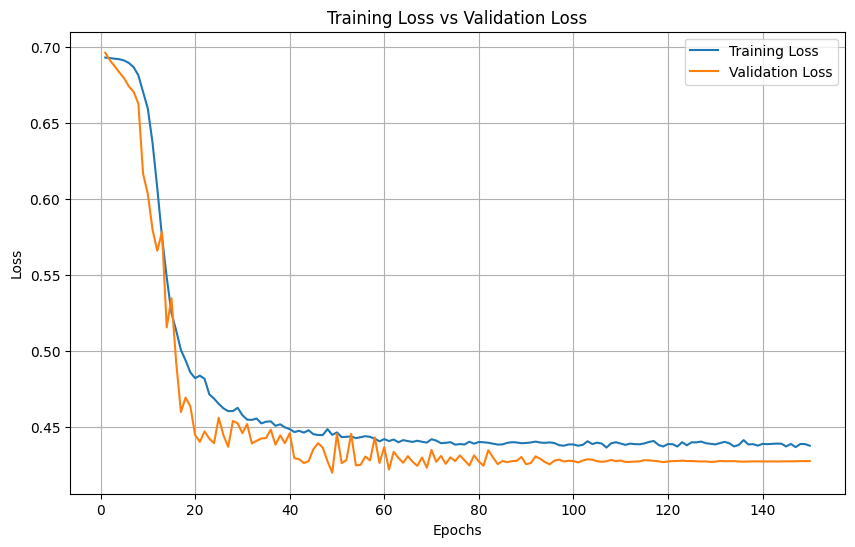

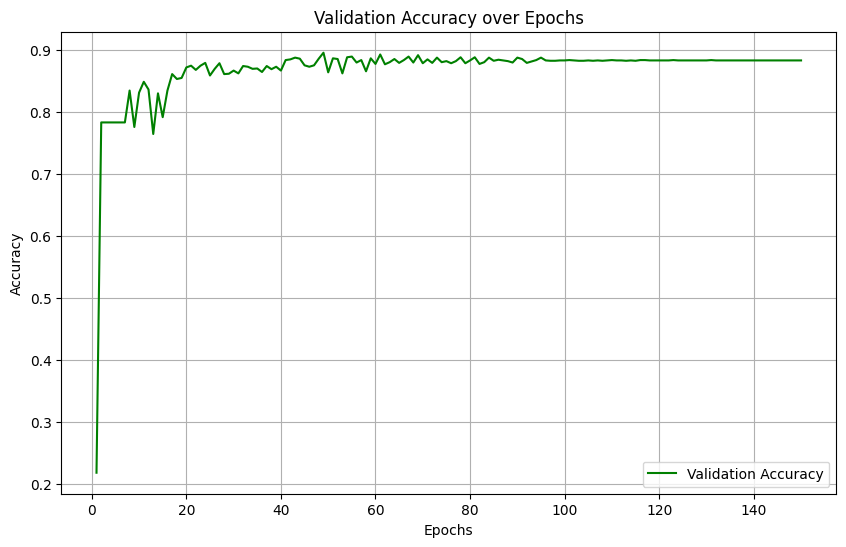

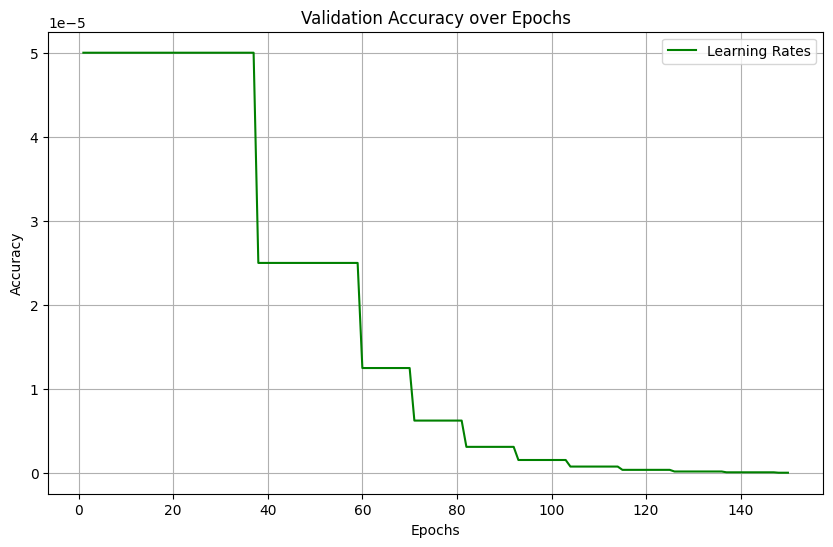

Model for bin 2 saved to 3DCholesterolModels-5A/model_bin_2.pth
1925 is length of subset grid
Training on bin 3
Bin 3, Epoch 1/150, Train Loss: 0.6930, Validation Loss: 0.6962, Validation Accuracy: 0.2175, Grad Norm: 0.0714, LR: 0.000050
Bin 3, Epoch 11/150, Train Loss: 0.5916, Validation Loss: 0.5503, Validation Accuracy: 0.8390, Grad Norm: 5.8323, LR: 0.000050
Bin 3, Epoch 21/150, Train Loss: 0.4700, Validation Loss: 0.4732, Validation Accuracy: 0.8452, Grad Norm: 1.0293, LR: 0.000050
Bin 3, Epoch 31/150, Train Loss: 0.4583, Validation Loss: 0.4207, Validation Accuracy: 0.8927, Grad Norm: 1.7153, LR: 0.000050
Bin 3, Epoch 41/150, Train Loss: 0.4582, Validation Loss: 0.4514, Validation Accuracy: 0.8571, Grad Norm: 6.6014, LR: 0.000050
Bin 3, Epoch 51/150, Train Loss: 0.4489, Validation Loss: 0.4302, Validation Accuracy: 0.8797, Grad Norm: 2.8922, LR: 0.000025
Bin 3, Epoch 61/150, Train Loss: 0.4461, Validation Loss: 0.4263, Validation Accuracy: 0.8853, Grad Norm: 1.0036, LR: 0.000013


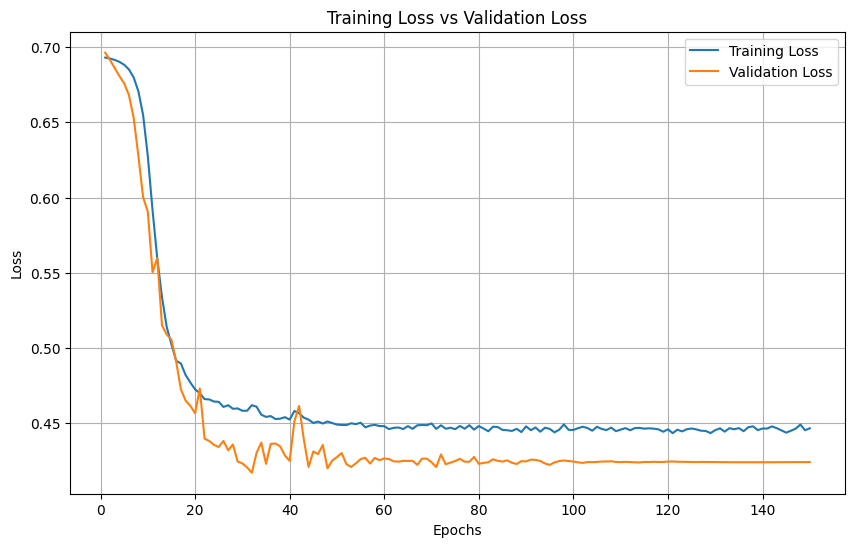

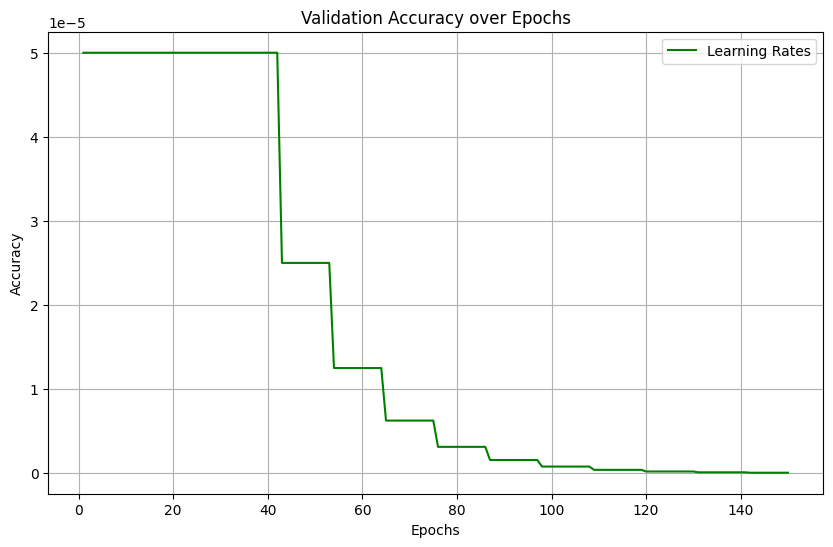

Model for bin 3 saved to 3DCholesterolModels-5A/model_bin_3.pth
1925 is length of subset grid
Training on bin 4
Bin 4, Epoch 1/150, Train Loss: 0.6931, Validation Loss: 0.6889, Validation Accuracy: 0.7825, Grad Norm: 0.0161, LR: 0.000050
Bin 4, Epoch 11/150, Train Loss: 0.5993, Validation Loss: 0.5308, Validation Accuracy: 0.8503, Grad Norm: 1.2875, LR: 0.000050
Bin 4, Epoch 21/150, Train Loss: 0.4597, Validation Loss: 0.4463, Validation Accuracy: 0.8678, Grad Norm: 2.8558, LR: 0.000050
Bin 4, Epoch 31/150, Train Loss: 0.4481, Validation Loss: 0.4205, Validation Accuracy: 0.8955, Grad Norm: 1.3867, LR: 0.000050
Bin 4, Epoch 41/150, Train Loss: 0.4410, Validation Loss: 0.4284, Validation Accuracy: 0.8797, Grad Norm: 0.4763, LR: 0.000050
Bin 4, Epoch 51/150, Train Loss: 0.4404, Validation Loss: 0.4314, Validation Accuracy: 0.8774, Grad Norm: 3.0159, LR: 0.000050
Bin 4, Epoch 61/150, Train Loss: 0.4358, Validation Loss: 0.4289, Validation Accuracy: 0.8785, Grad Norm: 0.9477, LR: 0.000025


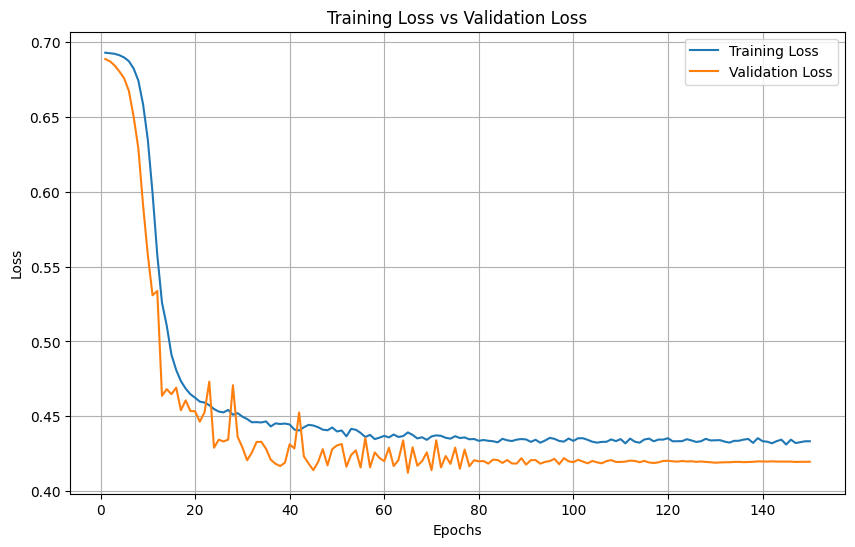

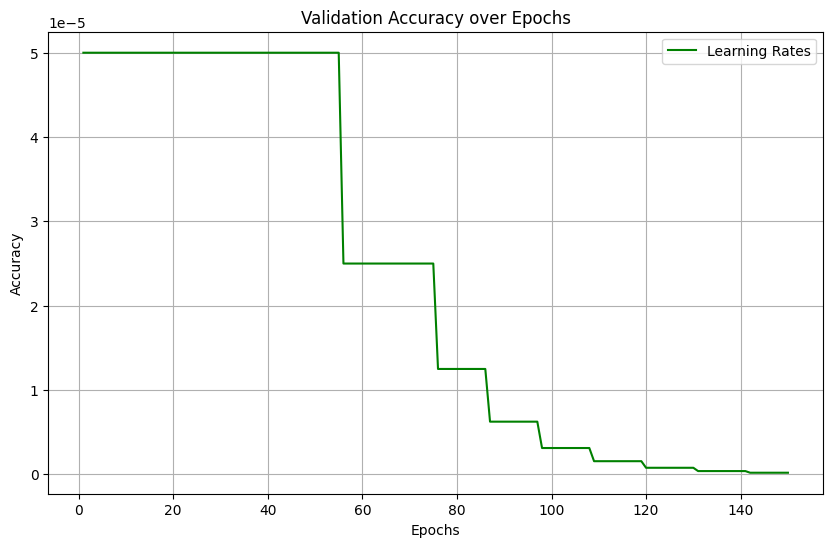

Model for bin 4 saved to 3DCholesterolModels-5A/model_bin_4.pth
1925 is length of subset grid
Training on bin 5
Bin 5, Epoch 1/150, Train Loss: 0.6930, Validation Loss: 0.6988, Validation Accuracy: 0.2175, Grad Norm: 0.1017, LR: 0.000050
Bin 5, Epoch 11/150, Train Loss: 0.6212, Validation Loss: 0.5670, Validation Accuracy: 0.8525, Grad Norm: 1.0050, LR: 0.000050
Bin 5, Epoch 21/150, Train Loss: 0.4665, Validation Loss: 0.4575, Validation Accuracy: 0.8633, Grad Norm: 0.7369, LR: 0.000050
Bin 5, Epoch 31/150, Train Loss: 0.4566, Validation Loss: 0.4556, Validation Accuracy: 0.8616, Grad Norm: 6.3144, LR: 0.000050
Bin 5, Epoch 41/150, Train Loss: 0.4436, Validation Loss: 0.4322, Validation Accuracy: 0.8819, Grad Norm: 0.8547, LR: 0.000050
Bin 5, Epoch 51/150, Train Loss: 0.4349, Validation Loss: 0.4221, Validation Accuracy: 0.8927, Grad Norm: 0.9625, LR: 0.000025
Bin 5, Epoch 61/150, Train Loss: 0.4334, Validation Loss: 0.4223, Validation Accuracy: 0.8904, Grad Norm: 0.3749, LR: 0.000013


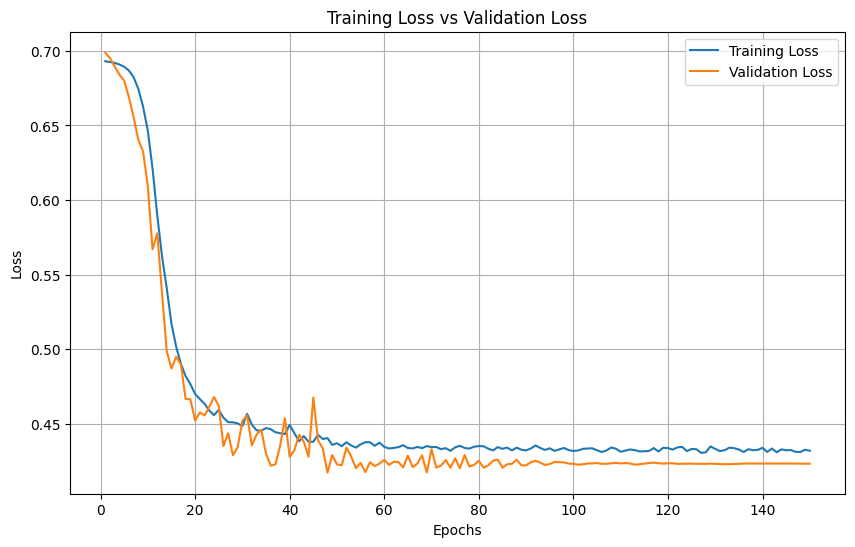

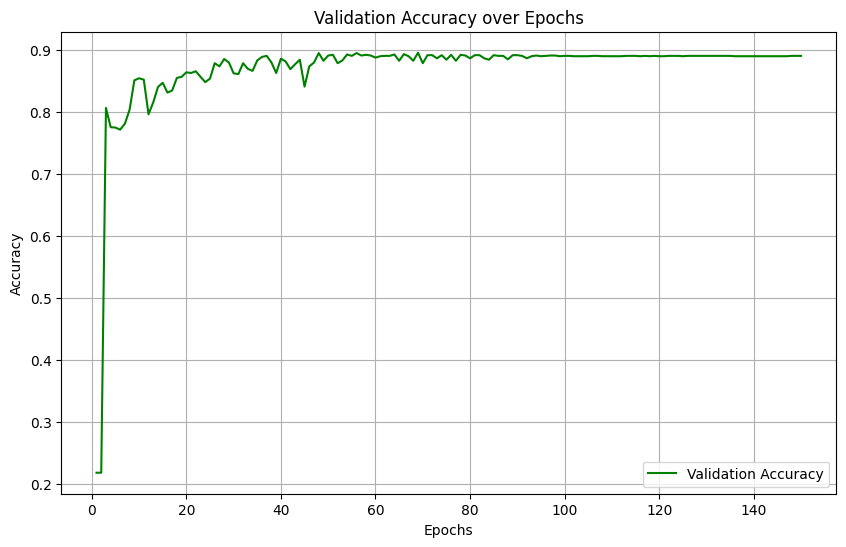

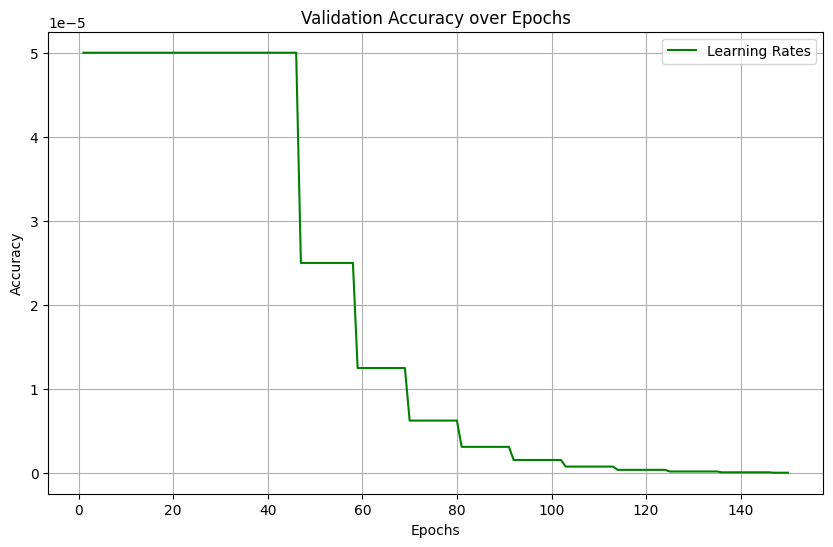

Model for bin 5 saved to 3DCholesterolModels-5A/model_bin_5.pth
1925 is length of subset grid
Training on bin 6
Bin 6, Epoch 1/150, Train Loss: 0.6929, Validation Loss: 0.6897, Validation Accuracy: 0.7825, Grad Norm: 0.0400, LR: 0.000050
Bin 6, Epoch 11/150, Train Loss: 0.5728, Validation Loss: 0.5251, Validation Accuracy: 0.8441, Grad Norm: 2.6804, LR: 0.000050
Bin 6, Epoch 21/150, Train Loss: 0.4553, Validation Loss: 0.4542, Validation Accuracy: 0.8644, Grad Norm: 1.1692, LR: 0.000050
Bin 6, Epoch 31/150, Train Loss: 0.4435, Validation Loss: 0.4326, Validation Accuracy: 0.8831, Grad Norm: 1.8870, LR: 0.000050
Bin 6, Epoch 41/150, Train Loss: 0.4384, Validation Loss: 0.4192, Validation Accuracy: 0.8927, Grad Norm: 6.4583, LR: 0.000025
Bin 6, Epoch 51/150, Train Loss: 0.4339, Validation Loss: 0.4217, Validation Accuracy: 0.8898, Grad Norm: 2.7527, LR: 0.000025
Bin 6, Epoch 61/150, Train Loss: 0.4351, Validation Loss: 0.4228, Validation Accuracy: 0.8870, Grad Norm: 1.0502, LR: 0.000013


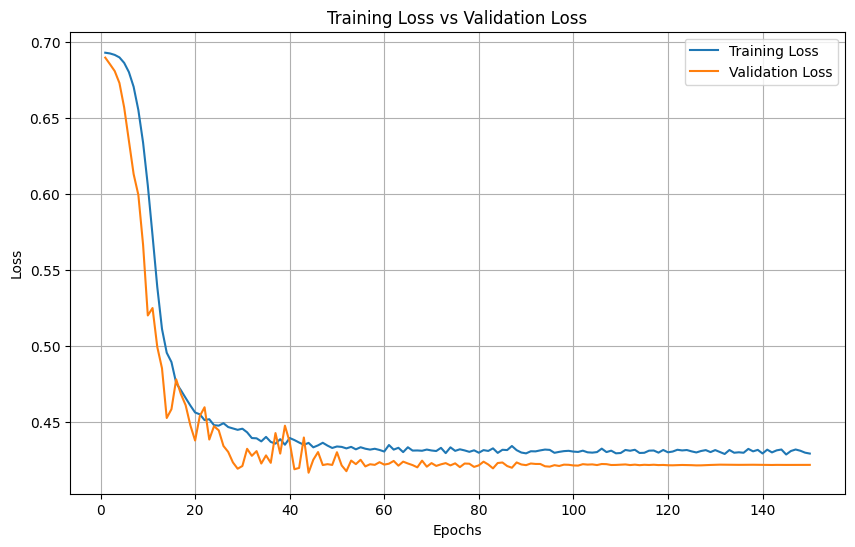

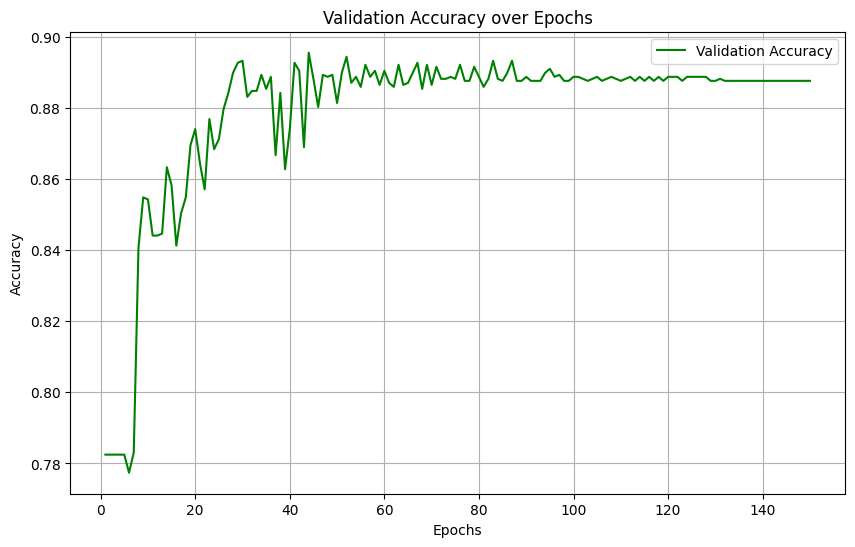

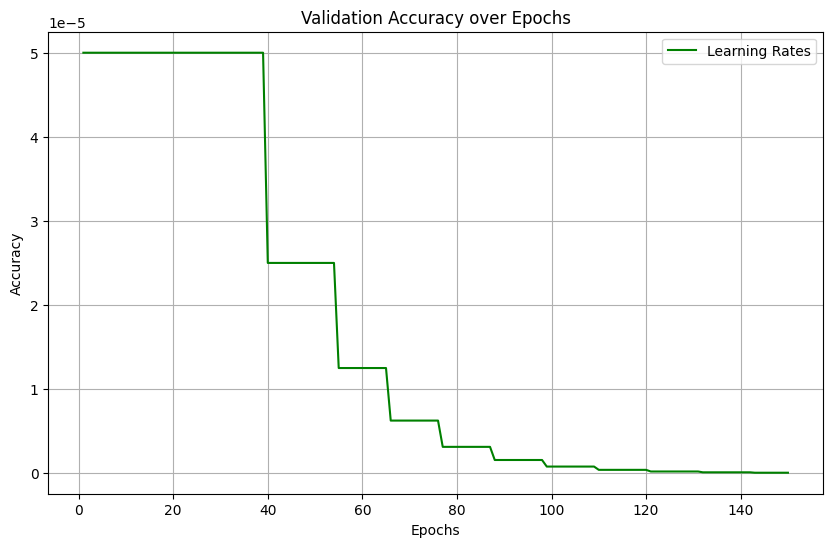

Model for bin 6 saved to 3DCholesterolModels-5A/model_bin_6.pth
1925 is length of subset grid
Training on bin 7
Bin 7, Epoch 1/150, Train Loss: 0.6930, Validation Loss: 0.6878, Validation Accuracy: 0.7825, Grad Norm: 0.0275, LR: 0.000050
Bin 7, Epoch 11/150, Train Loss: 0.6319, Validation Loss: 0.5878, Validation Accuracy: 0.8486, Grad Norm: 1.2781, LR: 0.000050
Bin 7, Epoch 21/150, Train Loss: 0.4730, Validation Loss: 0.4526, Validation Accuracy: 0.8667, Grad Norm: 4.6220, LR: 0.000050
Bin 7, Epoch 31/150, Train Loss: 0.4538, Validation Loss: 0.4238, Validation Accuracy: 0.8910, Grad Norm: 6.0074, LR: 0.000050
Bin 7, Epoch 41/150, Train Loss: 0.4448, Validation Loss: 0.4319, Validation Accuracy: 0.8836, Grad Norm: 0.4277, LR: 0.000050
Bin 7, Epoch 51/150, Train Loss: 0.4421, Validation Loss: 0.4198, Validation Accuracy: 0.8938, Grad Norm: 5.9377, LR: 0.000050
Bin 7, Epoch 61/150, Train Loss: 0.4406, Validation Loss: 0.4283, Validation Accuracy: 0.8819, Grad Norm: 6.0706, LR: 0.000050


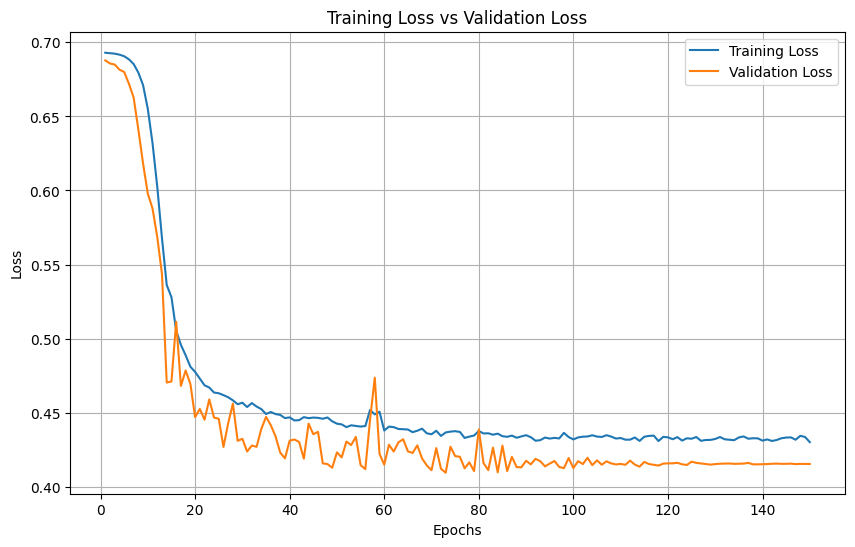

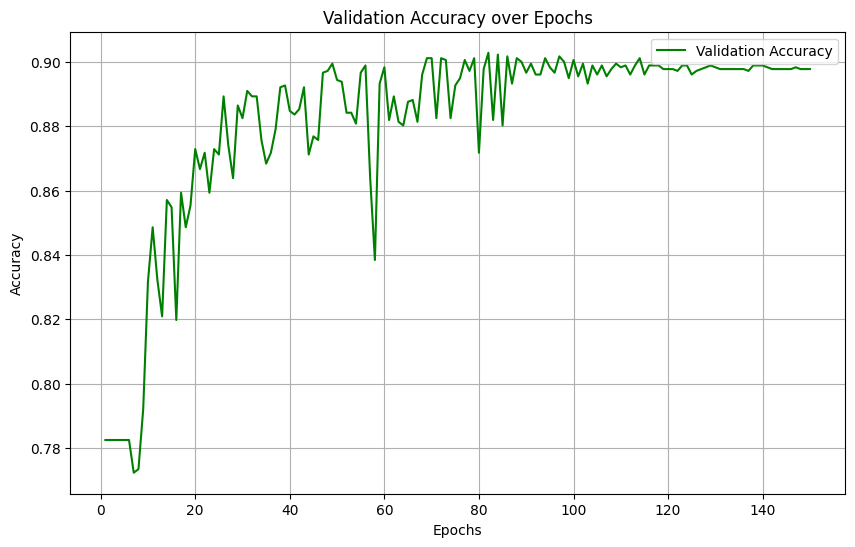

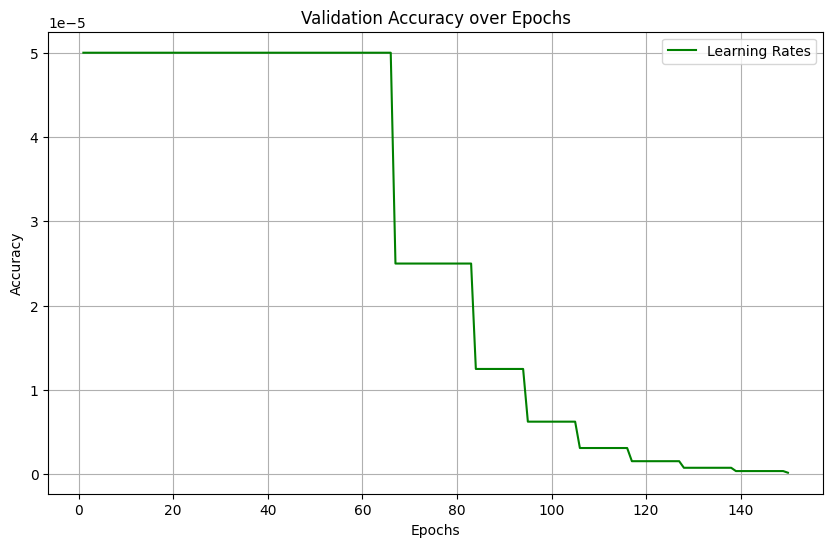

Model for bin 7 saved to 3DCholesterolModels-5A/model_bin_7.pth
1925 is length of subset grid
Training on bin 8
Bin 8, Epoch 1/150, Train Loss: 0.6929, Validation Loss: 0.6877, Validation Accuracy: 0.7825, Grad Norm: 0.0227, LR: 0.000050
Bin 8, Epoch 11/150, Train Loss: 0.5794, Validation Loss: 0.5431, Validation Accuracy: 0.8339, Grad Norm: 2.6883, LR: 0.000050
Bin 8, Epoch 21/150, Train Loss: 0.4622, Validation Loss: 0.4580, Validation Accuracy: 0.8582, Grad Norm: 0.5523, LR: 0.000050
Bin 8, Epoch 31/150, Train Loss: 0.4516, Validation Loss: 0.4256, Validation Accuracy: 0.8898, Grad Norm: 4.4268, LR: 0.000050
Bin 8, Epoch 41/150, Train Loss: 0.4475, Validation Loss: 0.4271, Validation Accuracy: 0.8859, Grad Norm: 0.7301, LR: 0.000050
Bin 8, Epoch 51/150, Train Loss: 0.4479, Validation Loss: 0.4179, Validation Accuracy: 0.8972, Grad Norm: 5.3277, LR: 0.000025
Bin 8, Epoch 61/150, Train Loss: 0.4391, Validation Loss: 0.4242, Validation Accuracy: 0.8876, Grad Norm: 0.6224, LR: 0.000025


Model for bin 8 saved to 3DCholesterolModels-5A/model_bin_8.pth
1925 is length of subset grid
Training on bin 9
Bin 9, Epoch 1/150, Train Loss: 0.6933, Validation Loss: 0.6812, Validation Accuracy: 0.7825, Grad Norm: 0.0552, LR: 0.000050
Bin 9, Epoch 11/150, Train Loss: 0.6109, Validation Loss: 0.5640, Validation Accuracy: 0.8424, Grad Norm: 1.9457, LR: 0.000050
Bin 9, Epoch 21/150, Train Loss: 0.4769, Validation Loss: 0.4611, Validation Accuracy: 0.8582, Grad Norm: 2.8930, LR: 0.000050
Bin 9, Epoch 31/150, Train Loss: 0.4601, Validation Loss: 0.4282, Validation Accuracy: 0.8859, Grad Norm: 3.0535, LR: 0.000050
Bin 9, Epoch 41/150, Train Loss: 0.4545, Validation Loss: 0.4286, Validation Accuracy: 0.8864, Grad Norm: 0.6008, LR: 0.000025
Bin 9, Epoch 51/150, Train Loss: 0.4528, Validation Loss: 0.4202, Validation Accuracy: 0.8938, Grad Norm: 1.6580, LR: 0.000025
Bin 9, Epoch 61/150, Train Loss: 0.4514, Validation Loss: 0.4255, Validation Accuracy: 0.8853, Grad Norm: 6.4403, LR: 0.000025


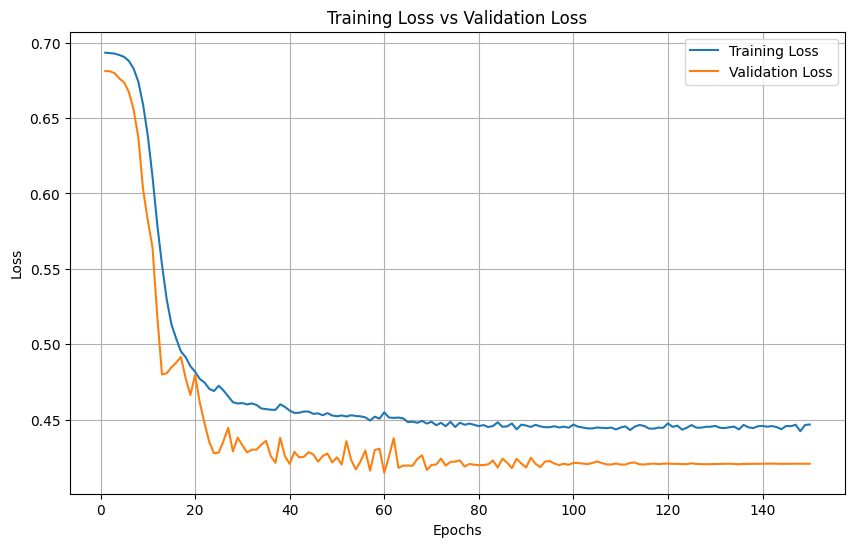

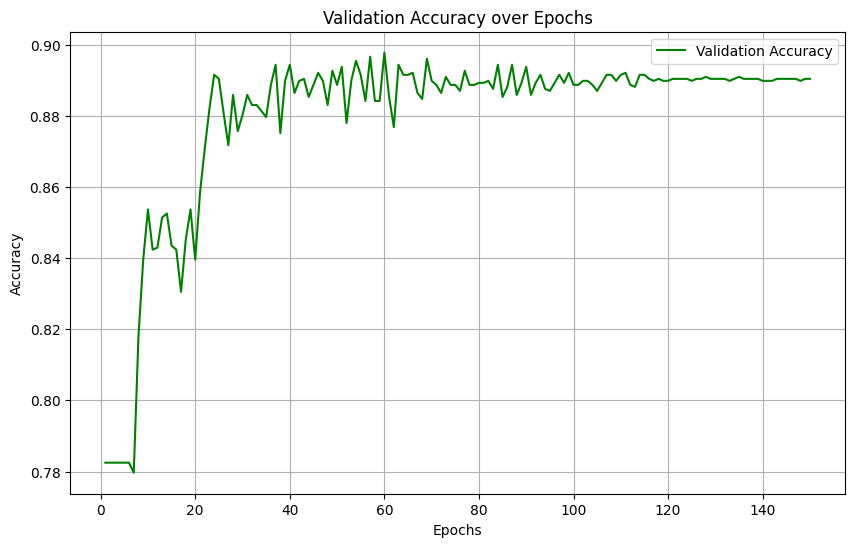

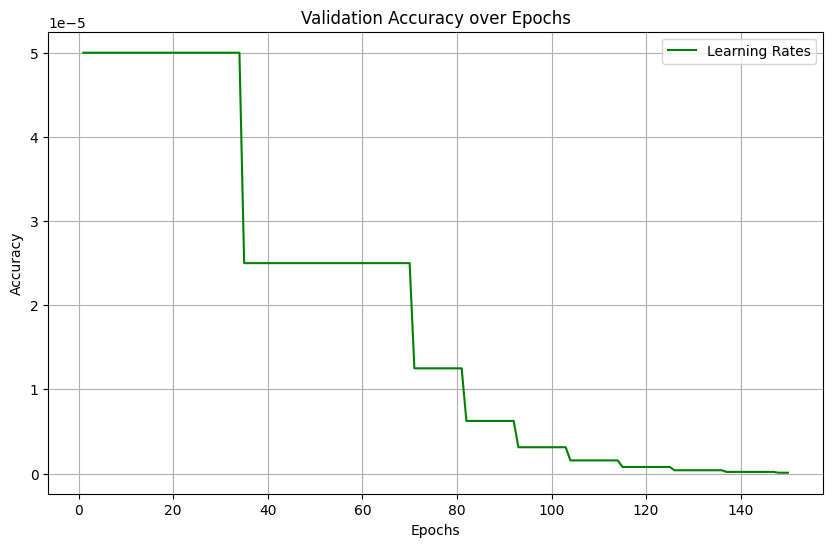

Model for bin 9 saved to 3DCholesterolModels-5A/model_bin_9.pth
1925 is length of subset grid
Training on bin 10
Bin 10, Epoch 1/150, Train Loss: 0.6932, Validation Loss: 0.7000, Validation Accuracy: 0.2175, Grad Norm: 0.0292, LR: 0.000050
Bin 10, Epoch 11/150, Train Loss: 0.6226, Validation Loss: 0.5345, Validation Accuracy: 0.8593, Grad Norm: 1.1440, LR: 0.000050
Bin 10, Epoch 21/150, Train Loss: 0.4619, Validation Loss: 0.4473, Validation Accuracy: 0.8684, Grad Norm: 0.3857, LR: 0.000050
Bin 10, Epoch 31/150, Train Loss: 0.4496, Validation Loss: 0.4349, Validation Accuracy: 0.8774, Grad Norm: 1.7353, LR: 0.000050
Bin 10, Epoch 41/150, Train Loss: 0.4432, Validation Loss: 0.4231, Validation Accuracy: 0.8910, Grad Norm: 0.8435, LR: 0.000050
Bin 10, Epoch 51/150, Train Loss: 0.4416, Validation Loss: 0.4134, Validation Accuracy: 0.8989, Grad Norm: 0.9979, LR: 0.000050
Bin 10, Epoch 61/150, Train Loss: 0.4354, Validation Loss: 0.4201, Validation Accuracy: 0.8904, Grad Norm: 3.7769, LR: 0

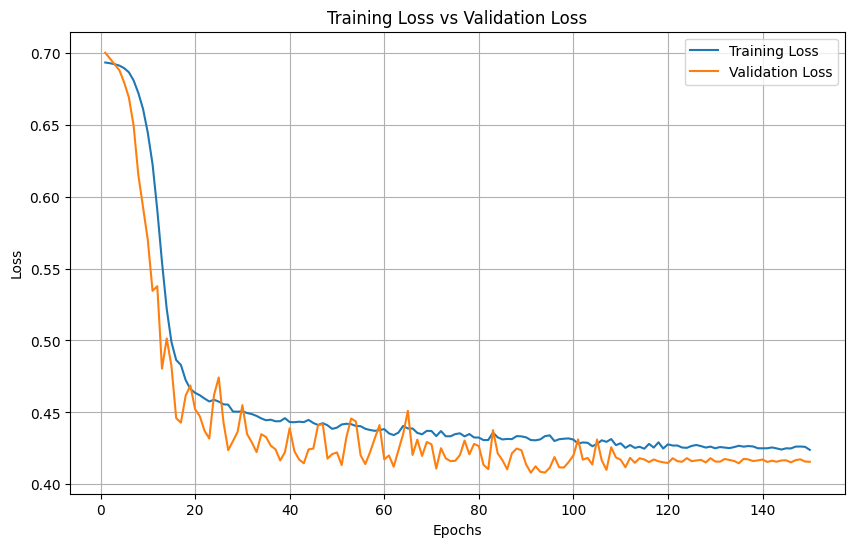

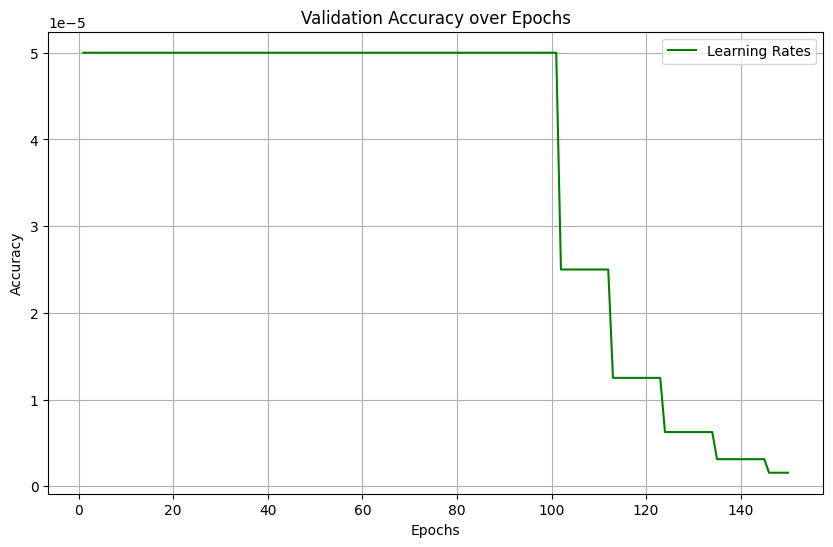

Model for bin 10 saved to 3DCholesterolModels-5A/model_bin_10.pth
1925 is length of subset grid
Training on bin 11
Bin 11, Epoch 1/150, Train Loss: 0.6933, Validation Loss: 0.7012, Validation Accuracy: 0.2175, Grad Norm: 0.0550, LR: 0.000050
Bin 11, Epoch 11/150, Train Loss: 0.6151, Validation Loss: 0.5184, Validation Accuracy: 0.8345, Grad Norm: 2.0861, LR: 0.000050
Bin 11, Epoch 21/150, Train Loss: 0.4732, Validation Loss: 0.4421, Validation Accuracy: 0.8740, Grad Norm: 4.7678, LR: 0.000050
Bin 11, Epoch 31/150, Train Loss: 0.4590, Validation Loss: 0.4365, Validation Accuracy: 0.8757, Grad Norm: 0.8231, LR: 0.000050
Bin 11, Epoch 41/150, Train Loss: 0.4517, Validation Loss: 0.4428, Validation Accuracy: 0.8672, Grad Norm: 2.9308, LR: 0.000050
Bin 11, Epoch 51/150, Train Loss: 0.4477, Validation Loss: 0.4286, Validation Accuracy: 0.8825, Grad Norm: 2.0080, LR: 0.000025
Bin 11, Epoch 61/150, Train Loss: 0.4464, Validation Loss: 0.4234, Validation Accuracy: 0.8876, Grad Norm: 1.0907, LR:

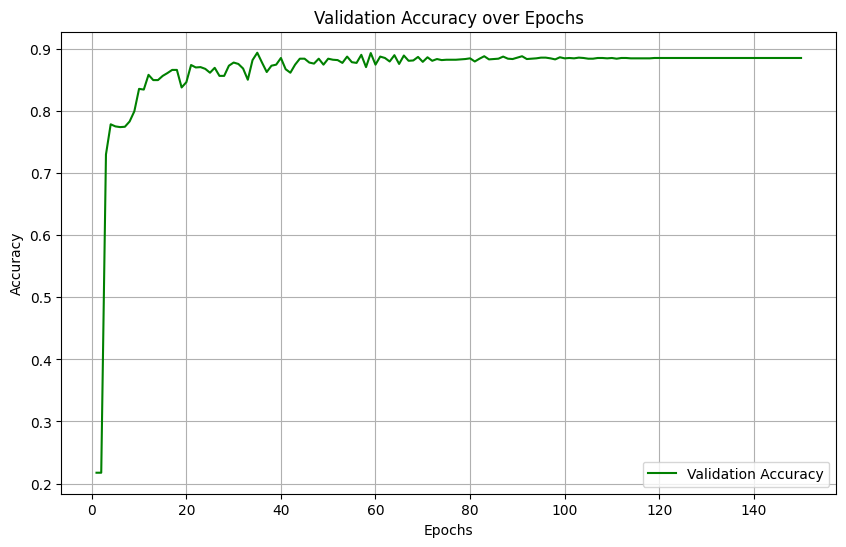

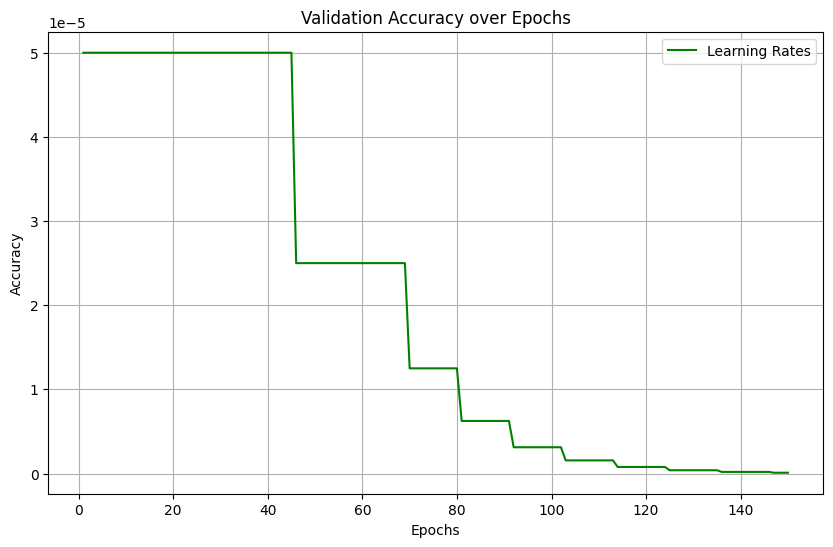

Model for bin 11 saved to 3DCholesterolModels-5A/model_bin_11.pth
1925 is length of subset grid
Training on bin 12
Bin 12, Epoch 1/150, Train Loss: 0.6930, Validation Loss: 0.6924, Validation Accuracy: 0.8090, Grad Norm: 0.0386, LR: 0.000050
Bin 12, Epoch 11/150, Train Loss: 0.5630, Validation Loss: 0.5254, Validation Accuracy: 0.8418, Grad Norm: 1.3064, LR: 0.000050
Bin 12, Epoch 21/150, Train Loss: 0.4617, Validation Loss: 0.4401, Validation Accuracy: 0.8757, Grad Norm: 3.7631, LR: 0.000050
Bin 12, Epoch 31/150, Train Loss: 0.4504, Validation Loss: 0.4400, Validation Accuracy: 0.8729, Grad Norm: 6.3625, LR: 0.000050
Bin 12, Epoch 41/150, Train Loss: 0.4432, Validation Loss: 0.4221, Validation Accuracy: 0.8921, Grad Norm: 0.7260, LR: 0.000025
Bin 12, Epoch 51/150, Train Loss: 0.4439, Validation Loss: 0.4263, Validation Accuracy: 0.8859, Grad Norm: 4.4511, LR: 0.000025
Bin 12, Epoch 61/150, Train Loss: 0.4431, Validation Loss: 0.4175, Validation Accuracy: 0.8949, Grad Norm: 1.3477, LR:

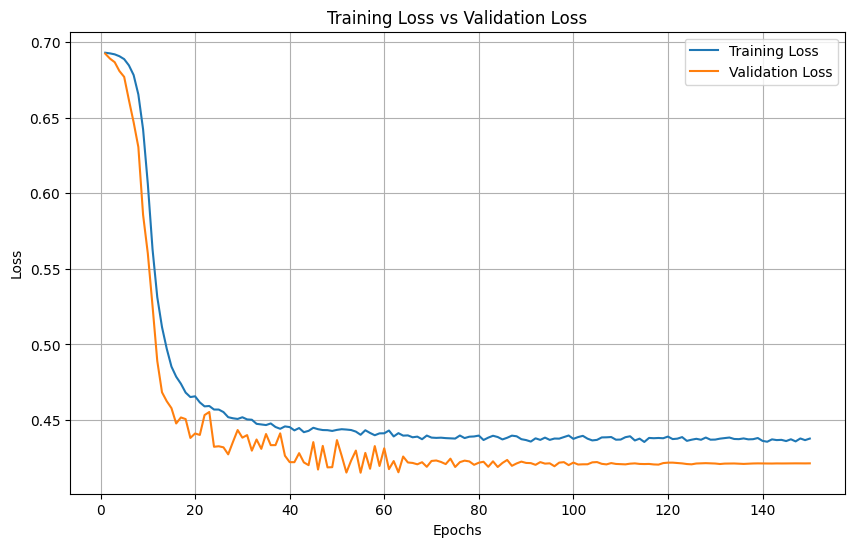

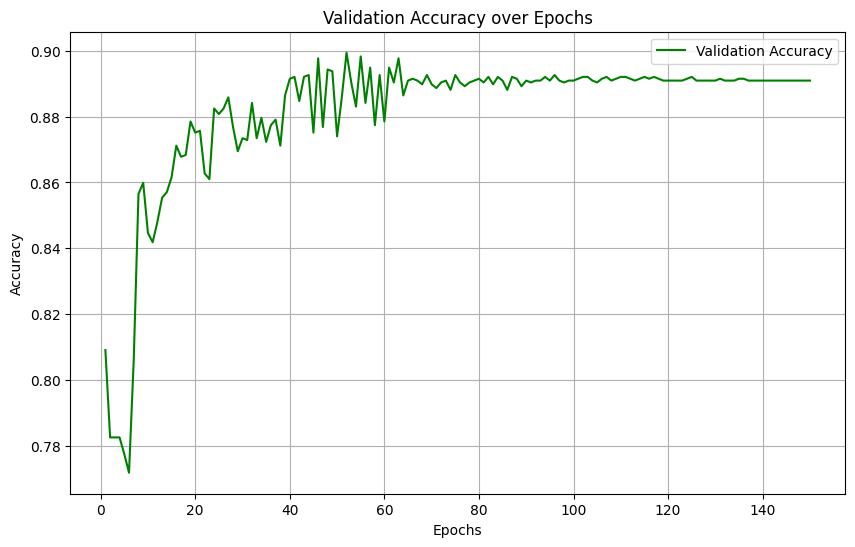

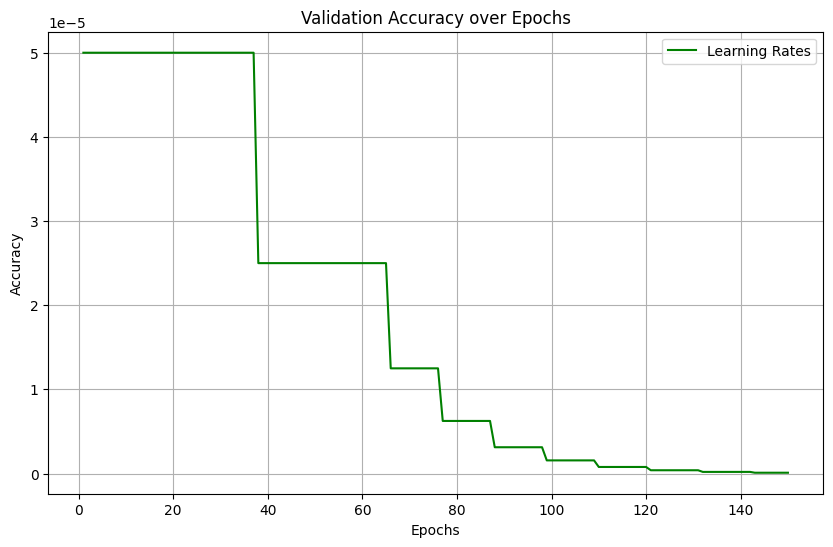

Model for bin 12 saved to 3DCholesterolModels-5A/model_bin_12.pth
1925 is length of subset grid
Training on bin 13
Bin 13, Epoch 1/150, Train Loss: 0.6931, Validation Loss: 0.6834, Validation Accuracy: 0.7825, Grad Norm: 0.0464, LR: 0.000050
Bin 13, Epoch 11/150, Train Loss: 0.5930, Validation Loss: 0.5205, Validation Accuracy: 0.8497, Grad Norm: 2.5394, LR: 0.000050
Bin 13, Epoch 21/150, Train Loss: 0.4678, Validation Loss: 0.4538, Validation Accuracy: 0.8650, Grad Norm: 1.4188, LR: 0.000050
Bin 13, Epoch 31/150, Train Loss: 0.4580, Validation Loss: 0.4270, Validation Accuracy: 0.8876, Grad Norm: 6.2026, LR: 0.000050
Bin 13, Epoch 41/150, Train Loss: 0.4469, Validation Loss: 0.4203, Validation Accuracy: 0.8949, Grad Norm: 0.3647, LR: 0.000050
Bin 13, Epoch 51/150, Train Loss: 0.4412, Validation Loss: 0.4311, Validation Accuracy: 0.8808, Grad Norm: 6.3410, LR: 0.000050
Bin 13, Epoch 61/150, Train Loss: 0.4393, Validation Loss: 0.4322, Validation Accuracy: 0.8791, Grad Norm: 0.6886, LR:

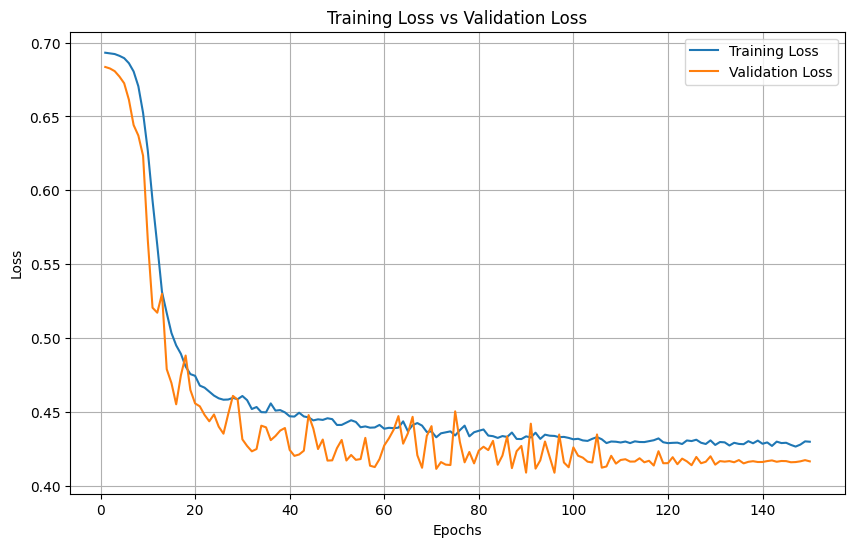

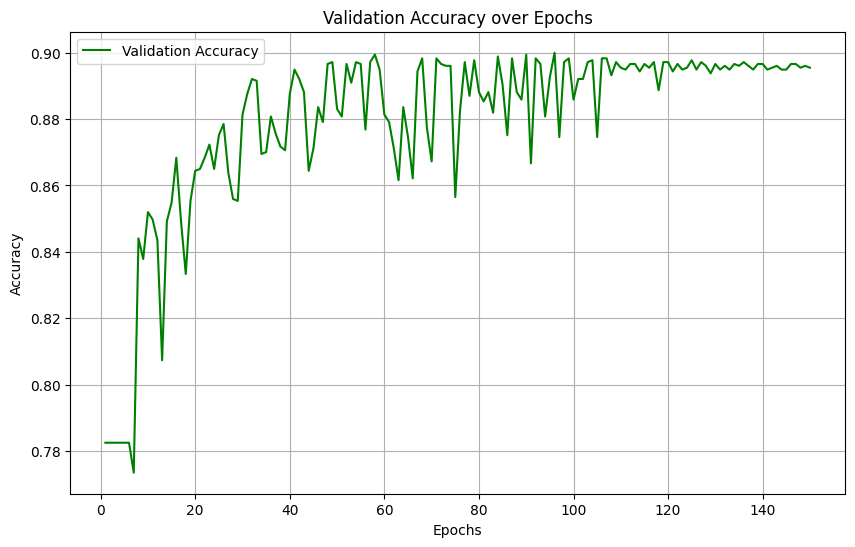

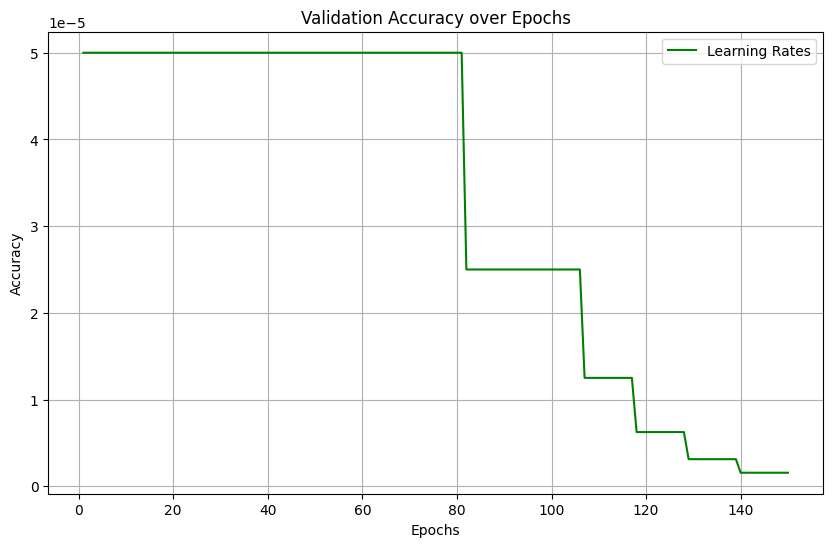

Model for bin 13 saved to 3DCholesterolModels-5A/model_bin_13.pth
1925 is length of subset grid
Training on bin 14
Bin 14, Epoch 1/150, Train Loss: 0.6938, Validation Loss: 0.7096, Validation Accuracy: 0.2175, Grad Norm: 0.1365, LR: 0.000050
Bin 14, Epoch 11/150, Train Loss: 0.6255, Validation Loss: 0.5643, Validation Accuracy: 0.8638, Grad Norm: 2.0109, LR: 0.000050
Bin 14, Epoch 21/150, Train Loss: 0.4655, Validation Loss: 0.4319, Validation Accuracy: 0.8825, Grad Norm: 1.2632, LR: 0.000050
Bin 14, Epoch 31/150, Train Loss: 0.4533, Validation Loss: 0.4333, Validation Accuracy: 0.8802, Grad Norm: 2.7645, LR: 0.000050
Bin 14, Epoch 41/150, Train Loss: 0.4482, Validation Loss: 0.4213, Validation Accuracy: 0.8910, Grad Norm: 1.5536, LR: 0.000050
Bin 14, Epoch 51/150, Train Loss: 0.4405, Validation Loss: 0.4228, Validation Accuracy: 0.8949, Grad Norm: 2.6732, LR: 0.000050
Bin 14, Epoch 61/150, Train Loss: 0.4407, Validation Loss: 0.4270, Validation Accuracy: 0.8881, Grad Norm: 2.1516, LR:

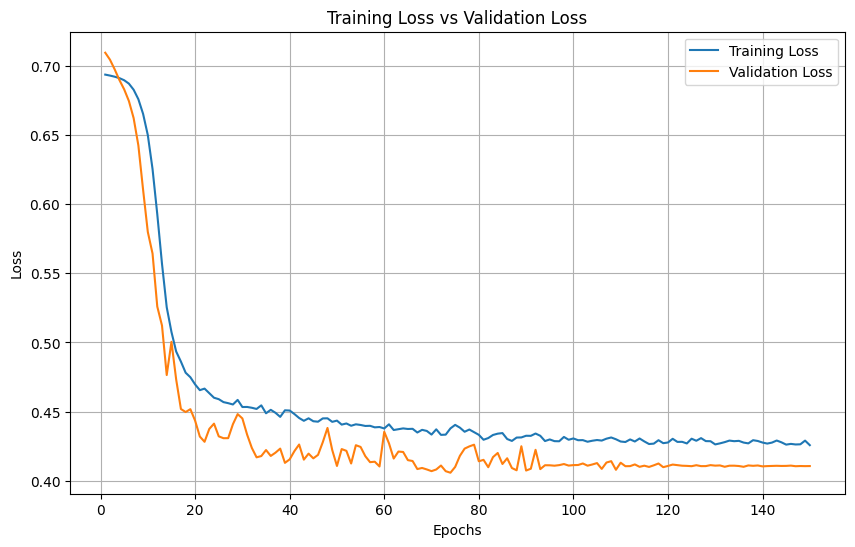

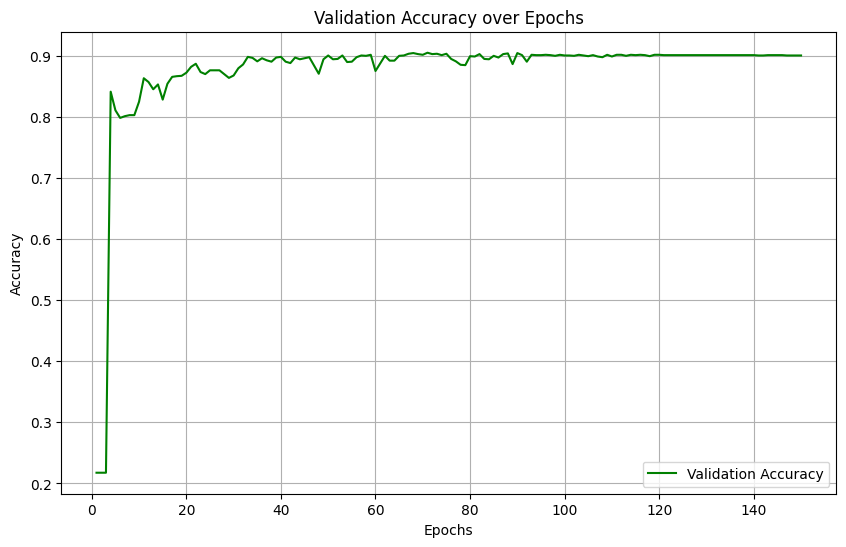

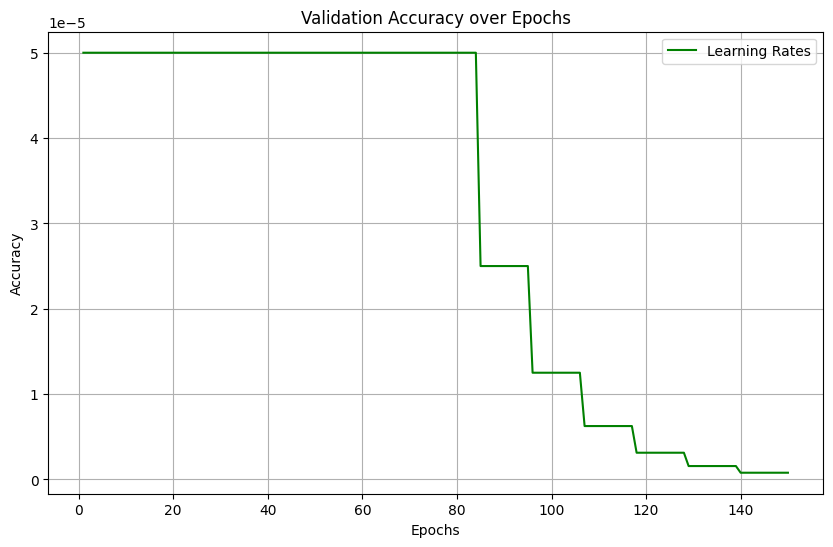

Model for bin 14 saved to 3DCholesterolModels-5A/model_bin_14.pth
1925 is length of subset grid
Training on bin 15
Bin 15, Epoch 1/150, Train Loss: 0.6934, Validation Loss: 0.7075, Validation Accuracy: 0.2175, Grad Norm: 0.0364, LR: 0.000050
Bin 15, Epoch 11/150, Train Loss: 0.6282, Validation Loss: 0.5772, Validation Accuracy: 0.8503, Grad Norm: 0.9216, LR: 0.000050
Bin 15, Epoch 21/150, Train Loss: 0.4738, Validation Loss: 0.4493, Validation Accuracy: 0.8627, Grad Norm: 6.2989, LR: 0.000050
Bin 15, Epoch 31/150, Train Loss: 0.4526, Validation Loss: 0.4371, Validation Accuracy: 0.8729, Grad Norm: 1.2890, LR: 0.000050
Bin 15, Epoch 41/150, Train Loss: 0.4444, Validation Loss: 0.4262, Validation Accuracy: 0.8859, Grad Norm: 0.2984, LR: 0.000050
Bin 15, Epoch 51/150, Train Loss: 0.4385, Validation Loss: 0.4278, Validation Accuracy: 0.8831, Grad Norm: 4.9422, LR: 0.000050
Bin 15, Epoch 61/150, Train Loss: 0.4356, Validation Loss: 0.4200, Validation Accuracy: 0.8927, Grad Norm: 6.1765, LR:

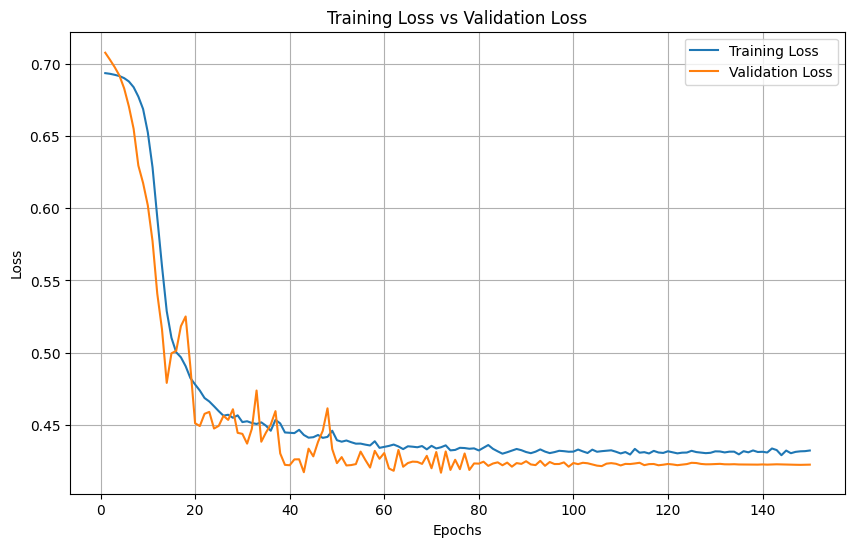

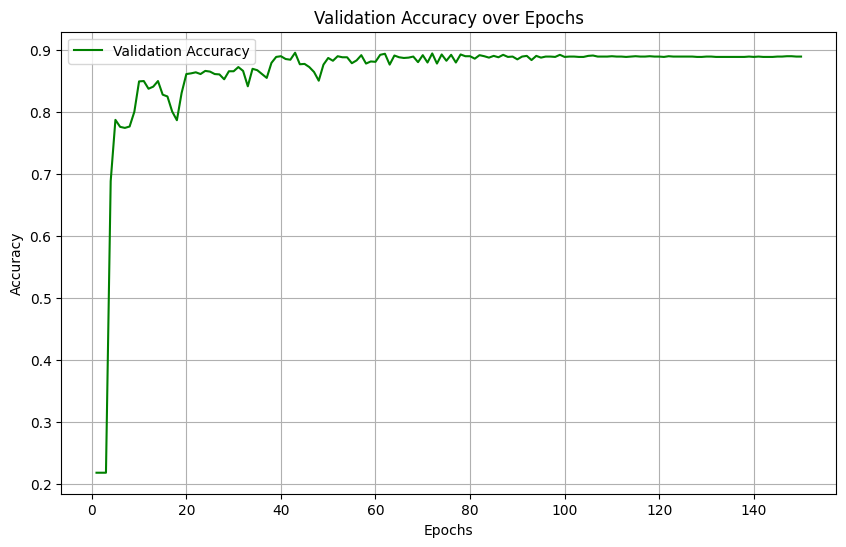

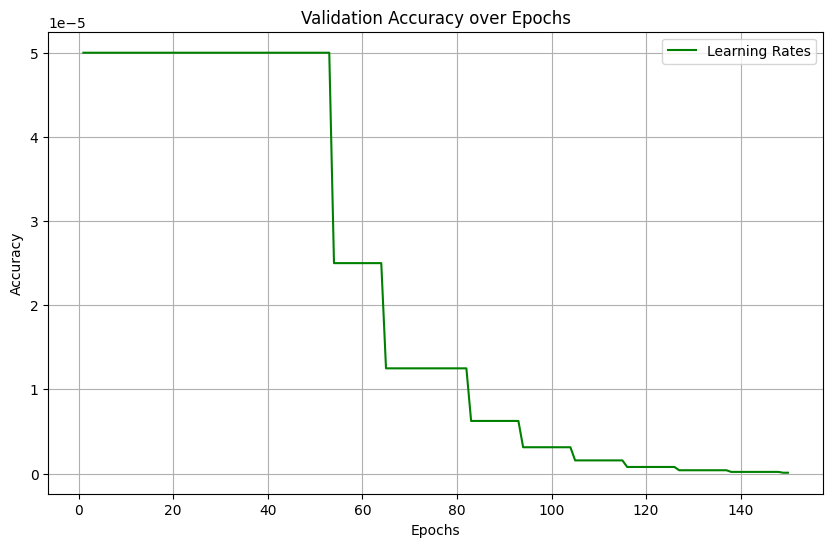

Model for bin 15 saved to 3DCholesterolModels-5A/model_bin_15.pth
1925 is length of subset grid
Training on bin 16
Bin 16, Epoch 1/150, Train Loss: 0.6931, Validation Loss: 0.6832, Validation Accuracy: 0.7825, Grad Norm: 0.1159, LR: 0.000050
Bin 16, Epoch 11/150, Train Loss: 0.5556, Validation Loss: 0.4921, Validation Accuracy: 0.8542, Grad Norm: 2.1113, LR: 0.000050
Bin 16, Epoch 21/150, Train Loss: 0.4636, Validation Loss: 0.4535, Validation Accuracy: 0.8655, Grad Norm: 3.6740, LR: 0.000050
Bin 16, Epoch 31/150, Train Loss: 0.4539, Validation Loss: 0.4288, Validation Accuracy: 0.8842, Grad Norm: 0.4073, LR: 0.000050
Bin 16, Epoch 41/150, Train Loss: 0.4455, Validation Loss: 0.4251, Validation Accuracy: 0.8887, Grad Norm: 1.0662, LR: 0.000025
Bin 16, Epoch 51/150, Train Loss: 0.4471, Validation Loss: 0.4500, Validation Accuracy: 0.8633, Grad Norm: 3.9331, LR: 0.000025
Bin 16, Epoch 61/150, Train Loss: 0.4437, Validation Loss: 0.4317, Validation Accuracy: 0.8785, Grad Norm: 0.3719, LR:

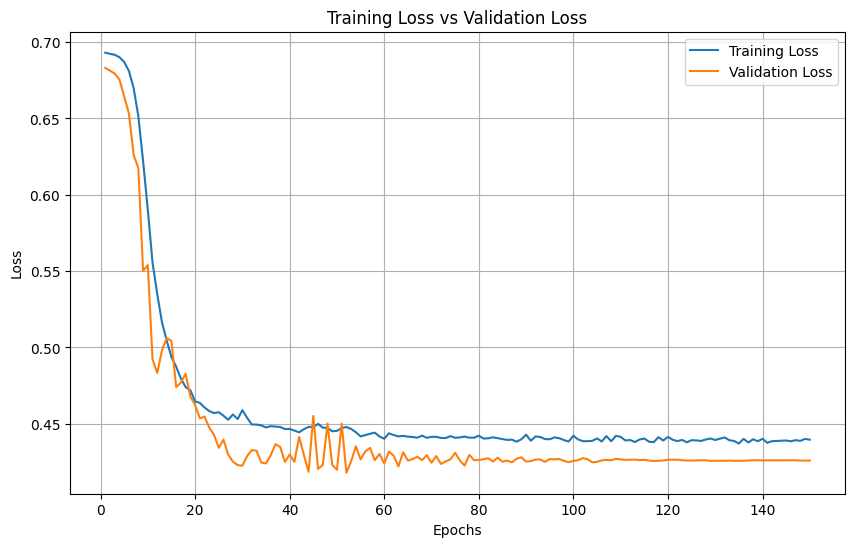

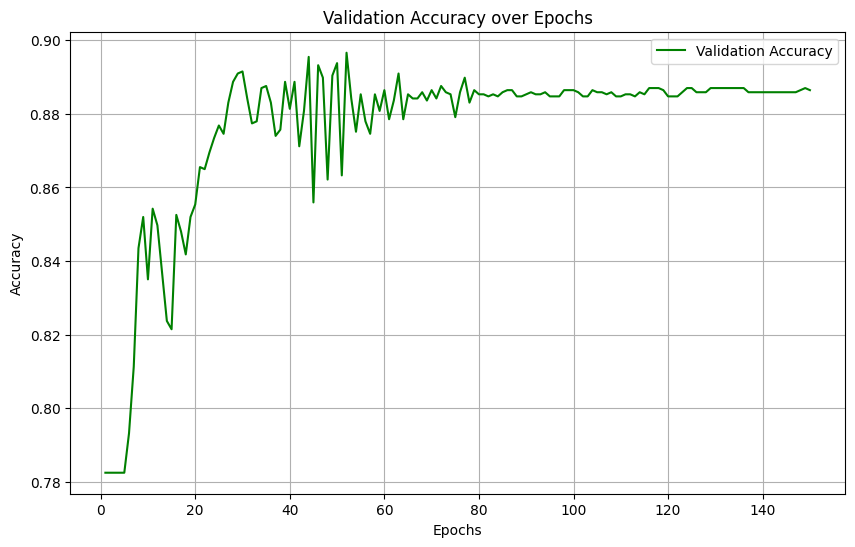

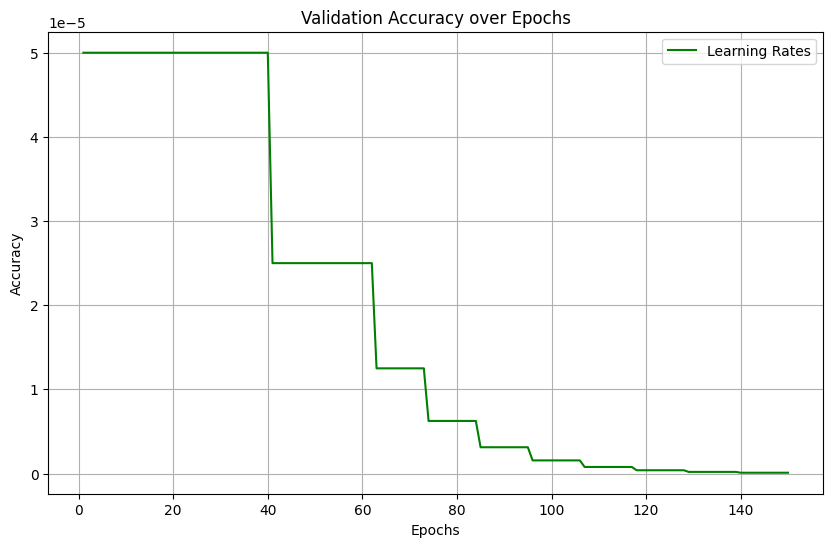

Model for bin 16 saved to 3DCholesterolModels-5A/model_bin_16.pth
1925 is length of subset grid
Training on bin 17
Bin 17, Epoch 1/150, Train Loss: 0.6931, Validation Loss: 0.6880, Validation Accuracy: 0.7825, Grad Norm: 0.1151, LR: 0.000050
Bin 17, Epoch 11/150, Train Loss: 0.5811, Validation Loss: 0.5477, Validation Accuracy: 0.8294, Grad Norm: 4.6867, LR: 0.000050
Bin 17, Epoch 21/150, Train Loss: 0.4721, Validation Loss: 0.4525, Validation Accuracy: 0.8667, Grad Norm: 1.6710, LR: 0.000050
Bin 17, Epoch 31/150, Train Loss: 0.4607, Validation Loss: 0.4327, Validation Accuracy: 0.8774, Grad Norm: 3.2079, LR: 0.000050
Bin 17, Epoch 41/150, Train Loss: 0.4602, Validation Loss: 0.4141, Validation Accuracy: 0.8977, Grad Norm: 5.6687, LR: 0.000050
Bin 17, Epoch 51/150, Train Loss: 0.4500, Validation Loss: 0.4155, Validation Accuracy: 0.8983, Grad Norm: 2.0368, LR: 0.000050
Bin 17, Epoch 61/150, Train Loss: 0.4457, Validation Loss: 0.4277, Validation Accuracy: 0.8802, Grad Norm: 1.7240, LR:

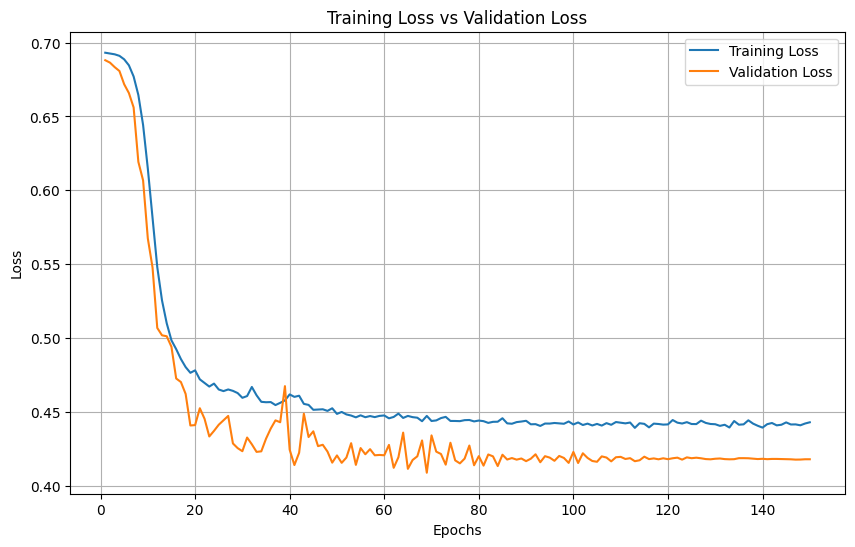

Model for bin 17 saved to 3DCholesterolModels-5A/model_bin_17.pth
1925 is length of subset grid
Training on bin 18
Bin 18, Epoch 1/150, Train Loss: 0.6932, Validation Loss: 0.6838, Validation Accuracy: 0.7825, Grad Norm: 0.0246, LR: 0.000050
Bin 18, Epoch 11/150, Train Loss: 0.6045, Validation Loss: 0.5507, Validation Accuracy: 0.8486, Grad Norm: 1.2902, LR: 0.000050
Bin 18, Epoch 21/150, Train Loss: 0.4617, Validation Loss: 0.4456, Validation Accuracy: 0.8740, Grad Norm: 3.4095, LR: 0.000050
Bin 18, Epoch 31/150, Train Loss: 0.4497, Validation Loss: 0.4286, Validation Accuracy: 0.8842, Grad Norm: 1.8406, LR: 0.000050
Bin 18, Epoch 41/150, Train Loss: 0.4462, Validation Loss: 0.4269, Validation Accuracy: 0.8864, Grad Norm: 0.5932, LR: 0.000050
Bin 18, Epoch 51/150, Train Loss: 0.4492, Validation Loss: 0.4546, Validation Accuracy: 0.8554, Grad Norm: 6.4339, LR: 0.000050
Bin 18, Epoch 61/150, Train Loss: 0.4435, Validation Loss: 0.4264, Validation Accuracy: 0.8842, Grad Norm: 2.8200, LR:

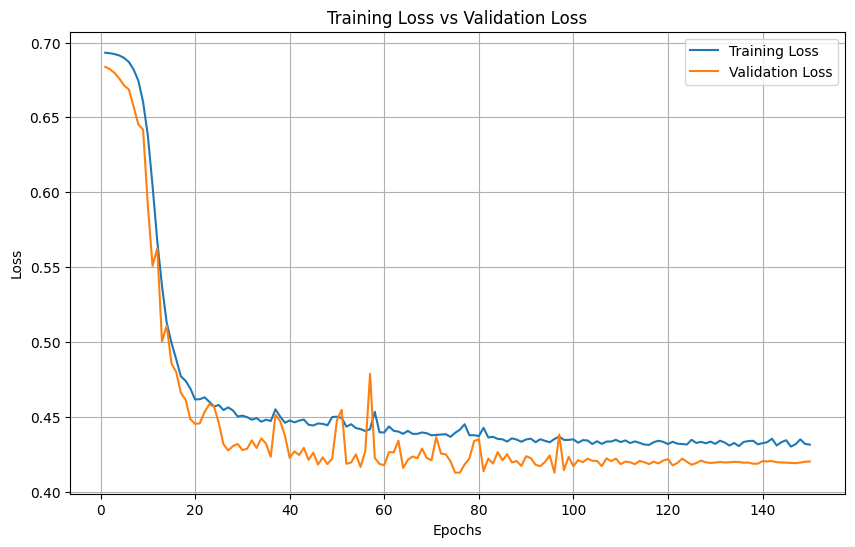

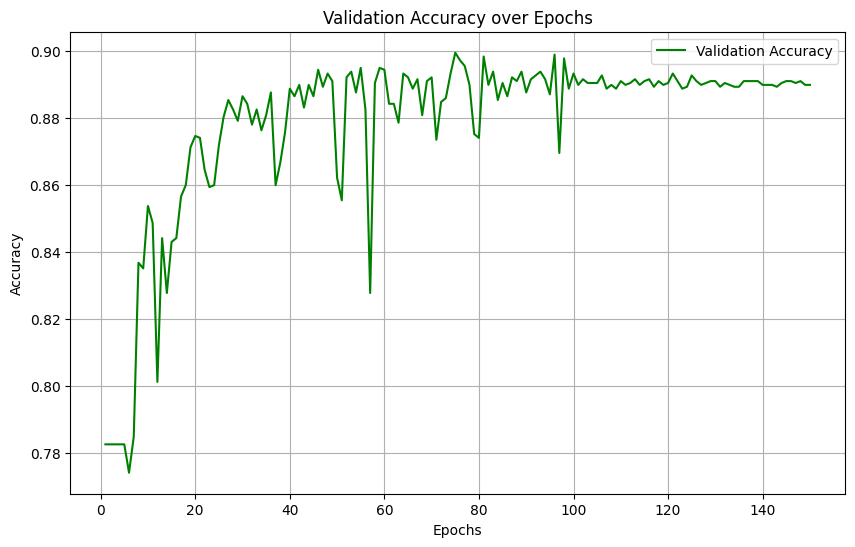

Model for bin 18 saved to 3DCholesterolModels-5A/model_bin_18.pth
1925 is length of subset grid
Training on bin 19
Bin 19, Epoch 1/150, Train Loss: 0.6930, Validation Loss: 0.6898, Validation Accuracy: 0.7825, Grad Norm: 0.0605, LR: 0.000050
Bin 19, Epoch 11/150, Train Loss: 0.5853, Validation Loss: 0.5218, Validation Accuracy: 0.8480, Grad Norm: 4.0797, LR: 0.000050
Bin 19, Epoch 21/150, Train Loss: 0.4696, Validation Loss: 0.4509, Validation Accuracy: 0.8644, Grad Norm: 6.4809, LR: 0.000050
Bin 19, Epoch 31/150, Train Loss: 0.4555, Validation Loss: 0.4289, Validation Accuracy: 0.8819, Grad Norm: 0.3817, LR: 0.000050
Bin 19, Epoch 41/150, Train Loss: 0.4495, Validation Loss: 0.4253, Validation Accuracy: 0.8831, Grad Norm: 0.6691, LR: 0.000050
Bin 19, Epoch 51/150, Train Loss: 0.4457, Validation Loss: 0.4127, Validation Accuracy: 0.8977, Grad Norm: 3.8552, LR: 0.000050
Bin 19, Epoch 61/150, Train Loss: 0.4443, Validation Loss: 0.4210, Validation Accuracy: 0.8904, Grad Norm: 1.1921, LR:

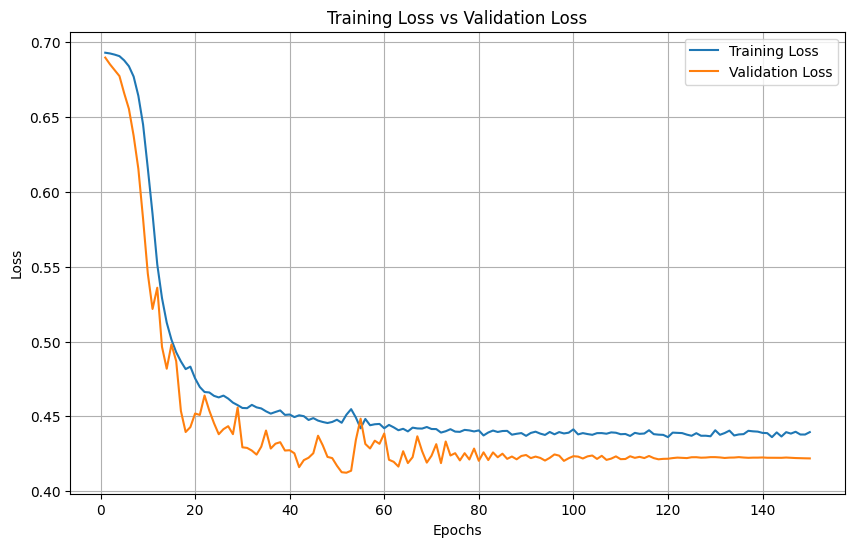

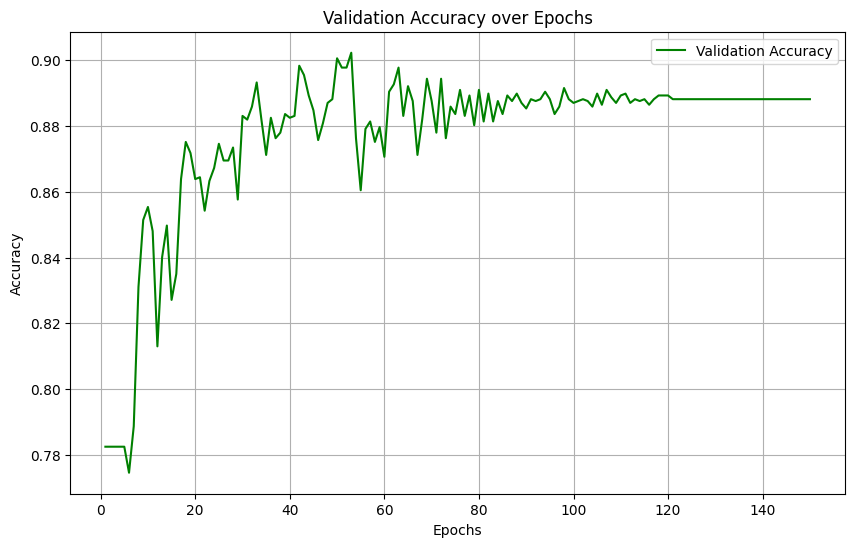

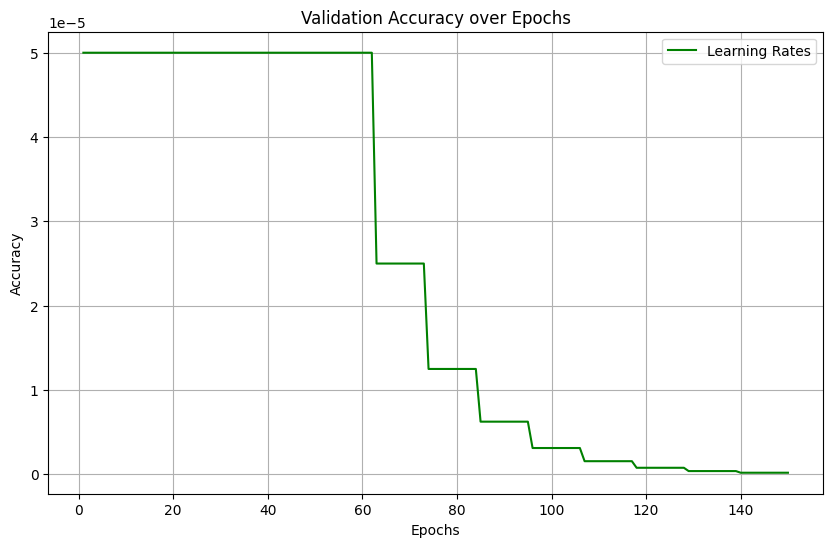

Model for bin 19 saved to 3DCholesterolModels-5A/model_bin_19.pth
1925 is length of subset grid
Training on bin 20
Bin 20, Epoch 1/150, Train Loss: 0.6931, Validation Loss: 0.6992, Validation Accuracy: 0.2175, Grad Norm: 0.0251, LR: 0.000050
Bin 20, Epoch 11/150, Train Loss: 0.6008, Validation Loss: 0.5860, Validation Accuracy: 0.8017, Grad Norm: 1.5959, LR: 0.000050
Bin 20, Epoch 21/150, Train Loss: 0.4646, Validation Loss: 0.4325, Validation Accuracy: 0.8842, Grad Norm: 4.5613, LR: 0.000050
Bin 20, Epoch 31/150, Train Loss: 0.4510, Validation Loss: 0.4277, Validation Accuracy: 0.8887, Grad Norm: 1.9826, LR: 0.000050
Bin 20, Epoch 41/150, Train Loss: 0.4433, Validation Loss: 0.4237, Validation Accuracy: 0.8915, Grad Norm: 0.8445, LR: 0.000050
Bin 20, Epoch 51/150, Train Loss: 0.4431, Validation Loss: 0.4166, Validation Accuracy: 0.8949, Grad Norm: 3.9426, LR: 0.000050
Bin 20, Epoch 61/150, Train Loss: 0.4395, Validation Loss: 0.4327, Validation Accuracy: 0.8791, Grad Norm: 1.1345, LR:

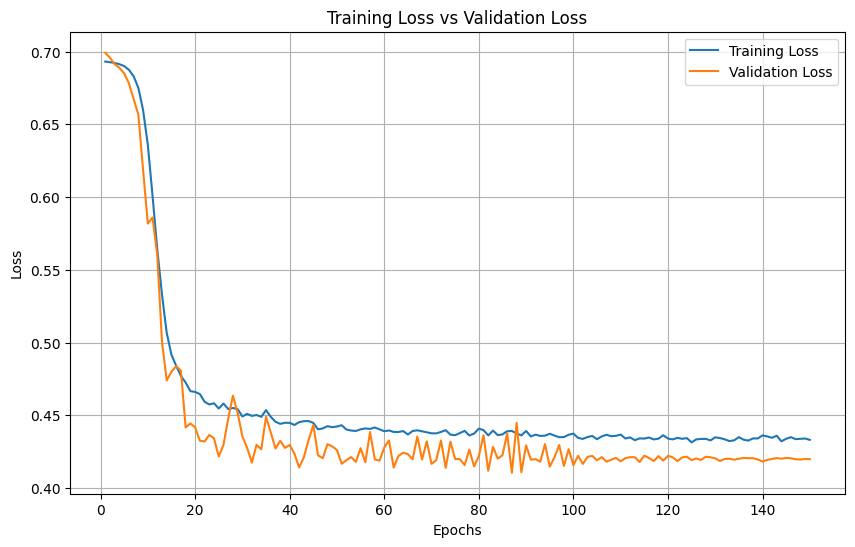

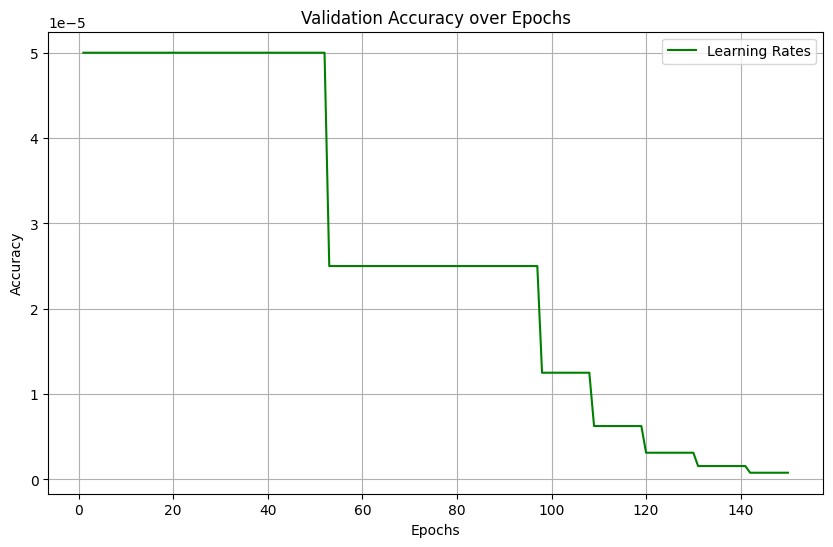

Model for bin 20 saved to 3DCholesterolModels-5A/model_bin_20.pth
1925 is length of subset grid
Training on bin 21
Bin 21, Epoch 1/150, Train Loss: 0.6931, Validation Loss: 0.6840, Validation Accuracy: 0.7825, Grad Norm: 0.0180, LR: 0.000050
Bin 21, Epoch 11/150, Train Loss: 0.6151, Validation Loss: 0.5557, Validation Accuracy: 0.8537, Grad Norm: 1.0191, LR: 0.000050
Bin 21, Epoch 21/150, Train Loss: 0.4694, Validation Loss: 0.4369, Validation Accuracy: 0.8797, Grad Norm: 3.3134, LR: 0.000050
Bin 21, Epoch 31/150, Train Loss: 0.4518, Validation Loss: 0.4348, Validation Accuracy: 0.8785, Grad Norm: 1.5617, LR: 0.000050
Bin 21, Epoch 41/150, Train Loss: 0.4469, Validation Loss: 0.4341, Validation Accuracy: 0.8763, Grad Norm: 5.0935, LR: 0.000050
Bin 21, Epoch 51/150, Train Loss: 0.4429, Validation Loss: 0.4325, Validation Accuracy: 0.8757, Grad Norm: 0.9831, LR: 0.000025
Bin 21, Epoch 61/150, Train Loss: 0.4406, Validation Loss: 0.4235, Validation Accuracy: 0.8864, Grad Norm: 2.8067, LR:

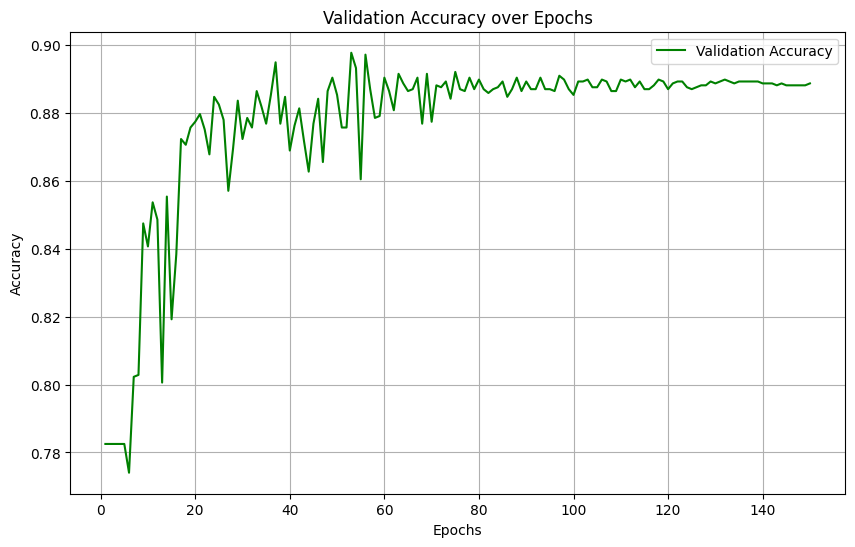

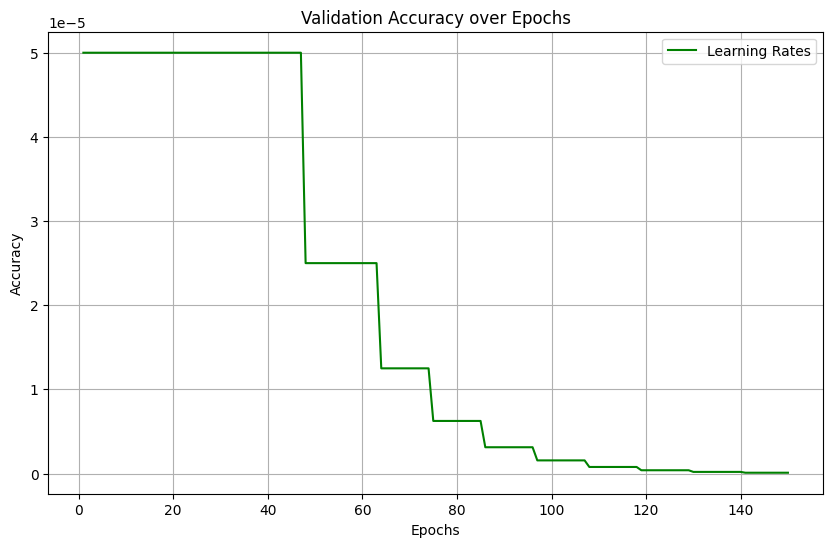

Model for bin 21 saved to 3DCholesterolModels-5A/model_bin_21.pth
1925 is length of subset grid
Training on bin 22
Bin 22, Epoch 1/150, Train Loss: 0.6931, Validation Loss: 0.6956, Validation Accuracy: 0.2175, Grad Norm: 0.0251, LR: 0.000050
Bin 22, Epoch 11/150, Train Loss: 0.6157, Validation Loss: 0.5673, Validation Accuracy: 0.8520, Grad Norm: 3.0004, LR: 0.000050
Bin 22, Epoch 21/150, Train Loss: 0.4647, Validation Loss: 0.4590, Validation Accuracy: 0.8542, Grad Norm: 1.3971, LR: 0.000050
Bin 22, Epoch 31/150, Train Loss: 0.4521, Validation Loss: 0.4485, Validation Accuracy: 0.8621, Grad Norm: 1.9108, LR: 0.000050
Bin 22, Epoch 41/150, Train Loss: 0.4445, Validation Loss: 0.4312, Validation Accuracy: 0.8814, Grad Norm: 0.2691, LR: 0.000025
Bin 22, Epoch 51/150, Train Loss: 0.4425, Validation Loss: 0.4284, Validation Accuracy: 0.8819, Grad Norm: 2.7965, LR: 0.000025
Bin 22, Epoch 61/150, Train Loss: 0.4419, Validation Loss: 0.4328, Validation Accuracy: 0.8740, Grad Norm: 2.7110, LR:

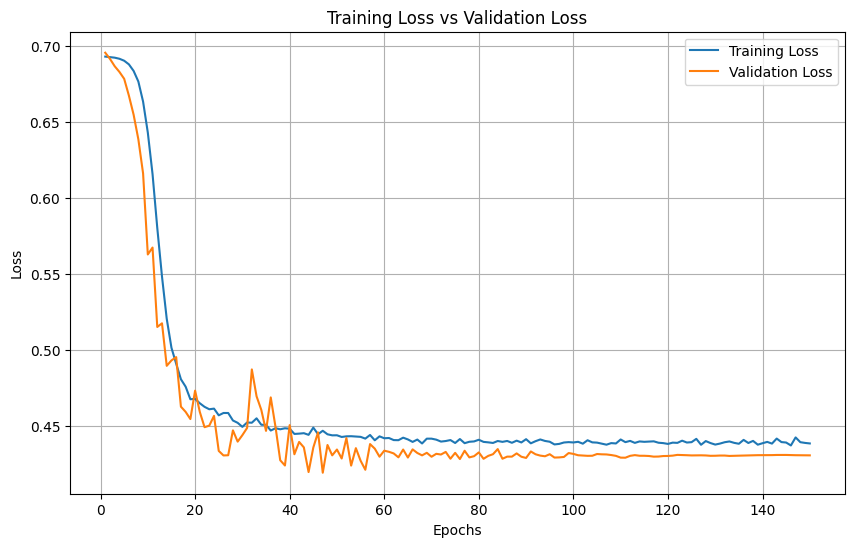

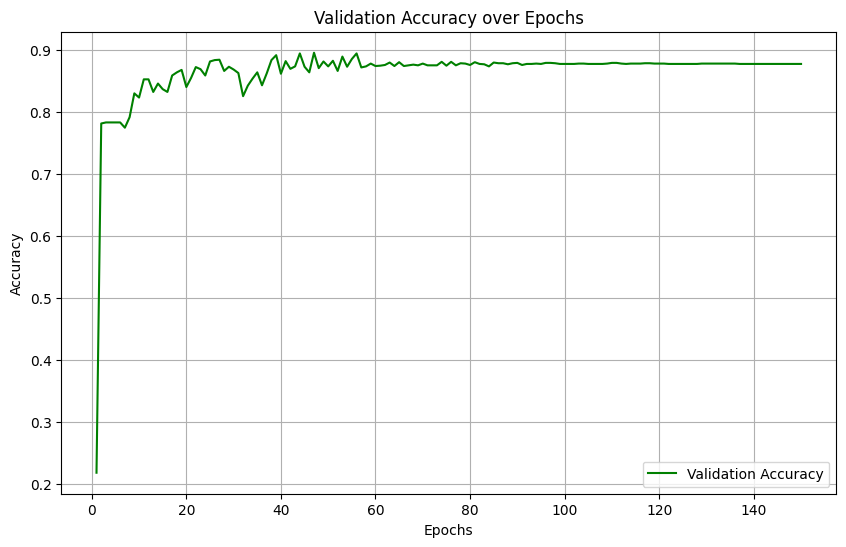

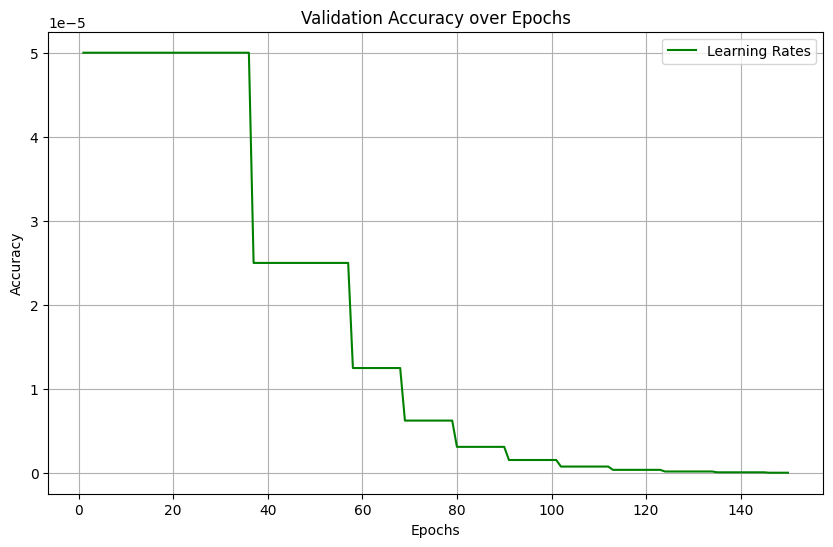

Model for bin 22 saved to 3DCholesterolModels-5A/model_bin_22.pth
1925 is length of subset grid
Training on bin 23
Bin 23, Epoch 1/150, Train Loss: 0.6931, Validation Loss: 0.6972, Validation Accuracy: 0.2175, Grad Norm: 0.0630, LR: 0.000050
Bin 23, Epoch 11/150, Train Loss: 0.6001, Validation Loss: 0.5322, Validation Accuracy: 0.8582, Grad Norm: 1.3005, LR: 0.000050
Bin 23, Epoch 21/150, Train Loss: 0.4644, Validation Loss: 0.4342, Validation Accuracy: 0.8802, Grad Norm: 4.4027, LR: 0.000050
Bin 23, Epoch 31/150, Train Loss: 0.4497, Validation Loss: 0.4358, Validation Accuracy: 0.8763, Grad Norm: 6.6644, LR: 0.000050
Bin 23, Epoch 41/150, Train Loss: 0.4441, Validation Loss: 0.4410, Validation Accuracy: 0.8701, Grad Norm: 1.1183, LR: 0.000050
Bin 23, Epoch 51/150, Train Loss: 0.4429, Validation Loss: 0.4219, Validation Accuracy: 0.8904, Grad Norm: 1.3581, LR: 0.000025
Bin 23, Epoch 61/150, Train Loss: 0.4399, Validation Loss: 0.4267, Validation Accuracy: 0.8814, Grad Norm: 1.3083, LR:

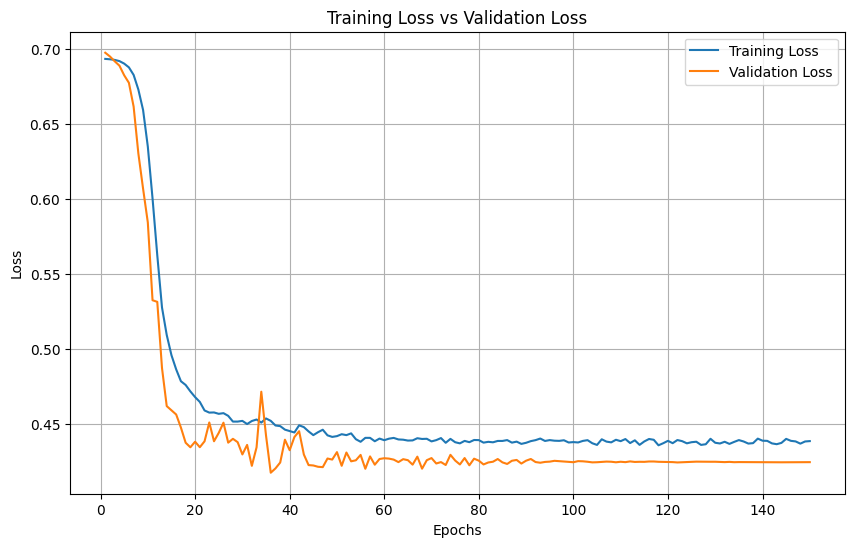

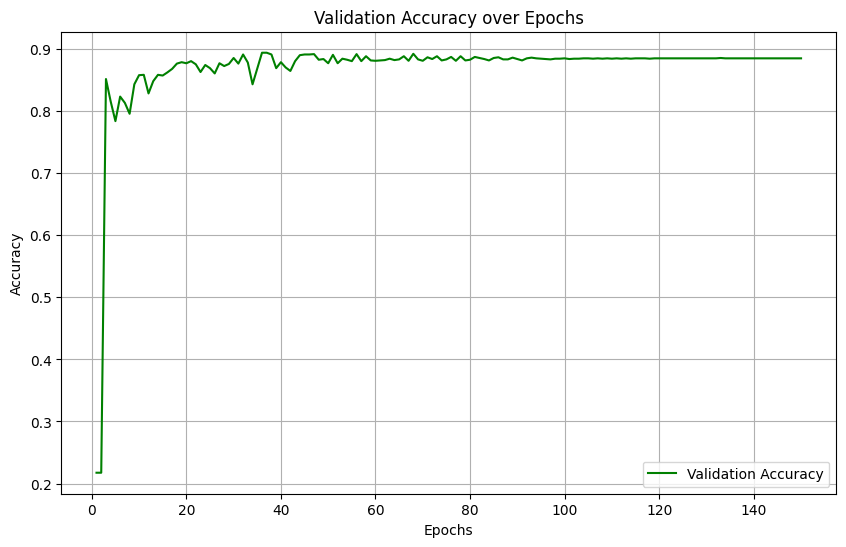

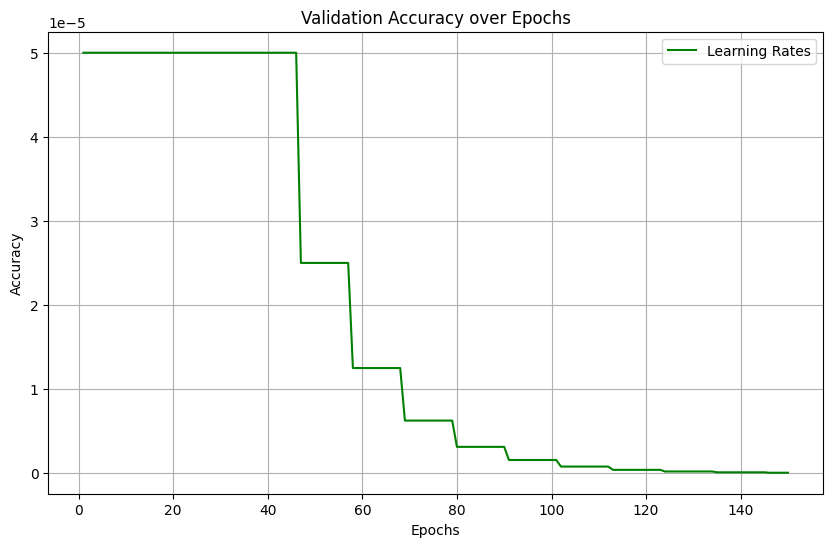

Model for bin 23 saved to 3DCholesterolModels-5A/model_bin_23.pth
1925 is length of subset grid
Training on bin 24
Bin 24, Epoch 1/150, Train Loss: 0.6932, Validation Loss: 0.6809, Validation Accuracy: 0.7825, Grad Norm: 0.0351, LR: 0.000050
Bin 24, Epoch 11/150, Train Loss: 0.5619, Validation Loss: 0.5167, Validation Accuracy: 0.8441, Grad Norm: 0.8926, LR: 0.000050
Bin 24, Epoch 21/150, Train Loss: 0.4577, Validation Loss: 0.4323, Validation Accuracy: 0.8842, Grad Norm: 0.7577, LR: 0.000050
Bin 24, Epoch 31/150, Train Loss: 0.4527, Validation Loss: 0.4324, Validation Accuracy: 0.8785, Grad Norm: 2.4030, LR: 0.000050
Bin 24, Epoch 41/150, Train Loss: 0.4455, Validation Loss: 0.4288, Validation Accuracy: 0.8836, Grad Norm: 0.7198, LR: 0.000025
Bin 24, Epoch 51/150, Train Loss: 0.4443, Validation Loss: 0.4267, Validation Accuracy: 0.8842, Grad Norm: 0.3403, LR: 0.000025
Bin 24, Epoch 61/150, Train Loss: 0.4425, Validation Loss: 0.4203, Validation Accuracy: 0.8927, Grad Norm: 0.3116, LR:

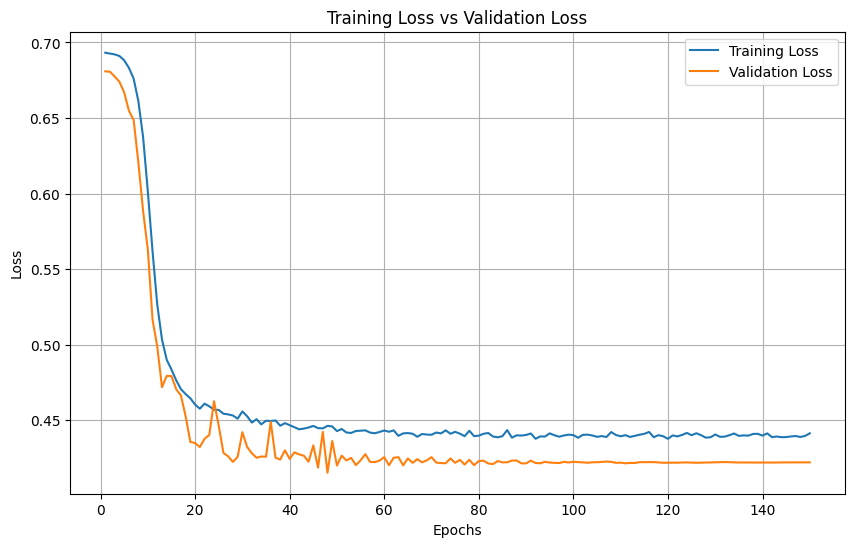

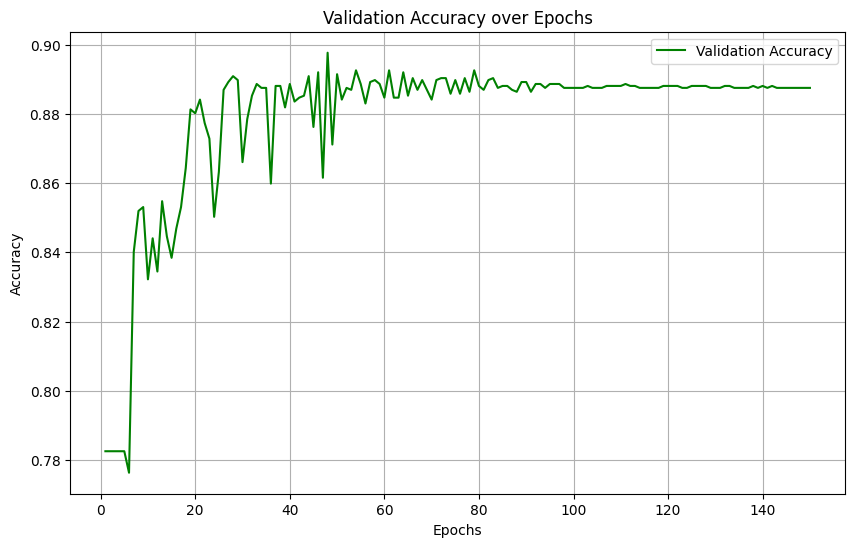

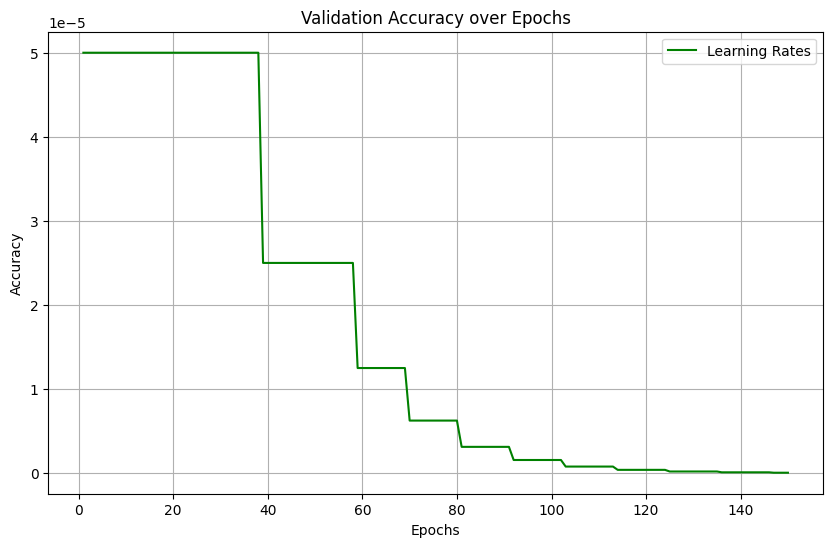

Model for bin 24 saved to 3DCholesterolModels-5A/model_bin_24.pth
1925 is length of subset grid
Training on bin 25
Bin 25, Epoch 1/150, Train Loss: 0.6930, Validation Loss: 0.6997, Validation Accuracy: 0.2175, Grad Norm: 0.1442, LR: 0.000050
Bin 25, Epoch 11/150, Train Loss: 0.6119, Validation Loss: 0.5495, Validation Accuracy: 0.8492, Grad Norm: 1.8730, LR: 0.000050
Bin 25, Epoch 21/150, Train Loss: 0.4687, Validation Loss: 0.4489, Validation Accuracy: 0.8684, Grad Norm: 2.7657, LR: 0.000050
Bin 25, Epoch 31/150, Train Loss: 0.4561, Validation Loss: 0.4417, Validation Accuracy: 0.8661, Grad Norm: 2.0695, LR: 0.000050
Bin 25, Epoch 41/150, Train Loss: 0.4507, Validation Loss: 0.4444, Validation Accuracy: 0.8661, Grad Norm: 1.2211, LR: 0.000050
Bin 25, Epoch 51/150, Train Loss: 0.4461, Validation Loss: 0.4135, Validation Accuracy: 0.9000, Grad Norm: 6.4802, LR: 0.000050
Bin 25, Epoch 61/150, Train Loss: 0.4432, Validation Loss: 0.4179, Validation Accuracy: 0.8944, Grad Norm: 6.4236, LR:

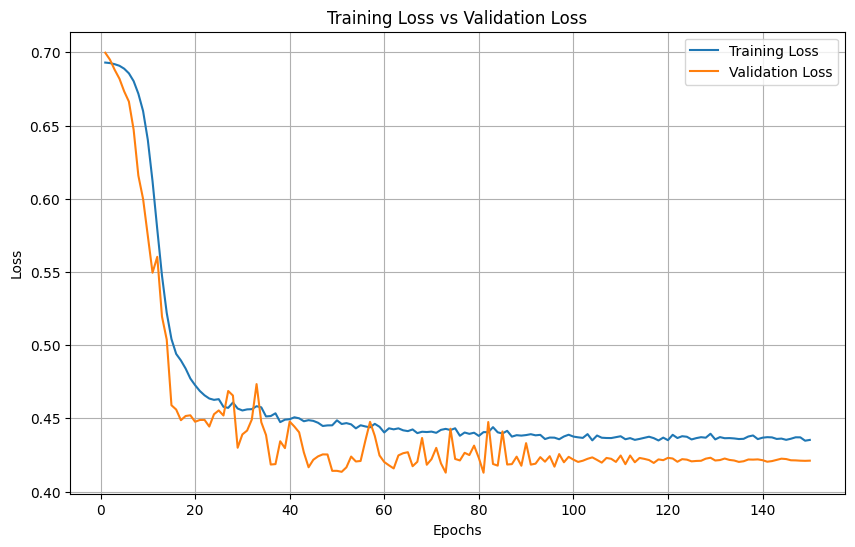

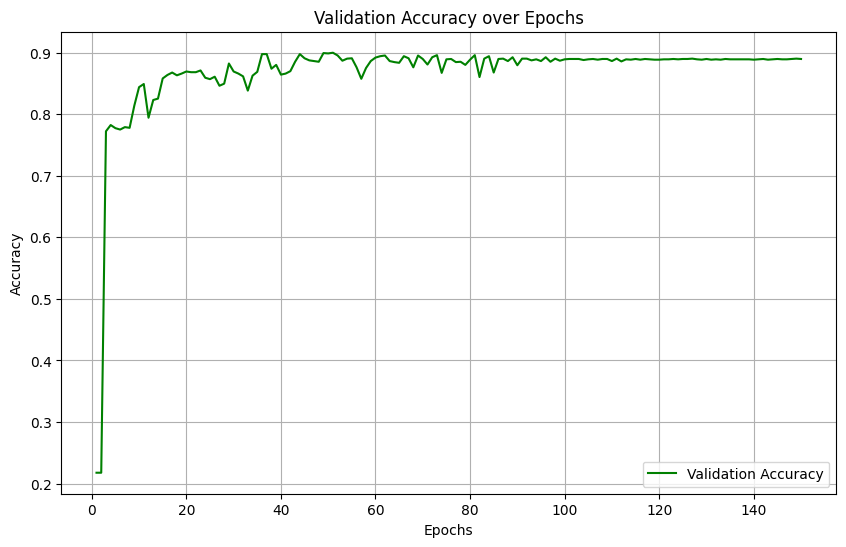

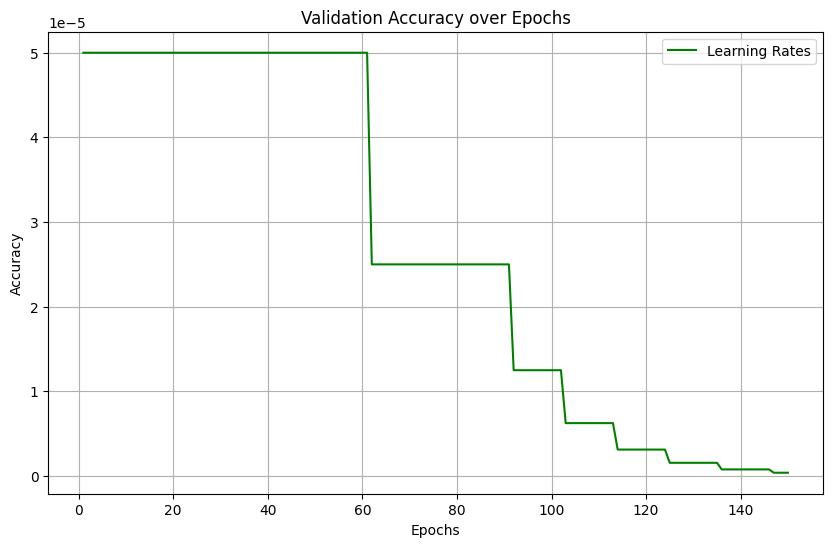

Model for bin 25 saved to 3DCholesterolModels-5A/model_bin_25.pth
1925 is length of subset grid
Training on bin 26
Bin 26, Epoch 1/150, Train Loss: 0.6930, Validation Loss: 0.6837, Validation Accuracy: 0.7825, Grad Norm: 0.1071, LR: 0.000050
Bin 26, Epoch 11/150, Train Loss: 0.5720, Validation Loss: 0.5400, Validation Accuracy: 0.8271, Grad Norm: 1.3963, LR: 0.000050
Bin 26, Epoch 21/150, Train Loss: 0.4676, Validation Loss: 0.5008, Validation Accuracy: 0.8147, Grad Norm: 5.7065, LR: 0.000050
Bin 26, Epoch 31/150, Train Loss: 0.4542, Validation Loss: 0.4325, Validation Accuracy: 0.8768, Grad Norm: 5.4788, LR: 0.000050
Bin 26, Epoch 41/150, Train Loss: 0.4481, Validation Loss: 0.4437, Validation Accuracy: 0.8672, Grad Norm: 4.5039, LR: 0.000025
Bin 26, Epoch 51/150, Train Loss: 0.4442, Validation Loss: 0.4304, Validation Accuracy: 0.8785, Grad Norm: 2.1175, LR: 0.000025
Bin 26, Epoch 61/150, Train Loss: 0.4430, Validation Loss: 0.4294, Validation Accuracy: 0.8797, Grad Norm: 1.9982, LR:

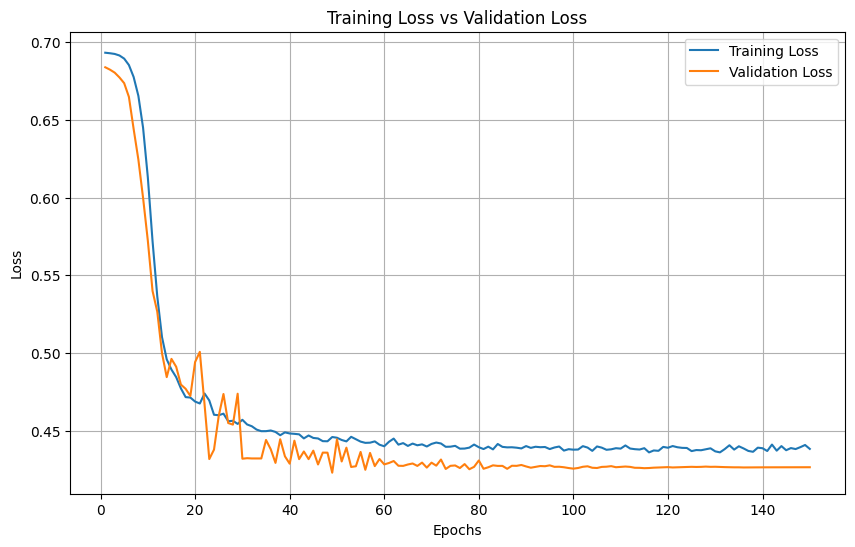

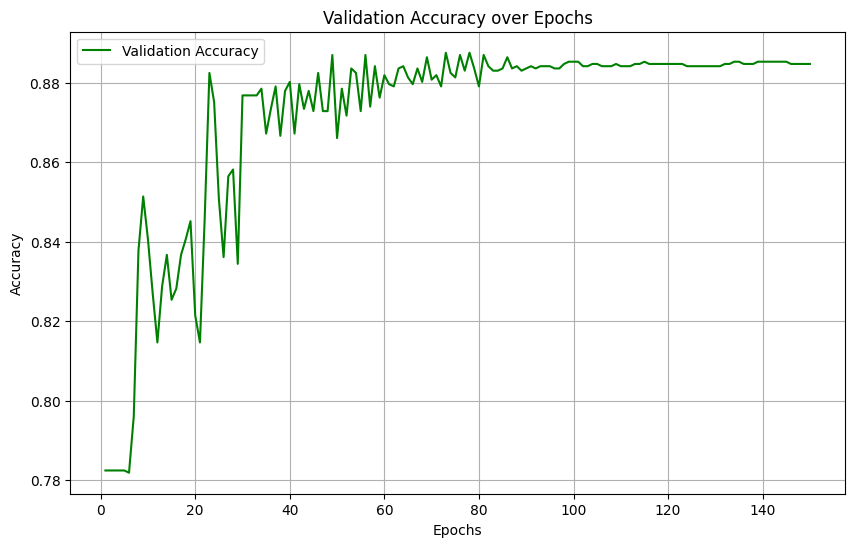

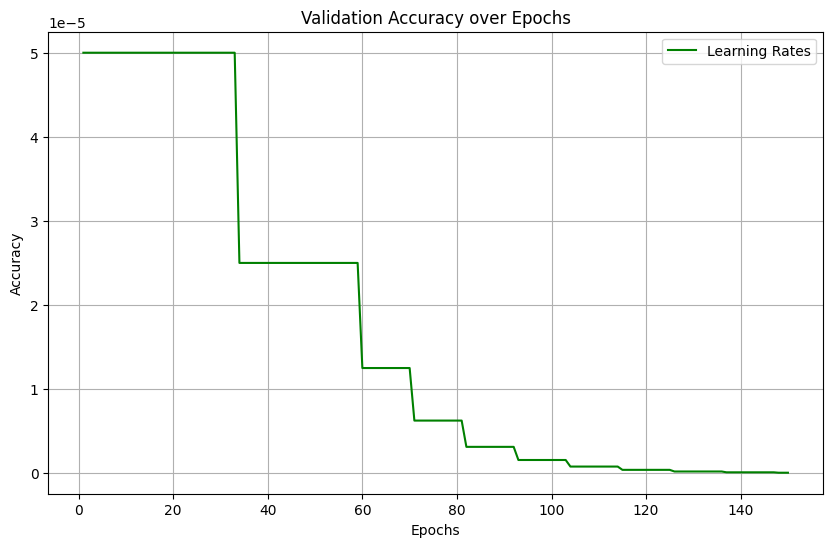

Model for bin 26 saved to 3DCholesterolModels-5A/model_bin_26.pth
1925 is length of subset grid
Training on bin 27
Bin 27, Epoch 1/150, Train Loss: 0.6933, Validation Loss: 0.6788, Validation Accuracy: 0.7825, Grad Norm: 0.0205, LR: 0.000050
Bin 27, Epoch 11/150, Train Loss: 0.5868, Validation Loss: 0.4954, Validation Accuracy: 0.8446, Grad Norm: 2.7660, LR: 0.000050
Bin 27, Epoch 21/150, Train Loss: 0.4680, Validation Loss: 0.4517, Validation Accuracy: 0.8678, Grad Norm: 2.3514, LR: 0.000050
Bin 27, Epoch 31/150, Train Loss: 0.4517, Validation Loss: 0.4442, Validation Accuracy: 0.8712, Grad Norm: 1.1599, LR: 0.000050
Bin 27, Epoch 41/150, Train Loss: 0.4441, Validation Loss: 0.4233, Validation Accuracy: 0.8927, Grad Norm: 6.3215, LR: 0.000050
Bin 27, Epoch 51/150, Train Loss: 0.4398, Validation Loss: 0.4181, Validation Accuracy: 0.8938, Grad Norm: 0.5151, LR: 0.000050
Bin 27, Epoch 61/150, Train Loss: 0.4355, Validation Loss: 0.4233, Validation Accuracy: 0.8881, Grad Norm: 5.2221, LR:

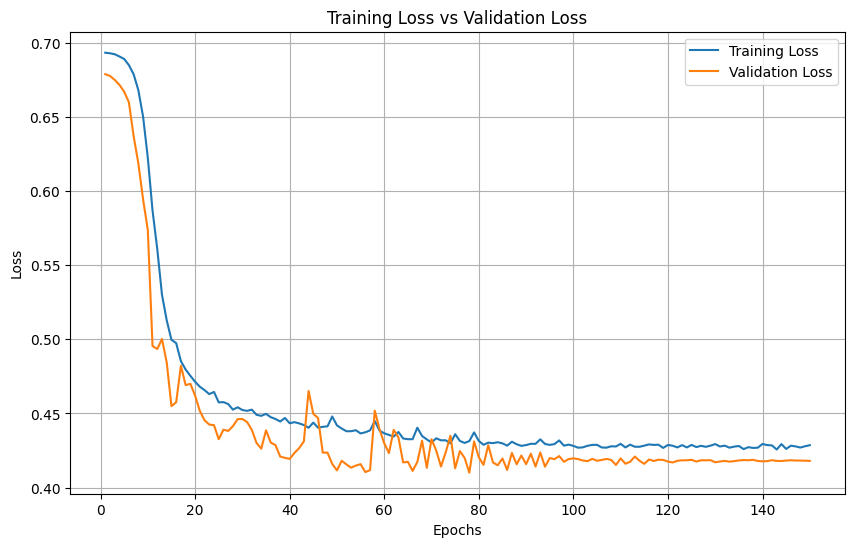

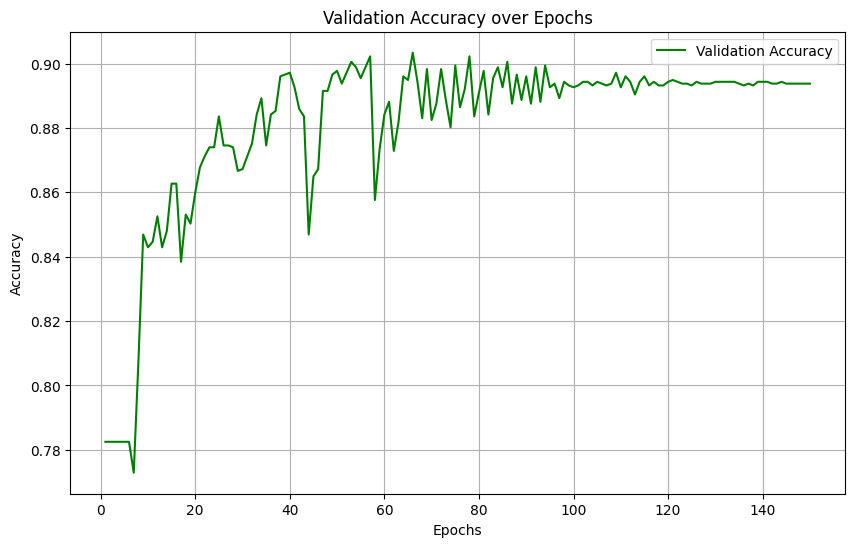

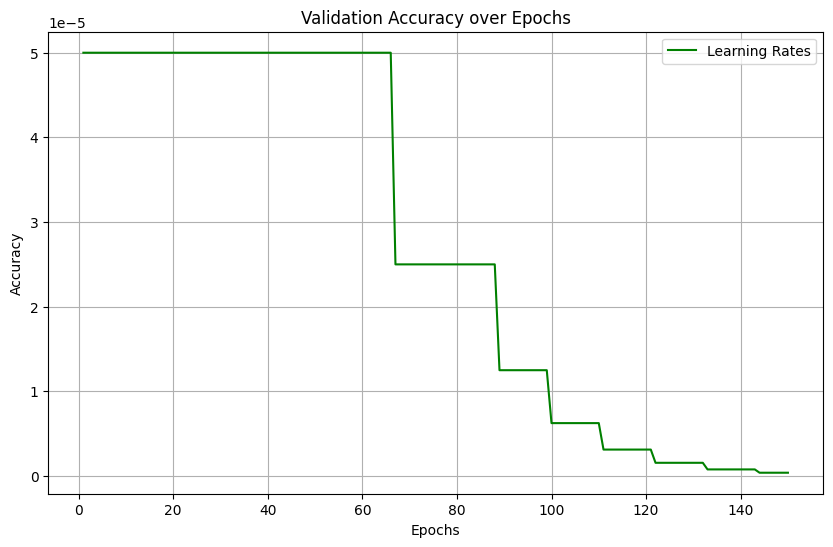

Model for bin 27 saved to 3DCholesterolModels-5A/model_bin_27.pth
1925 is length of subset grid
Training on bin 28
Bin 28, Epoch 1/150, Train Loss: 0.6931, Validation Loss: 0.6912, Validation Accuracy: 0.7825, Grad Norm: 0.0355, LR: 0.000050
Bin 28, Epoch 11/150, Train Loss: 0.6354, Validation Loss: 0.5544, Validation Accuracy: 0.8299, Grad Norm: 1.1847, LR: 0.000050
Bin 28, Epoch 21/150, Train Loss: 0.4813, Validation Loss: 0.4769, Validation Accuracy: 0.8412, Grad Norm: 5.2243, LR: 0.000050
Bin 28, Epoch 31/150, Train Loss: 0.4596, Validation Loss: 0.4368, Validation Accuracy: 0.8785, Grad Norm: 1.3683, LR: 0.000050
Bin 28, Epoch 41/150, Train Loss: 0.4509, Validation Loss: 0.4453, Validation Accuracy: 0.8684, Grad Norm: 4.4141, LR: 0.000025
Bin 28, Epoch 51/150, Train Loss: 0.4464, Validation Loss: 0.4305, Validation Accuracy: 0.8831, Grad Norm: 2.8446, LR: 0.000025
Bin 28, Epoch 61/150, Train Loss: 0.4452, Validation Loss: 0.4269, Validation Accuracy: 0.8864, Grad Norm: 2.8928, LR:

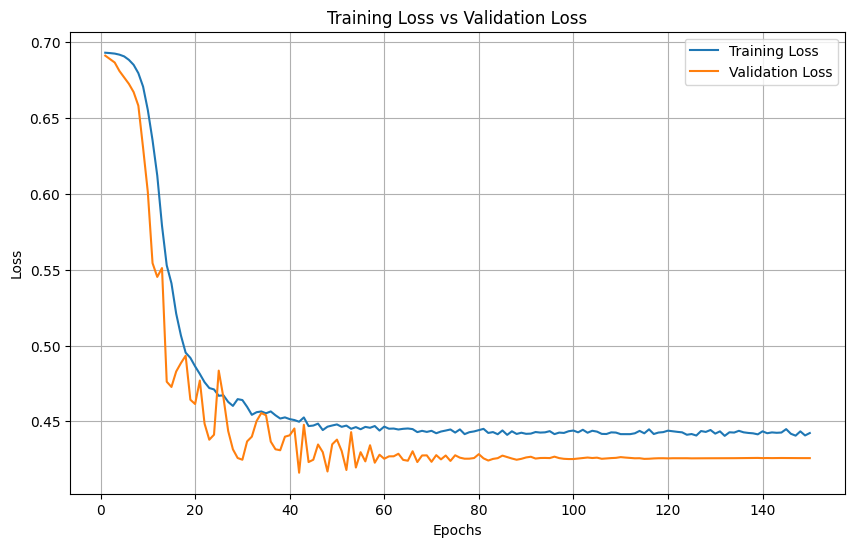

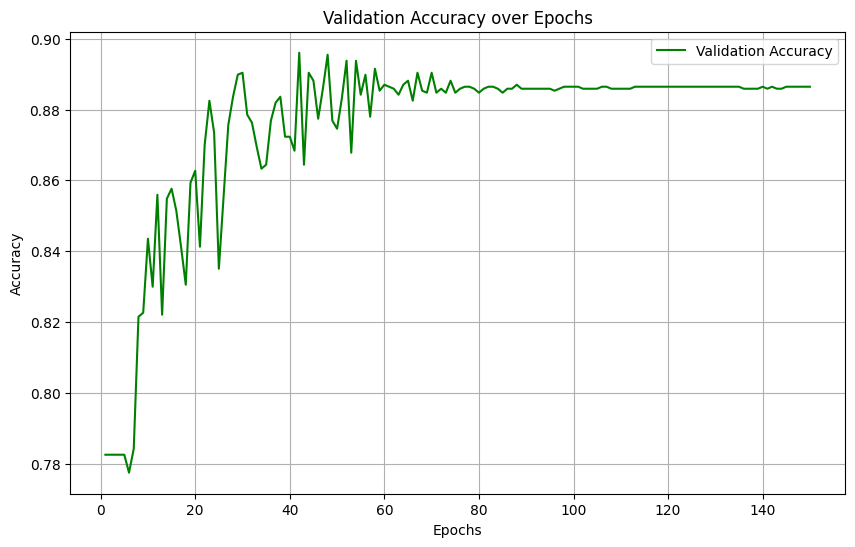

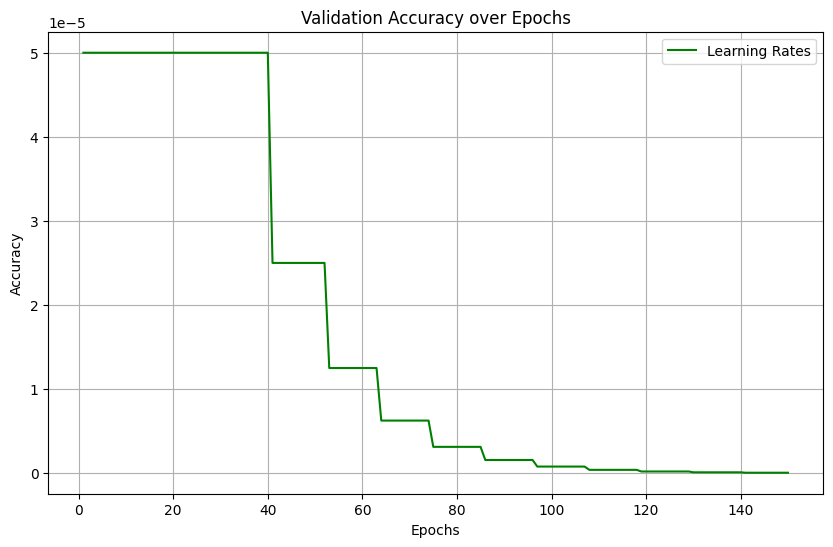

Model for bin 28 saved to 3DCholesterolModels-5A/model_bin_28.pth
1925 is length of subset grid
Training on bin 29
Bin 29, Epoch 1/150, Train Loss: 0.6929, Validation Loss: 0.6924, Validation Accuracy: 0.8362, Grad Norm: 0.0464, LR: 0.000050
Bin 29, Epoch 11/150, Train Loss: 0.5821, Validation Loss: 0.5639, Validation Accuracy: 0.8062, Grad Norm: 0.8990, LR: 0.000050
Bin 29, Epoch 21/150, Train Loss: 0.4659, Validation Loss: 0.4405, Validation Accuracy: 0.8780, Grad Norm: 2.3112, LR: 0.000050
Bin 29, Epoch 31/150, Train Loss: 0.4525, Validation Loss: 0.4705, Validation Accuracy: 0.8424, Grad Norm: 0.2065, LR: 0.000050
Bin 29, Epoch 41/150, Train Loss: 0.4507, Validation Loss: 0.4357, Validation Accuracy: 0.8746, Grad Norm: 3.5376, LR: 0.000025
Bin 29, Epoch 51/150, Train Loss: 0.4461, Validation Loss: 0.4462, Validation Accuracy: 0.8633, Grad Norm: 2.1313, LR: 0.000025
Bin 29, Epoch 61/150, Train Loss: 0.4430, Validation Loss: 0.4392, Validation Accuracy: 0.8734, Grad Norm: 0.7385, LR:

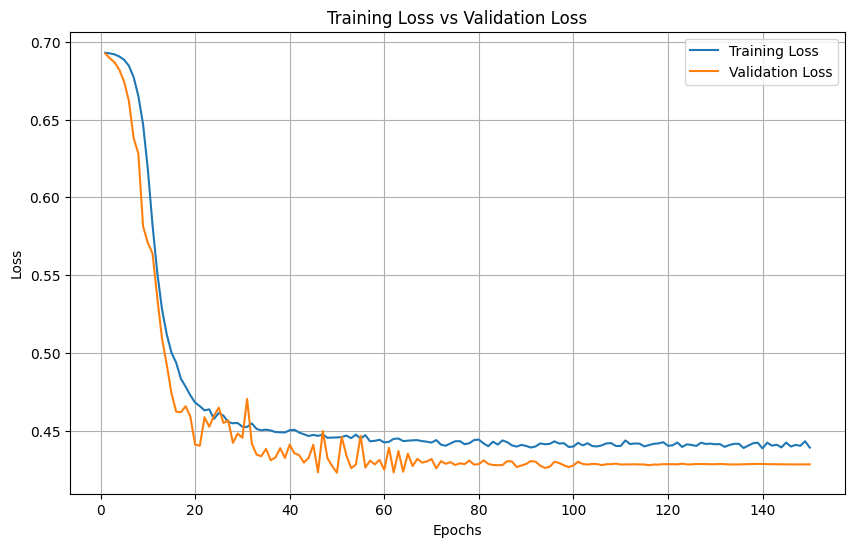

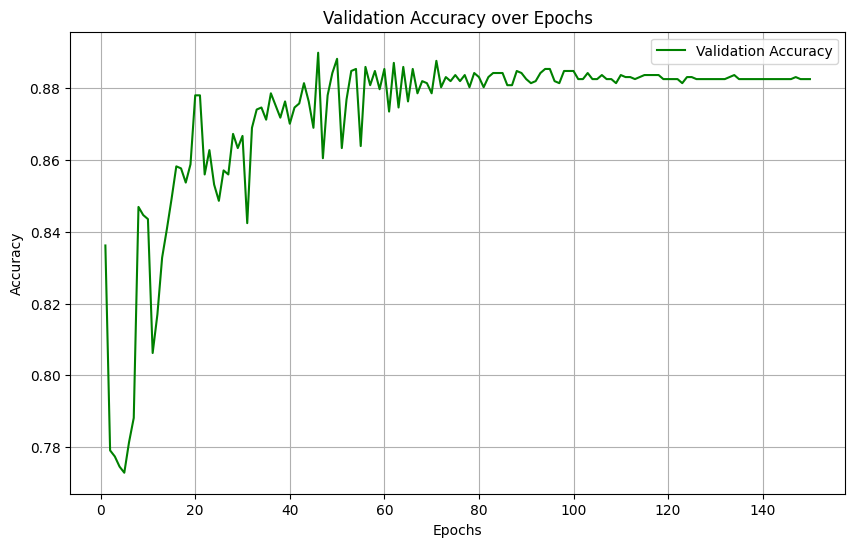

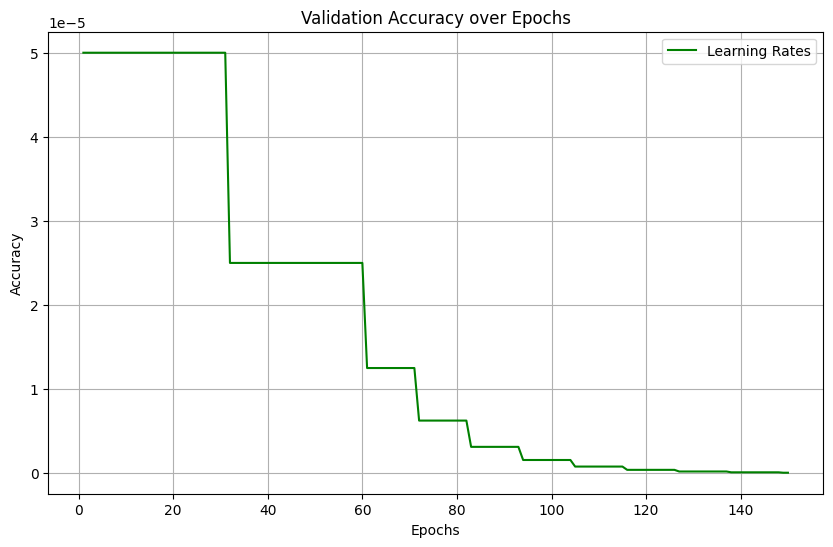

Model for bin 29 saved to 3DCholesterolModels-5A/model_bin_29.pth
1925 is length of subset grid
Training on bin 30
Bin 30, Epoch 1/150, Train Loss: 0.6930, Validation Loss: 0.6850, Validation Accuracy: 0.7825, Grad Norm: 0.0215, LR: 0.000050
Bin 30, Epoch 11/150, Train Loss: 0.5831, Validation Loss: 0.5449, Validation Accuracy: 0.8288, Grad Norm: 3.6527, LR: 0.000050
Bin 30, Epoch 21/150, Train Loss: 0.4679, Validation Loss: 0.4409, Validation Accuracy: 0.8785, Grad Norm: 2.7701, LR: 0.000050
Bin 30, Epoch 31/150, Train Loss: 0.4554, Validation Loss: 0.4537, Validation Accuracy: 0.8633, Grad Norm: 1.9771, LR: 0.000050
Bin 30, Epoch 41/150, Train Loss: 0.4494, Validation Loss: 0.4277, Validation Accuracy: 0.8864, Grad Norm: 0.6694, LR: 0.000025
Bin 30, Epoch 51/150, Train Loss: 0.4491, Validation Loss: 0.4360, Validation Accuracy: 0.8763, Grad Norm: 6.4782, LR: 0.000025
Bin 30, Epoch 61/150, Train Loss: 0.4454, Validation Loss: 0.4314, Validation Accuracy: 0.8814, Grad Norm: 1.8069, LR:

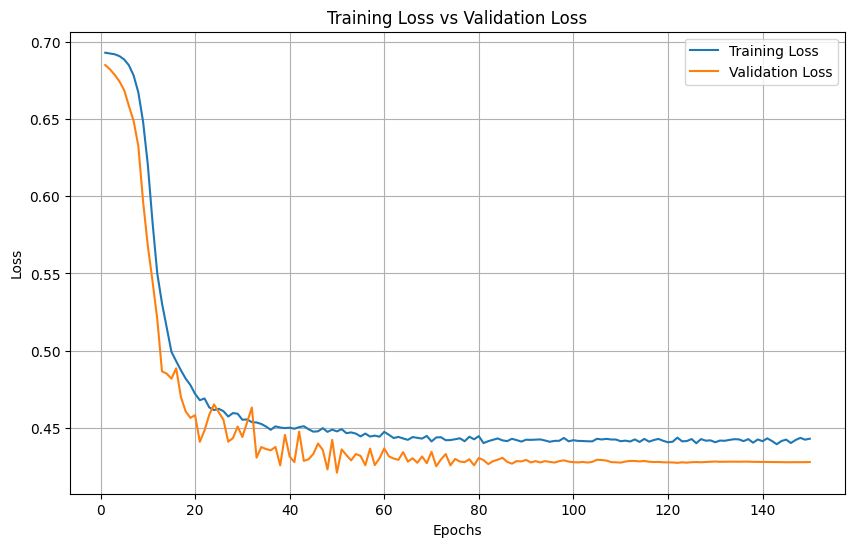

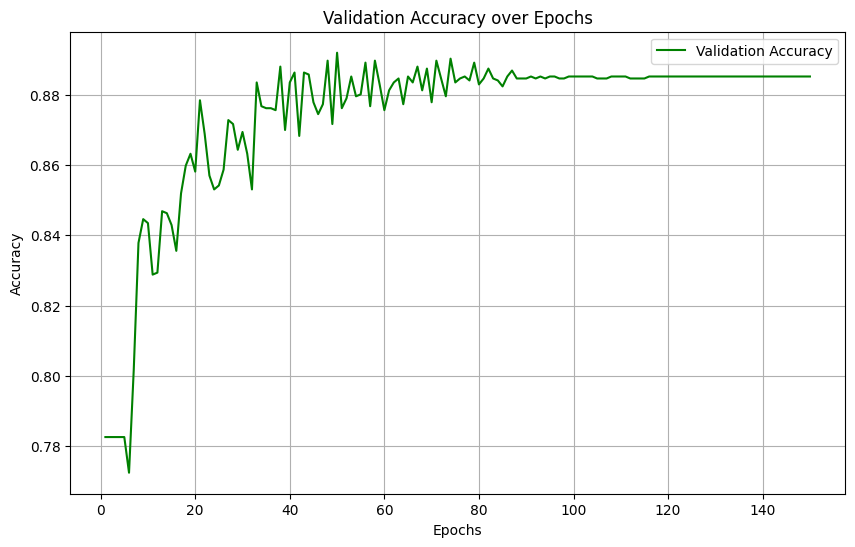

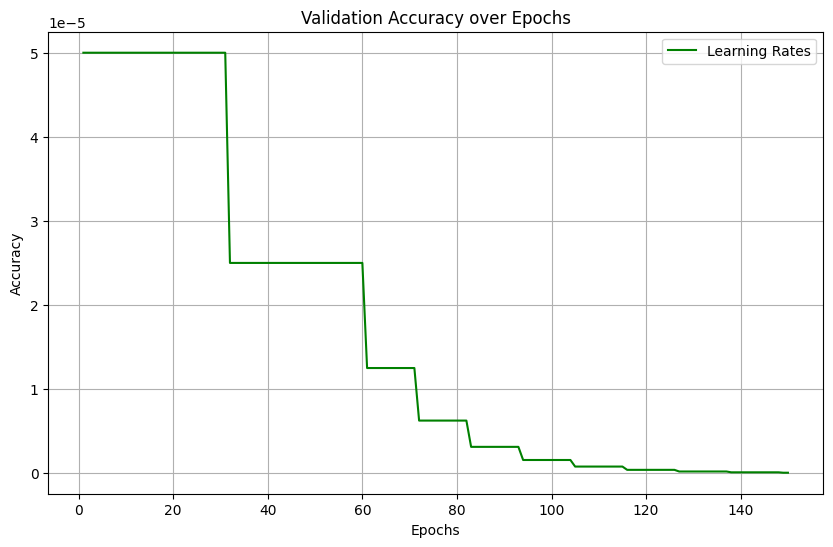

Model for bin 30 saved to 3DCholesterolModels-5A/model_bin_30.pth
1925 is length of subset grid
Training on bin 31
Bin 31, Epoch 1/150, Train Loss: 0.6937, Validation Loss: 0.7086, Validation Accuracy: 0.2175, Grad Norm: 0.0805, LR: 0.000050
Bin 31, Epoch 11/150, Train Loss: 0.6373, Validation Loss: 0.5763, Validation Accuracy: 0.8588, Grad Norm: 0.6199, LR: 0.000050
Bin 31, Epoch 21/150, Train Loss: 0.4681, Validation Loss: 0.4415, Validation Accuracy: 0.8740, Grad Norm: 1.2382, LR: 0.000050
Bin 31, Epoch 31/150, Train Loss: 0.4606, Validation Loss: 0.4246, Validation Accuracy: 0.8898, Grad Norm: 5.0796, LR: 0.000050
Bin 31, Epoch 41/150, Train Loss: 0.4474, Validation Loss: 0.4150, Validation Accuracy: 0.8977, Grad Norm: 2.3335, LR: 0.000050
Bin 31, Epoch 51/150, Train Loss: 0.4467, Validation Loss: 0.4604, Validation Accuracy: 0.8531, Grad Norm: 1.8569, LR: 0.000050
Bin 31, Epoch 61/150, Train Loss: 0.4459, Validation Loss: 0.4316, Validation Accuracy: 0.8774, Grad Norm: 2.9240, LR:

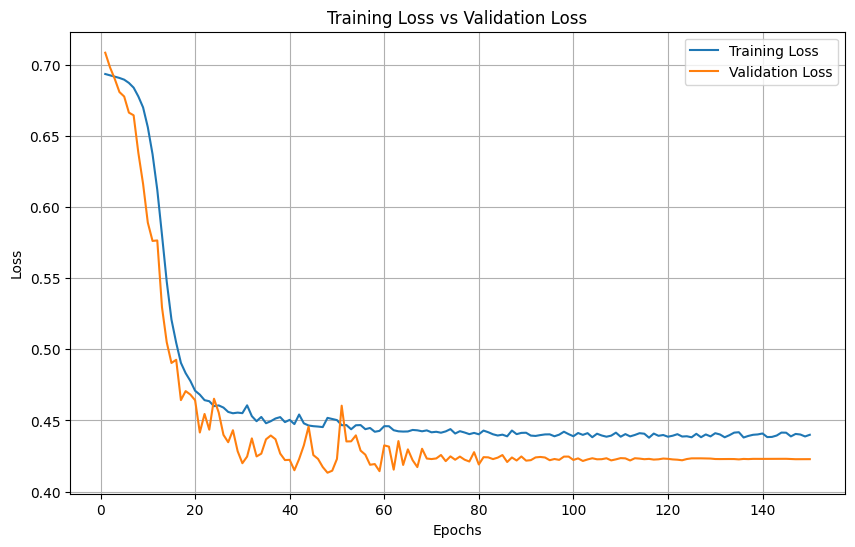

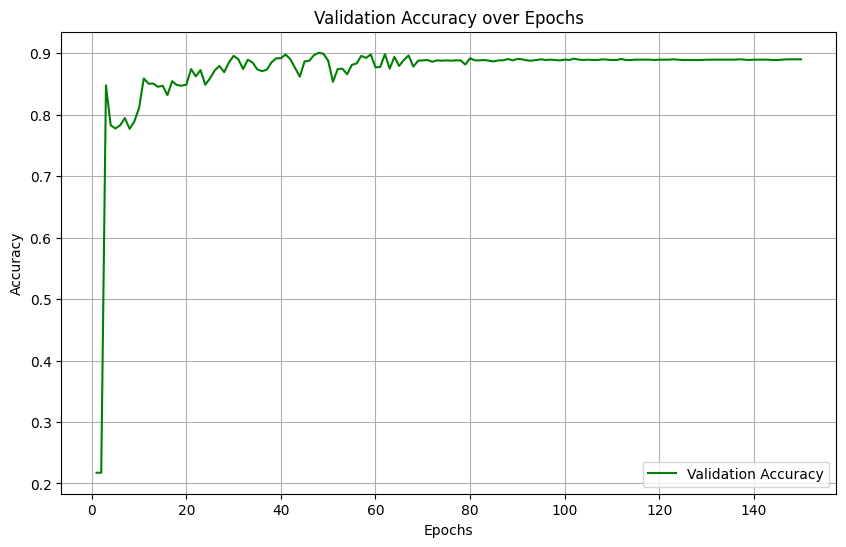

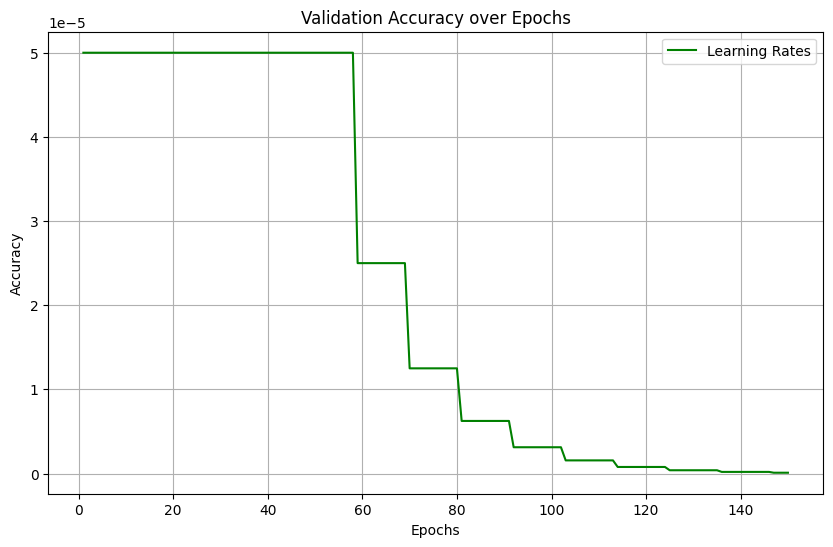

Model for bin 31 saved to 3DCholesterolModels-5A/model_bin_31.pth
1925 is length of subset grid
Training on bin 32
Bin 32, Epoch 1/150, Train Loss: 0.6930, Validation Loss: 0.6912, Validation Accuracy: 0.7825, Grad Norm: 0.0620, LR: 0.000050
Bin 32, Epoch 11/150, Train Loss: 0.6037, Validation Loss: 0.5883, Validation Accuracy: 0.7910, Grad Norm: 5.3894, LR: 0.000050
Bin 32, Epoch 21/150, Train Loss: 0.4890, Validation Loss: 0.4469, Validation Accuracy: 0.8678, Grad Norm: 0.5859, LR: 0.000050
Bin 32, Epoch 31/150, Train Loss: 0.4603, Validation Loss: 0.4456, Validation Accuracy: 0.8723, Grad Norm: 1.3245, LR: 0.000050
Bin 32, Epoch 41/150, Train Loss: 0.4571, Validation Loss: 0.4355, Validation Accuracy: 0.8780, Grad Norm: 5.9101, LR: 0.000050
Bin 32, Epoch 51/150, Train Loss: 0.4479, Validation Loss: 0.4299, Validation Accuracy: 0.8814, Grad Norm: 0.8674, LR: 0.000050
Bin 32, Epoch 61/150, Train Loss: 0.4429, Validation Loss: 0.4312, Validation Accuracy: 0.8797, Grad Norm: 1.6835, LR:

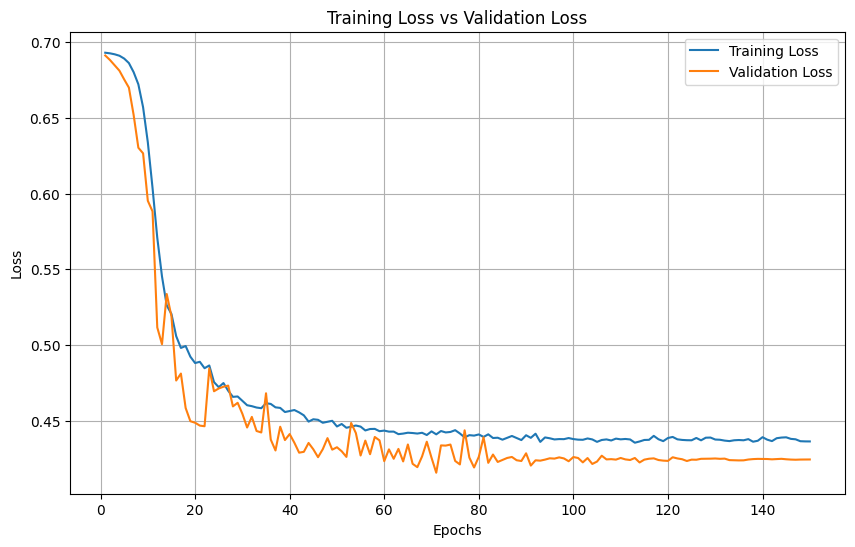

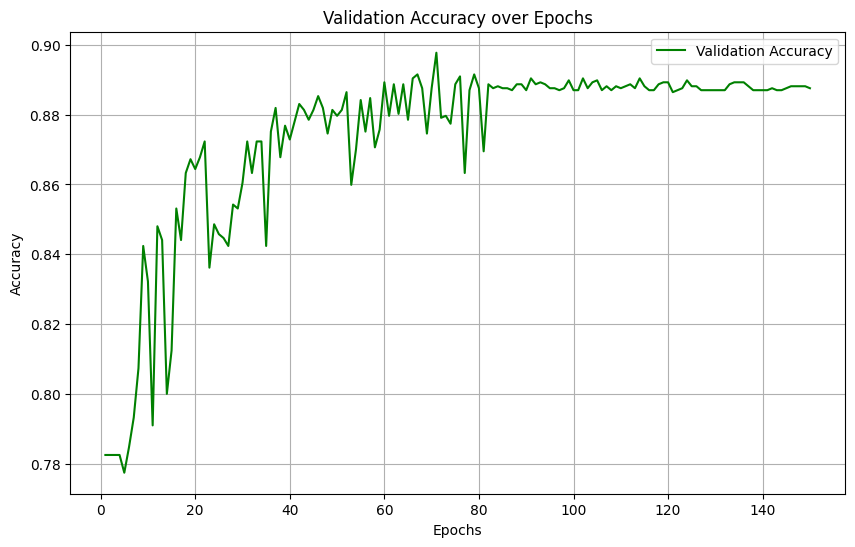

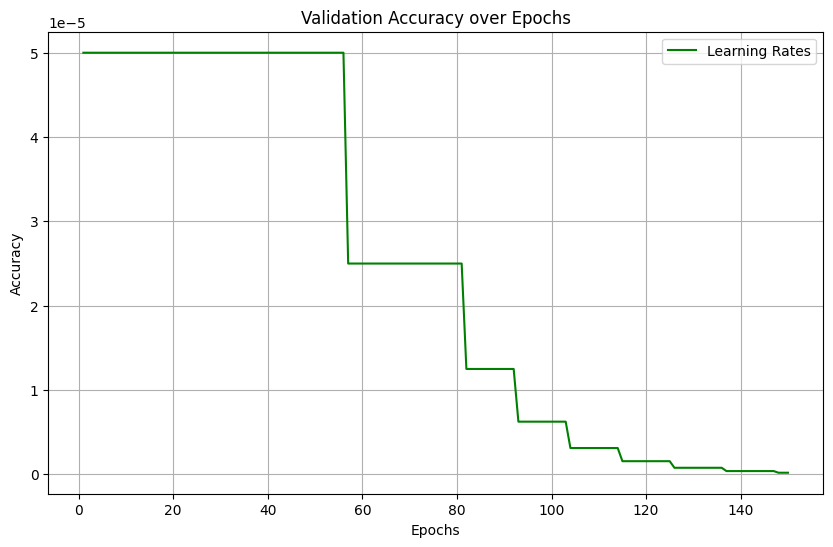

Model for bin 32 saved to 3DCholesterolModels-5A/model_bin_32.pth
1925 is length of subset grid
Training on bin 33
Bin 33, Epoch 1/150, Train Loss: 0.6934, Validation Loss: 0.6803, Validation Accuracy: 0.7825, Grad Norm: 0.0441, LR: 0.000050
Bin 33, Epoch 11/150, Train Loss: 0.6269, Validation Loss: 0.5973, Validation Accuracy: 0.8316, Grad Norm: 4.7718, LR: 0.000050
Bin 33, Epoch 21/150, Train Loss: 0.4814, Validation Loss: 0.4569, Validation Accuracy: 0.8610, Grad Norm: 0.4885, LR: 0.000050
Bin 33, Epoch 31/150, Train Loss: 0.4622, Validation Loss: 0.4297, Validation Accuracy: 0.8853, Grad Norm: 1.6439, LR: 0.000050
Bin 33, Epoch 41/150, Train Loss: 0.4511, Validation Loss: 0.4296, Validation Accuracy: 0.8780, Grad Norm: 0.6383, LR: 0.000025
Bin 33, Epoch 51/150, Train Loss: 0.4495, Validation Loss: 0.4206, Validation Accuracy: 0.8938, Grad Norm: 1.4116, LR: 0.000025
Bin 33, Epoch 61/150, Train Loss: 0.4445, Validation Loss: 0.4250, Validation Accuracy: 0.8842, Grad Norm: 3.9378, LR:

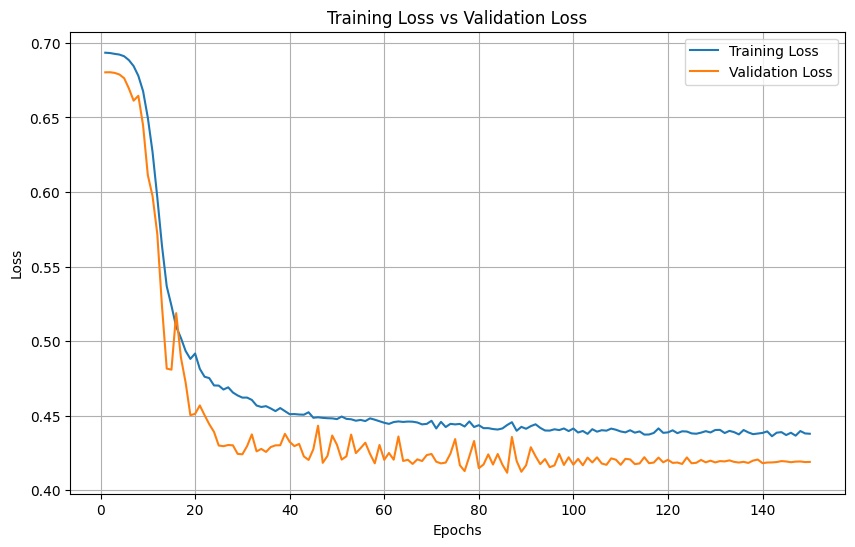

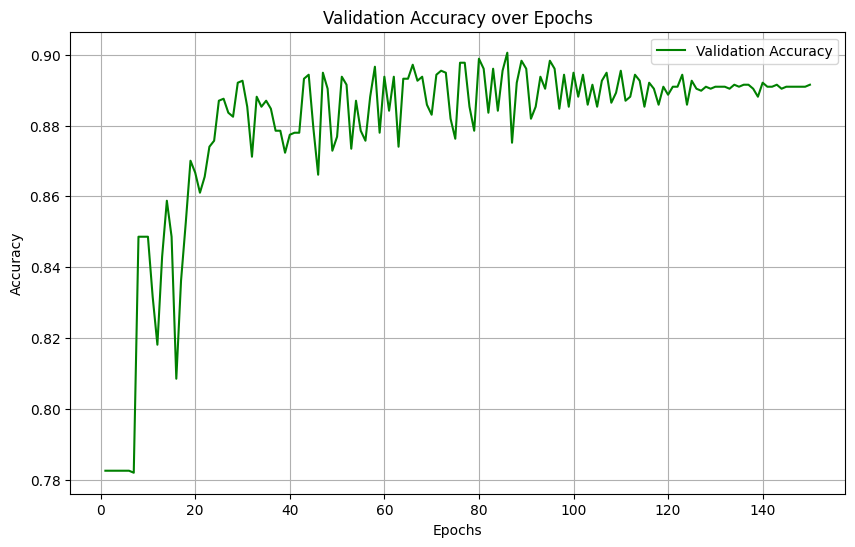

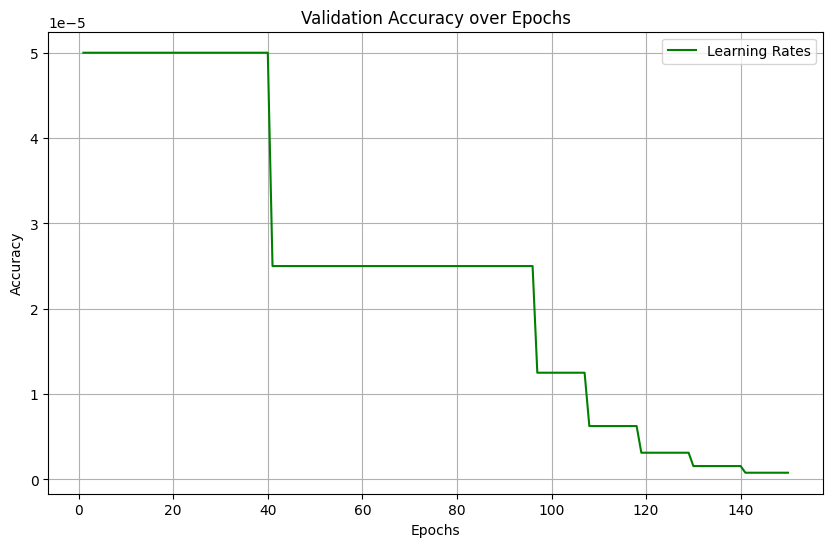

Model for bin 33 saved to 3DCholesterolModels-5A/model_bin_33.pth
1925 is length of subset grid
Training on bin 34
Bin 34, Epoch 1/150, Train Loss: 0.6929, Validation Loss: 0.6872, Validation Accuracy: 0.7825, Grad Norm: 0.0721, LR: 0.000050
Bin 34, Epoch 11/150, Train Loss: 0.5846, Validation Loss: 0.5166, Validation Accuracy: 0.8480, Grad Norm: 3.3103, LR: 0.000050
Bin 34, Epoch 21/150, Train Loss: 0.4772, Validation Loss: 0.4367, Validation Accuracy: 0.8797, Grad Norm: 5.0989, LR: 0.000050
Bin 34, Epoch 31/150, Train Loss: 0.4613, Validation Loss: 0.4332, Validation Accuracy: 0.8808, Grad Norm: 2.8517, LR: 0.000050
Bin 34, Epoch 41/150, Train Loss: 0.4590, Validation Loss: 0.4244, Validation Accuracy: 0.8881, Grad Norm: 6.3197, LR: 0.000025
Bin 34, Epoch 51/150, Train Loss: 0.4540, Validation Loss: 0.4205, Validation Accuracy: 0.8932, Grad Norm: 0.5073, LR: 0.000025
Bin 34, Epoch 61/150, Train Loss: 0.4501, Validation Loss: 0.4235, Validation Accuracy: 0.8893, Grad Norm: 2.0558, LR:

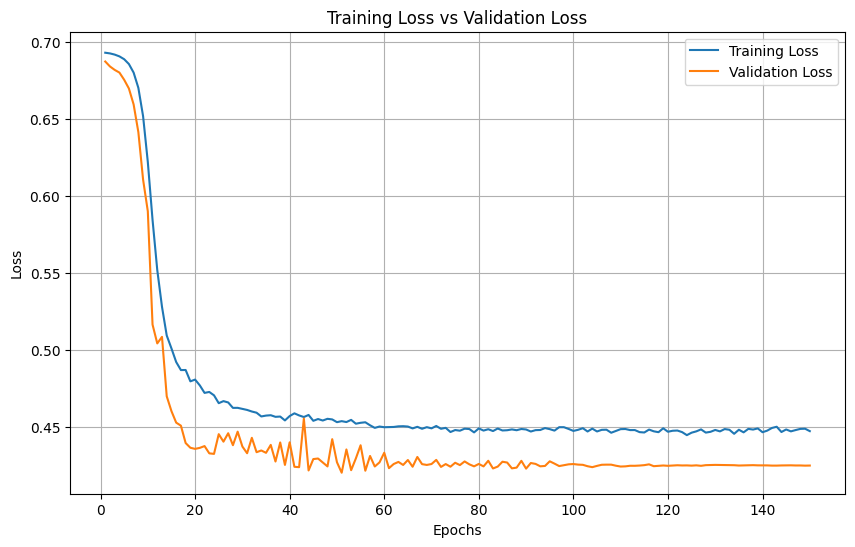

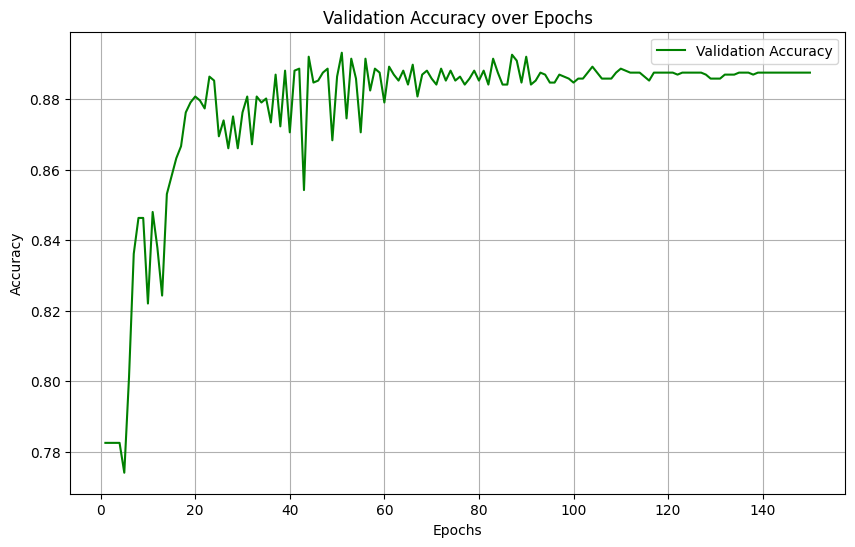

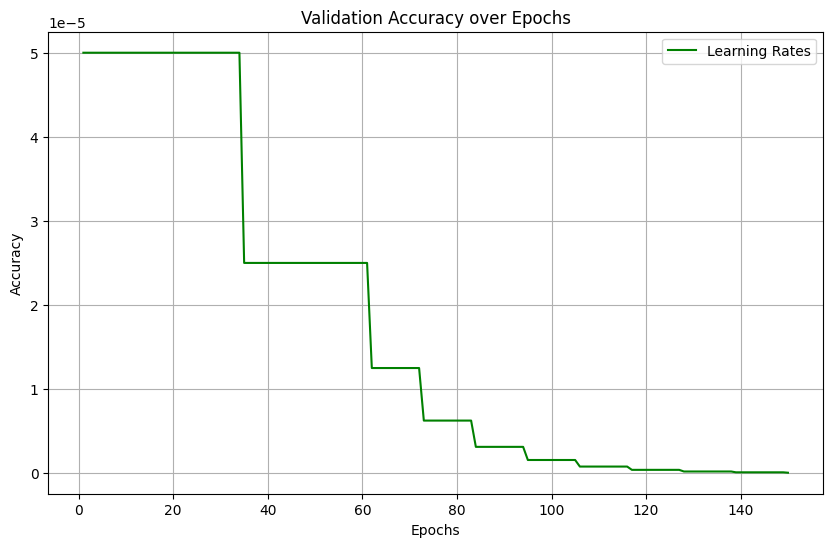

Model for bin 34 saved to 3DCholesterolModels-5A/model_bin_34.pth
1925 is length of subset grid
Training on bin 35
Bin 35, Epoch 1/150, Train Loss: 0.6931, Validation Loss: 0.6815, Validation Accuracy: 0.7825, Grad Norm: 0.0599, LR: 0.000050
Bin 35, Epoch 11/150, Train Loss: 0.5637, Validation Loss: 0.5217, Validation Accuracy: 0.8452, Grad Norm: 5.9057, LR: 0.000050
Bin 35, Epoch 21/150, Train Loss: 0.4618, Validation Loss: 0.4622, Validation Accuracy: 0.8554, Grad Norm: 1.5220, LR: 0.000050
Bin 35, Epoch 31/150, Train Loss: 0.4505, Validation Loss: 0.4223, Validation Accuracy: 0.8898, Grad Norm: 2.4785, LR: 0.000050
Bin 35, Epoch 41/150, Train Loss: 0.4448, Validation Loss: 0.4318, Validation Accuracy: 0.8791, Grad Norm: 0.5024, LR: 0.000050
Bin 35, Epoch 51/150, Train Loss: 0.4382, Validation Loss: 0.4255, Validation Accuracy: 0.8831, Grad Norm: 2.6280, LR: 0.000025
Bin 35, Epoch 61/150, Train Loss: 0.4402, Validation Loss: 0.4238, Validation Accuracy: 0.8859, Grad Norm: 6.2066, LR:

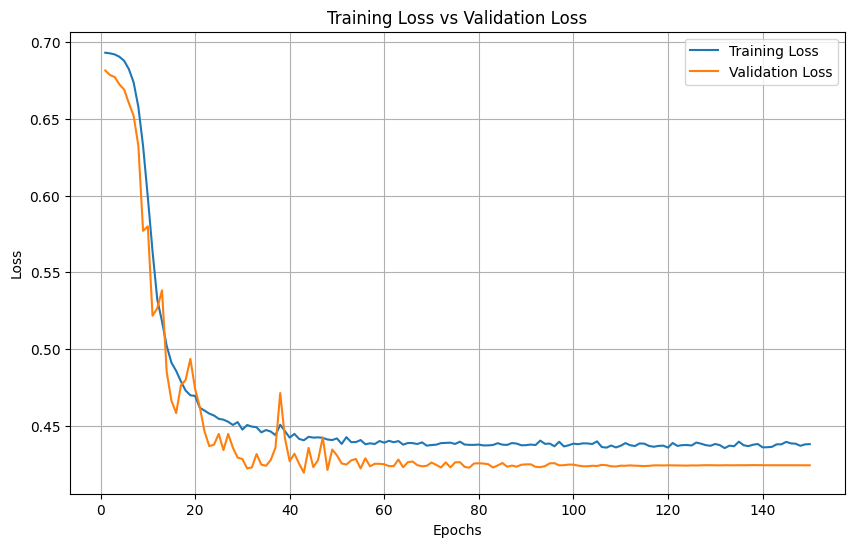

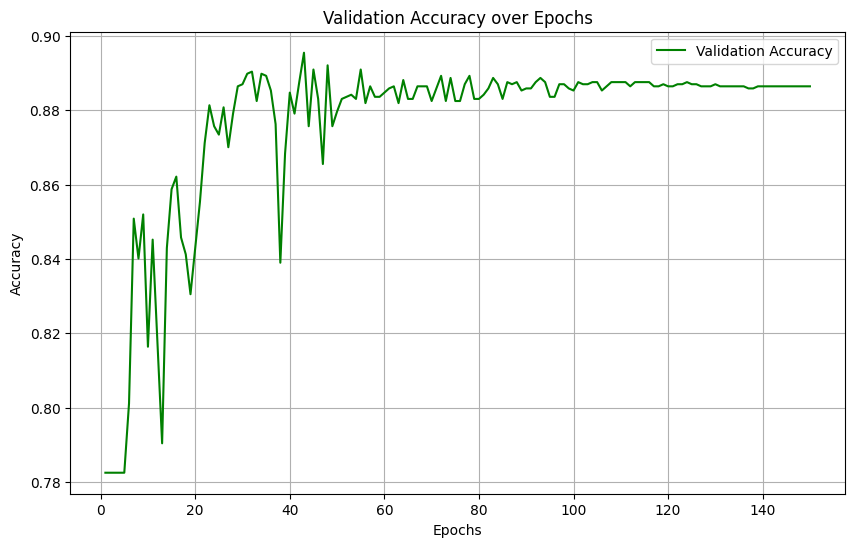

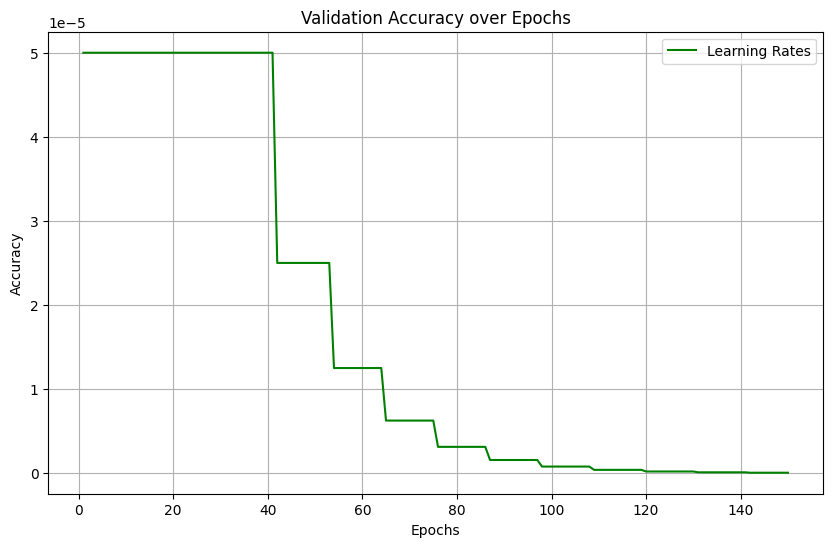

Model for bin 35 saved to 3DCholesterolModels-5A/model_bin_35.pth
1925 is length of subset grid
Training on bin 36
Bin 36, Epoch 1/150, Train Loss: 0.6930, Validation Loss: 0.6843, Validation Accuracy: 0.7825, Grad Norm: 0.1436, LR: 0.000050
Bin 36, Epoch 11/150, Train Loss: 0.6192, Validation Loss: 0.5400, Validation Accuracy: 0.8475, Grad Norm: 6.0330, LR: 0.000050
Bin 36, Epoch 21/150, Train Loss: 0.4872, Validation Loss: 0.4719, Validation Accuracy: 0.8508, Grad Norm: 6.3815, LR: 0.000050
Bin 36, Epoch 31/150, Train Loss: 0.4636, Validation Loss: 0.4414, Validation Accuracy: 0.8723, Grad Norm: 4.4423, LR: 0.000050
Bin 36, Epoch 41/150, Train Loss: 0.4571, Validation Loss: 0.4183, Validation Accuracy: 0.8955, Grad Norm: 3.4711, LR: 0.000050
Bin 36, Epoch 51/150, Train Loss: 0.4517, Validation Loss: 0.4196, Validation Accuracy: 0.8966, Grad Norm: 5.3288, LR: 0.000050
Bin 36, Epoch 61/150, Train Loss: 0.4503, Validation Loss: 0.4151, Validation Accuracy: 0.8972, Grad Norm: 6.4054, LR:

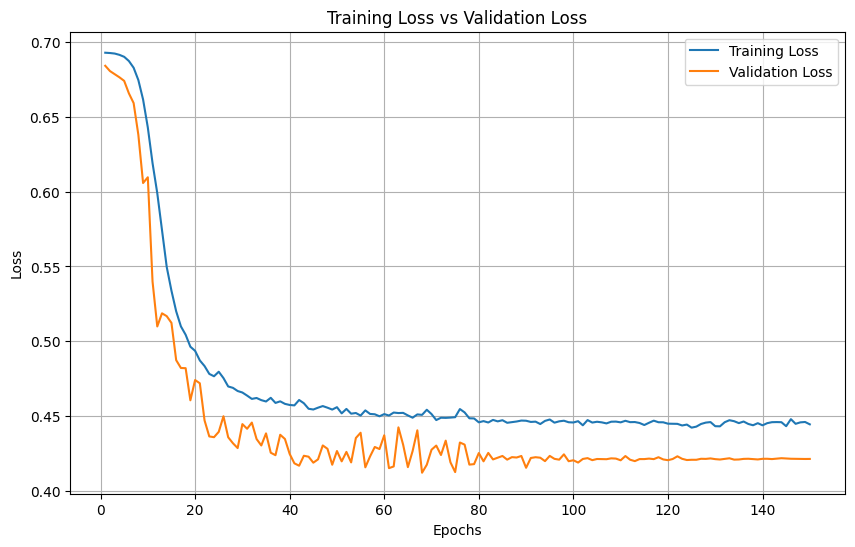

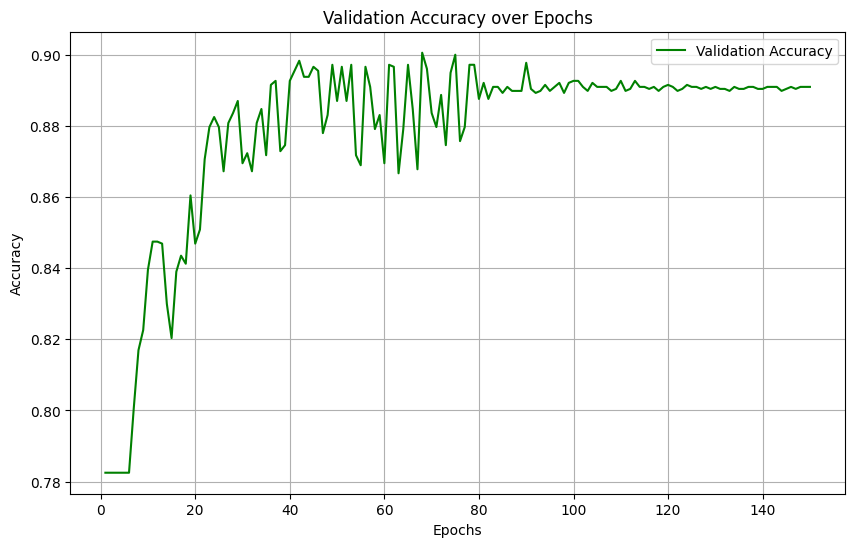

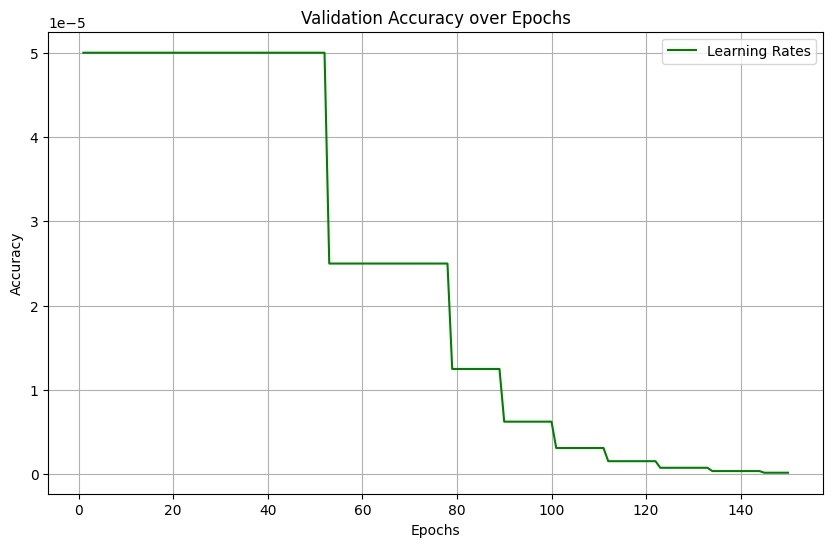

Model for bin 36 saved to 3DCholesterolModels-5A/model_bin_36.pth
1925 is length of subset grid
Training on bin 37
Bin 37, Epoch 1/150, Train Loss: 0.6930, Validation Loss: 0.6851, Validation Accuracy: 0.7825, Grad Norm: 0.0284, LR: 0.000050
Bin 37, Epoch 11/150, Train Loss: 0.5637, Validation Loss: 0.5149, Validation Accuracy: 0.8429, Grad Norm: 6.5112, LR: 0.000050
Bin 37, Epoch 21/150, Train Loss: 0.4655, Validation Loss: 0.4517, Validation Accuracy: 0.8633, Grad Norm: 3.9404, LR: 0.000050
Bin 37, Epoch 31/150, Train Loss: 0.4536, Validation Loss: 0.4492, Validation Accuracy: 0.8644, Grad Norm: 1.4027, LR: 0.000050
Bin 37, Epoch 41/150, Train Loss: 0.4463, Validation Loss: 0.4215, Validation Accuracy: 0.8921, Grad Norm: 1.4308, LR: 0.000050
Bin 37, Epoch 51/150, Train Loss: 0.4433, Validation Loss: 0.4252, Validation Accuracy: 0.8870, Grad Norm: 2.2444, LR: 0.000050
Bin 37, Epoch 61/150, Train Loss: 0.4427, Validation Loss: 0.4195, Validation Accuracy: 0.8949, Grad Norm: 2.0879, LR:

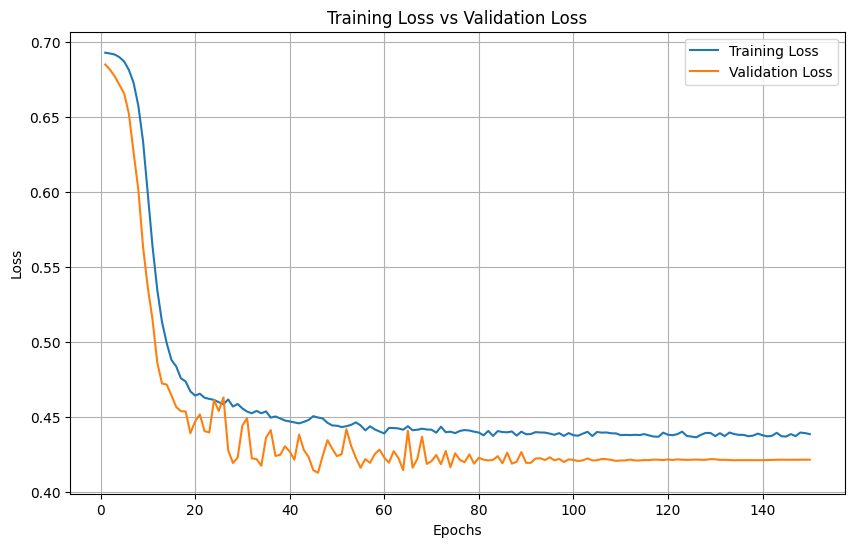

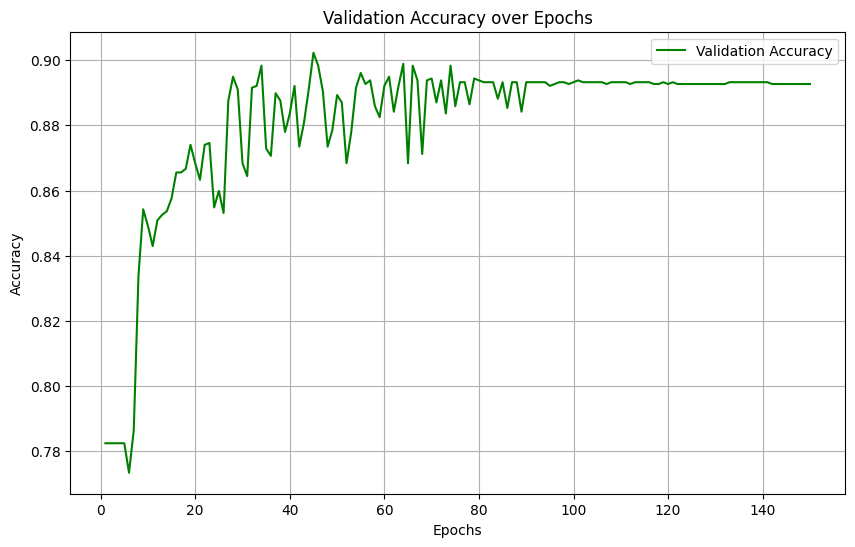

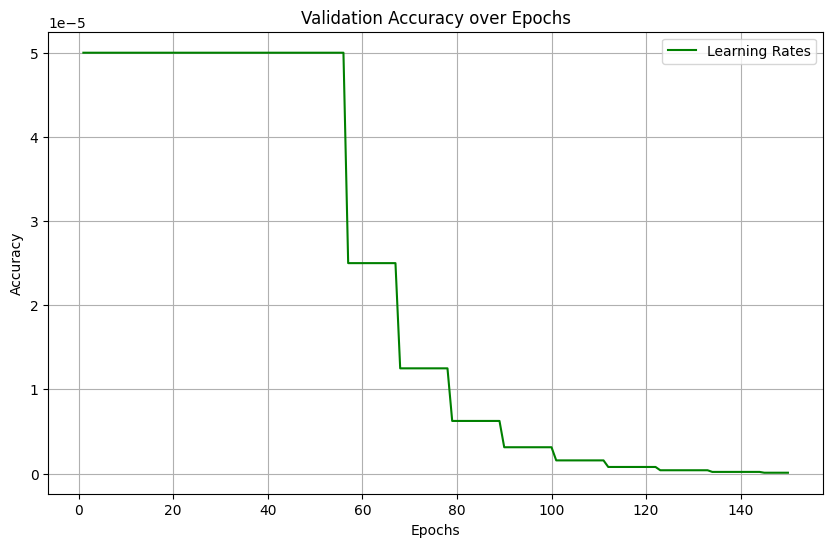

Model for bin 37 saved to 3DCholesterolModels-5A/model_bin_37.pth
1925 is length of subset grid
Training on bin 38
Bin 38, Epoch 1/150, Train Loss: 0.6930, Validation Loss: 0.6964, Validation Accuracy: 0.2175, Grad Norm: 0.0475, LR: 0.000050
Bin 38, Epoch 11/150, Train Loss: 0.5668, Validation Loss: 0.5082, Validation Accuracy: 0.8469, Grad Norm: 6.0681, LR: 0.000050
Bin 38, Epoch 21/150, Train Loss: 0.4594, Validation Loss: 0.4498, Validation Accuracy: 0.8678, Grad Norm: 4.7852, LR: 0.000050
Bin 38, Epoch 31/150, Train Loss: 0.4507, Validation Loss: 0.4466, Validation Accuracy: 0.8672, Grad Norm: 3.5915, LR: 0.000050
Bin 38, Epoch 41/150, Train Loss: 0.4415, Validation Loss: 0.4247, Validation Accuracy: 0.8893, Grad Norm: 1.1457, LR: 0.000050
Bin 38, Epoch 51/150, Train Loss: 0.4371, Validation Loss: 0.4290, Validation Accuracy: 0.8831, Grad Norm: 5.0785, LR: 0.000050
Bin 38, Epoch 61/150, Train Loss: 0.4331, Validation Loss: 0.4195, Validation Accuracy: 0.8932, Grad Norm: 6.1223, LR:

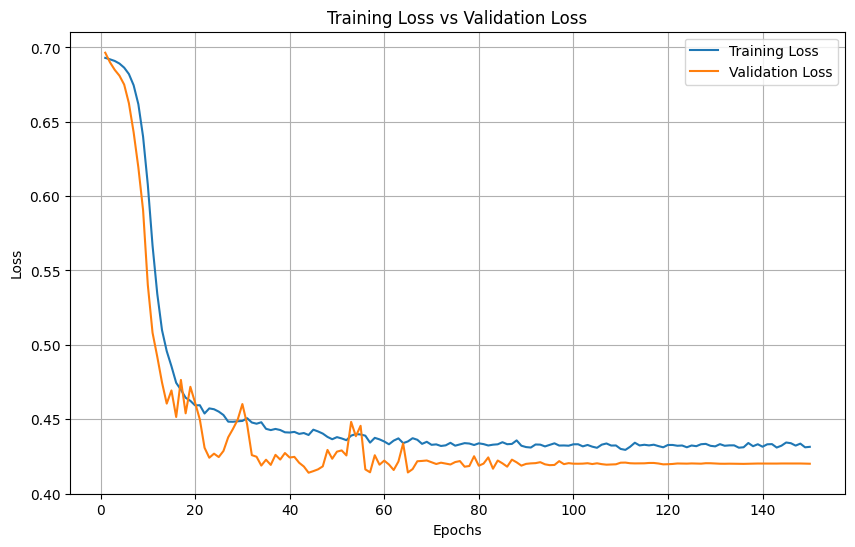

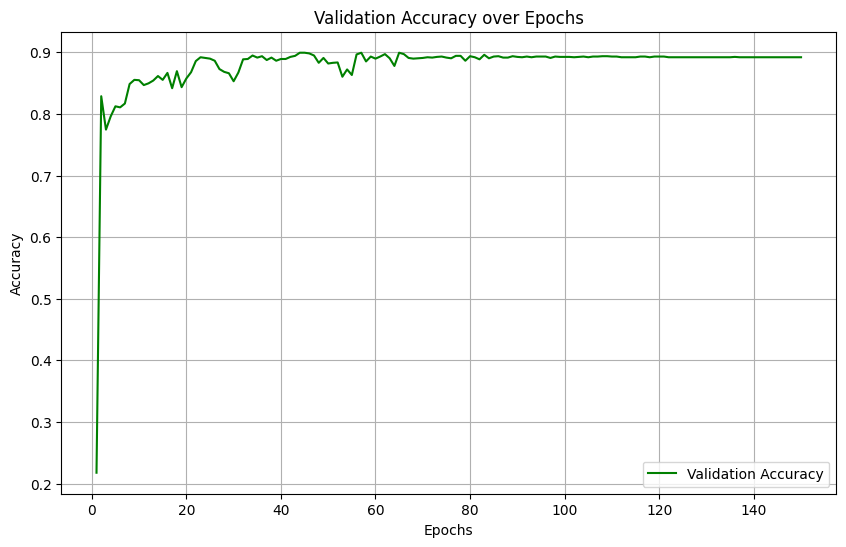

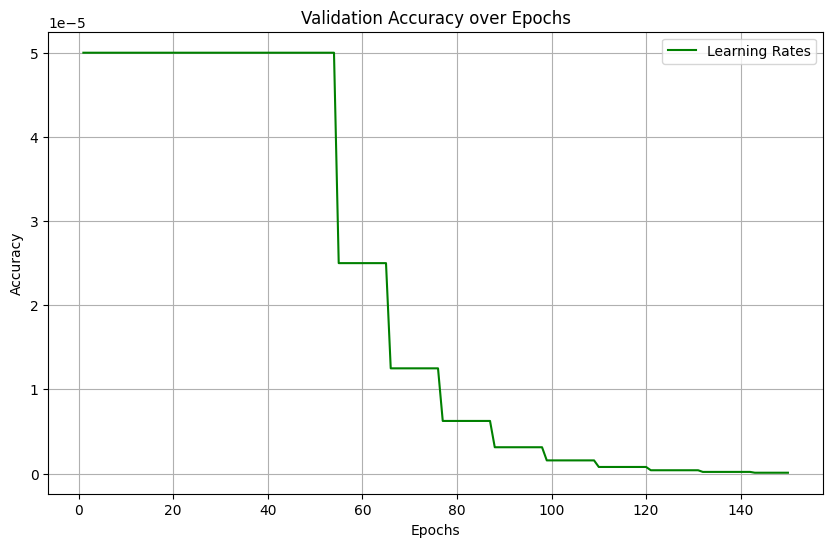

Model for bin 38 saved to 3DCholesterolModels-5A/model_bin_38.pth
1925 is length of subset grid
Training on bin 39
Bin 39, Epoch 1/150, Train Loss: 0.6932, Validation Loss: 0.6798, Validation Accuracy: 0.7825, Grad Norm: 0.0696, LR: 0.000050
Bin 39, Epoch 11/150, Train Loss: 0.6015, Validation Loss: 0.5646, Validation Accuracy: 0.8249, Grad Norm: 0.9010, LR: 0.000050
Bin 39, Epoch 21/150, Train Loss: 0.4711, Validation Loss: 0.4386, Validation Accuracy: 0.8763, Grad Norm: 6.4559, LR: 0.000050
Bin 39, Epoch 31/150, Train Loss: 0.4535, Validation Loss: 0.4276, Validation Accuracy: 0.8847, Grad Norm: 4.1220, LR: 0.000050
Bin 39, Epoch 41/150, Train Loss: 0.4476, Validation Loss: 0.4310, Validation Accuracy: 0.8842, Grad Norm: 3.4260, LR: 0.000050
Bin 39, Epoch 51/150, Train Loss: 0.4411, Validation Loss: 0.4272, Validation Accuracy: 0.8847, Grad Norm: 2.1396, LR: 0.000025
Bin 39, Epoch 61/150, Train Loss: 0.4422, Validation Loss: 0.4291, Validation Accuracy: 0.8808, Grad Norm: 2.1915, LR:

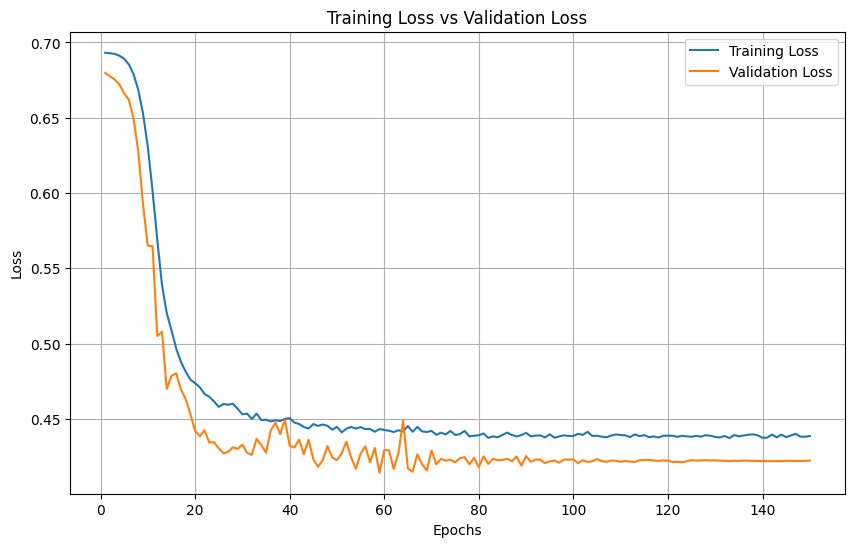

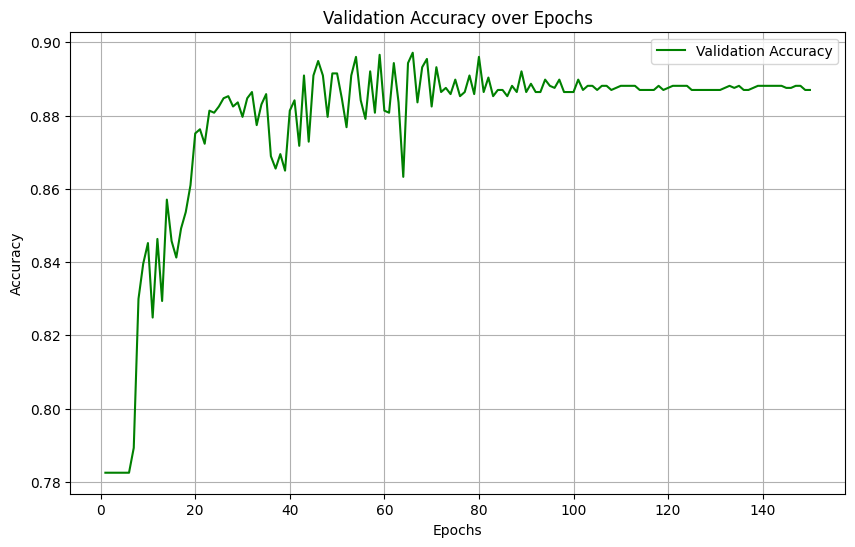

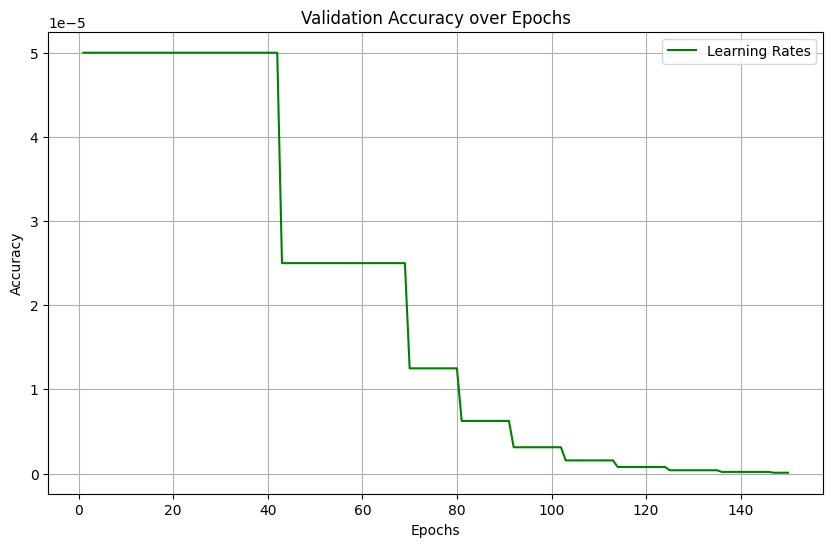

Model for bin 39 saved to 3DCholesterolModels-5A/model_bin_39.pth
1925 is length of subset grid
Training on bin 40
Bin 40, Epoch 1/150, Train Loss: 0.6930, Validation Loss: 0.6879, Validation Accuracy: 0.7825, Grad Norm: 0.0258, LR: 0.000050
Bin 40, Epoch 11/150, Train Loss: 0.5861, Validation Loss: 0.5459, Validation Accuracy: 0.8412, Grad Norm: 1.6596, LR: 0.000050
Bin 40, Epoch 21/150, Train Loss: 0.4704, Validation Loss: 0.4475, Validation Accuracy: 0.8689, Grad Norm: 6.0725, LR: 0.000050
Bin 40, Epoch 31/150, Train Loss: 0.4563, Validation Loss: 0.4426, Validation Accuracy: 0.8712, Grad Norm: 4.3643, LR: 0.000050
Bin 40, Epoch 41/150, Train Loss: 0.4520, Validation Loss: 0.4371, Validation Accuracy: 0.8718, Grad Norm: 5.5962, LR: 0.000050
Bin 40, Epoch 51/150, Train Loss: 0.4489, Validation Loss: 0.4353, Validation Accuracy: 0.8746, Grad Norm: 0.3700, LR: 0.000025
Bin 40, Epoch 61/150, Train Loss: 0.4471, Validation Loss: 0.4292, Validation Accuracy: 0.8831, Grad Norm: 5.9599, LR:

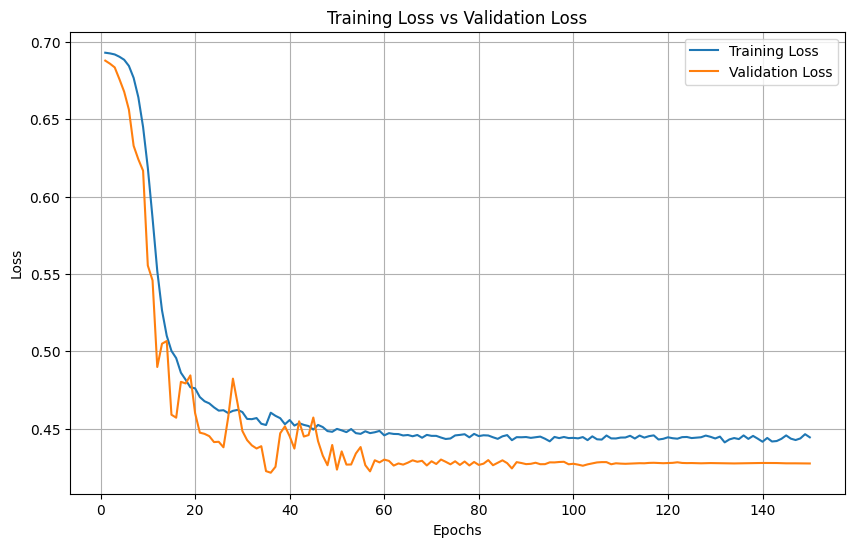

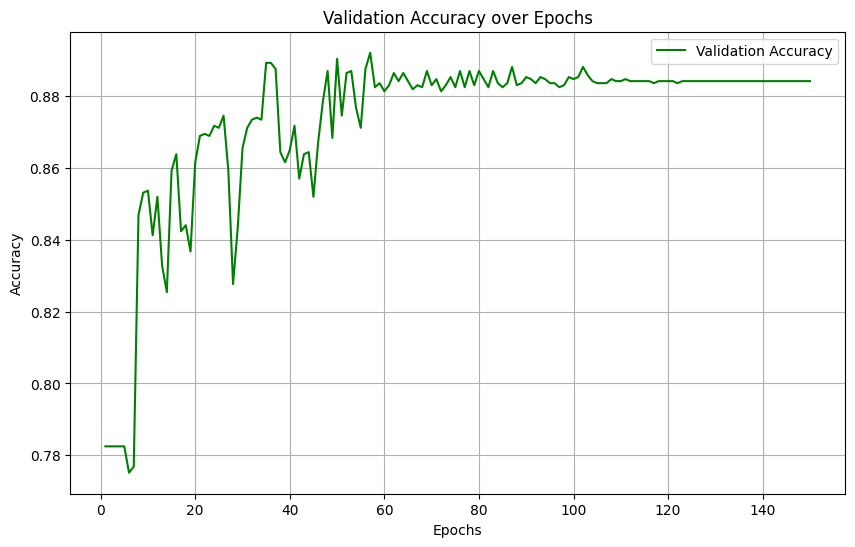

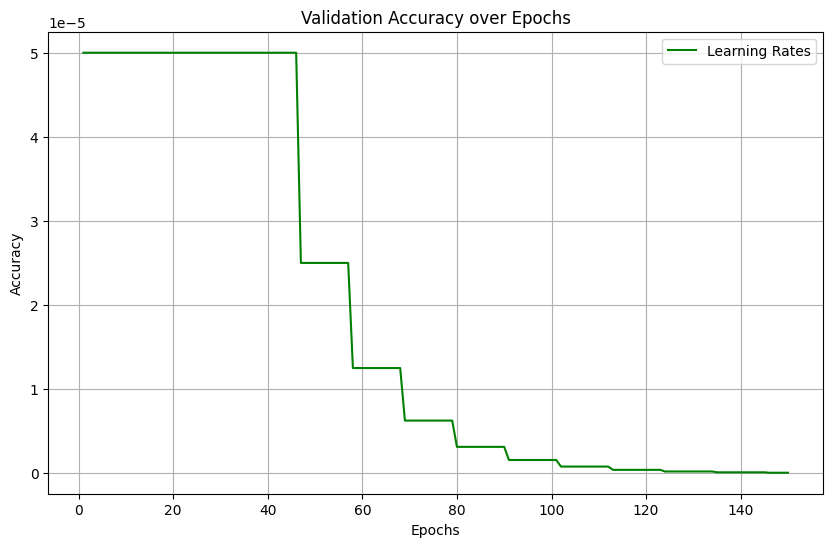

Model for bin 40 saved to 3DCholesterolModels-5A/model_bin_40.pth
1925 is length of subset grid
Training on bin 41
Bin 41, Epoch 1/150, Train Loss: 0.6930, Validation Loss: 0.6985, Validation Accuracy: 0.2175, Grad Norm: 0.0734, LR: 0.000050
Bin 41, Epoch 11/150, Train Loss: 0.5959, Validation Loss: 0.5177, Validation Accuracy: 0.8571, Grad Norm: 1.2942, LR: 0.000050
Bin 41, Epoch 21/150, Train Loss: 0.4711, Validation Loss: 0.4803, Validation Accuracy: 0.8328, Grad Norm: 2.0490, LR: 0.000050
Bin 41, Epoch 31/150, Train Loss: 0.4610, Validation Loss: 0.4311, Validation Accuracy: 0.8797, Grad Norm: 0.3167, LR: 0.000050
Bin 41, Epoch 41/150, Train Loss: 0.4537, Validation Loss: 0.4321, Validation Accuracy: 0.8746, Grad Norm: 6.3709, LR: 0.000050
Bin 41, Epoch 51/150, Train Loss: 0.4486, Validation Loss: 0.4218, Validation Accuracy: 0.8932, Grad Norm: 0.2823, LR: 0.000050
Bin 41, Epoch 61/150, Train Loss: 0.4492, Validation Loss: 0.4127, Validation Accuracy: 0.9000, Grad Norm: 6.3259, LR:

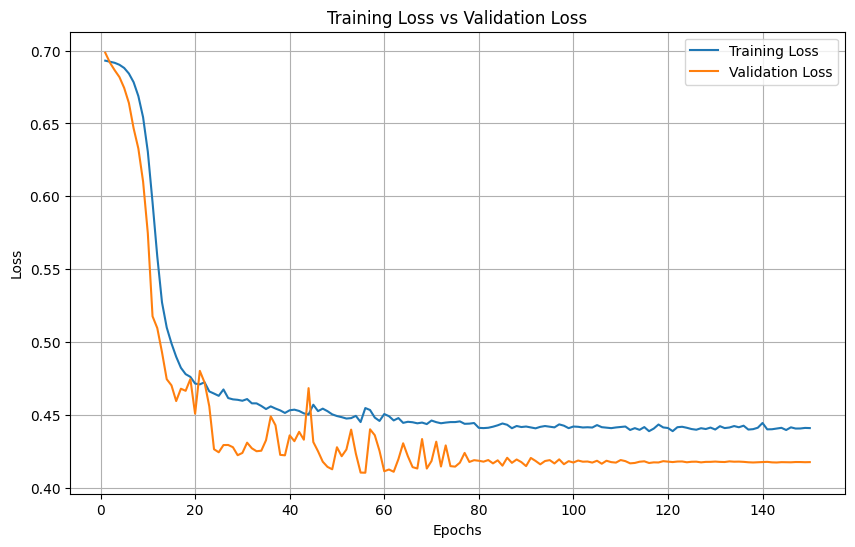

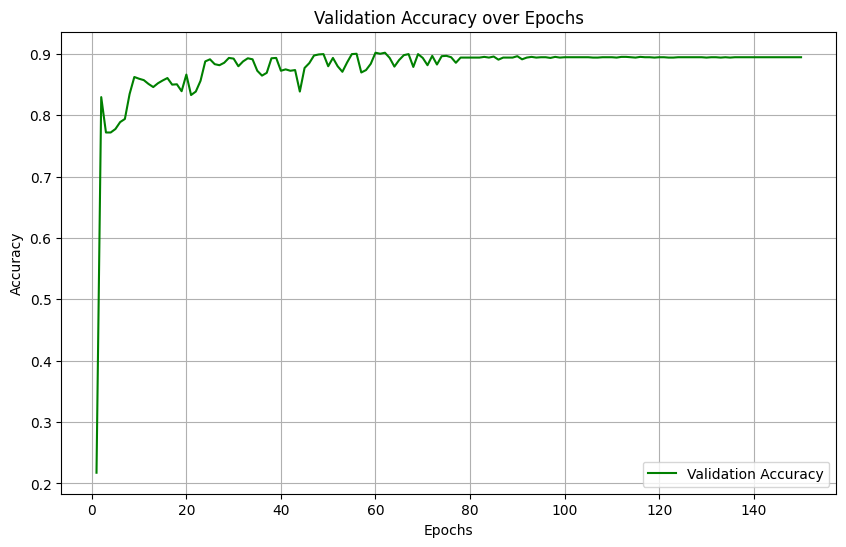

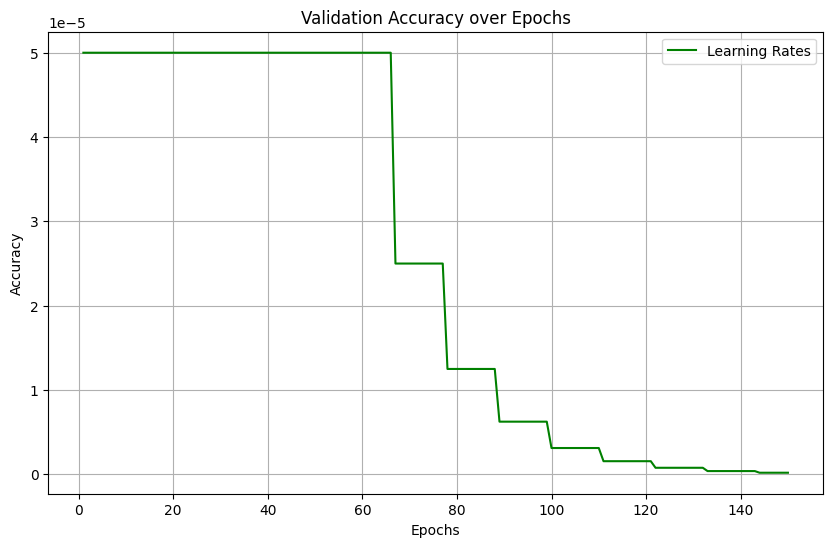

Model for bin 41 saved to 3DCholesterolModels-5A/model_bin_41.pth
1925 is length of subset grid
Training on bin 42
Bin 42, Epoch 1/150, Train Loss: 0.6931, Validation Loss: 0.6902, Validation Accuracy: 0.7825, Grad Norm: 0.1001, LR: 0.000050
Bin 42, Epoch 11/150, Train Loss: 0.6228, Validation Loss: 0.5855, Validation Accuracy: 0.8486, Grad Norm: 2.5956, LR: 0.000050
Bin 42, Epoch 21/150, Train Loss: 0.4730, Validation Loss: 0.4387, Validation Accuracy: 0.8729, Grad Norm: 0.4869, LR: 0.000050
Bin 42, Epoch 31/150, Train Loss: 0.4530, Validation Loss: 0.4455, Validation Accuracy: 0.8723, Grad Norm: 1.5827, LR: 0.000050
Bin 42, Epoch 41/150, Train Loss: 0.4494, Validation Loss: 0.4340, Validation Accuracy: 0.8802, Grad Norm: 3.7237, LR: 0.000025
Bin 42, Epoch 51/150, Train Loss: 0.4434, Validation Loss: 0.4280, Validation Accuracy: 0.8847, Grad Norm: 3.0721, LR: 0.000025
Bin 42, Epoch 61/150, Train Loss: 0.4433, Validation Loss: 0.4210, Validation Accuracy: 0.8944, Grad Norm: 1.4567, LR:

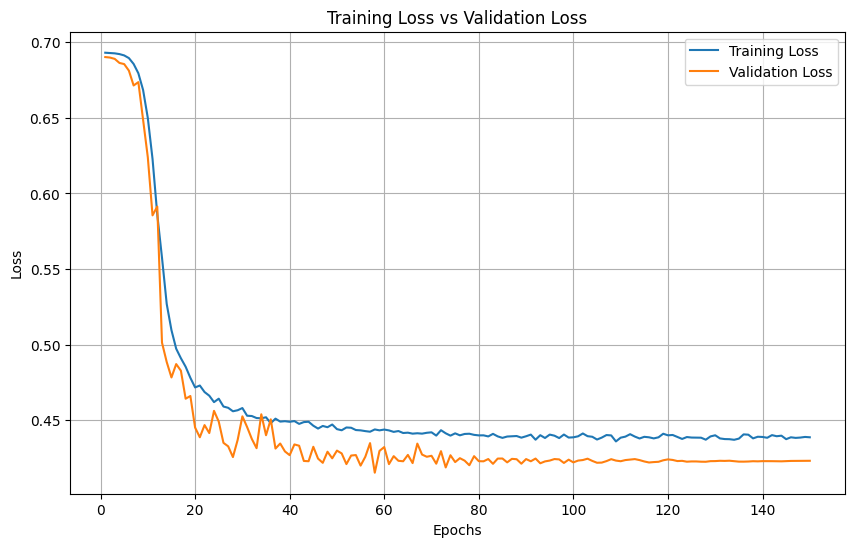

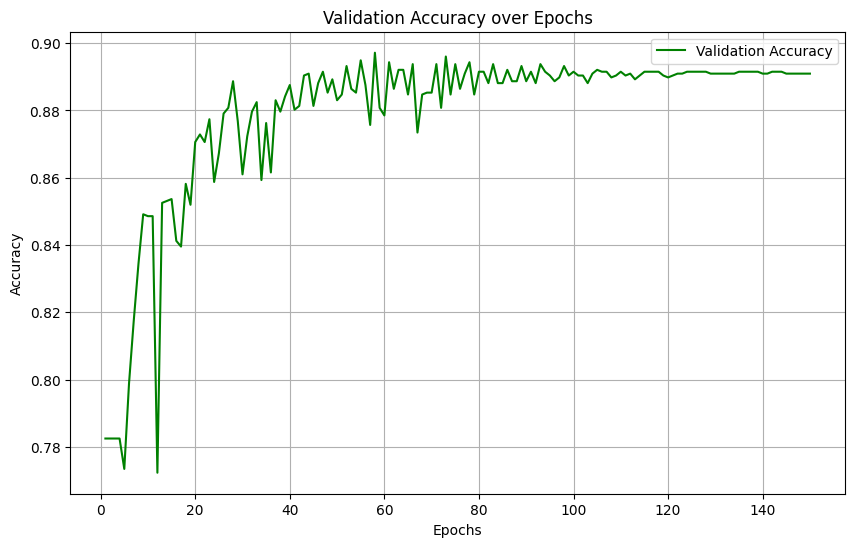

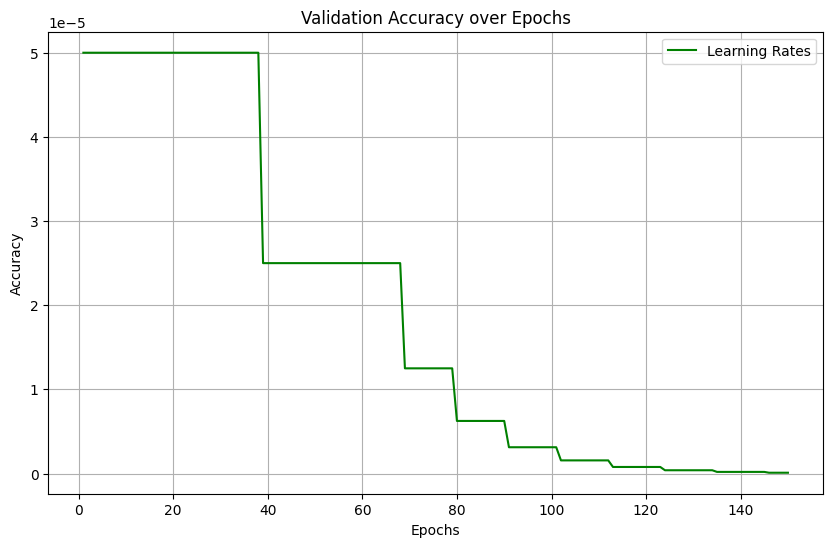

Model for bin 42 saved to 3DCholesterolModels-5A/model_bin_42.pth
1925 is length of subset grid
Training on bin 43
Bin 43, Epoch 1/150, Train Loss: 0.6932, Validation Loss: 0.6857, Validation Accuracy: 0.7825, Grad Norm: 0.1638, LR: 0.000050
Bin 43, Epoch 11/150, Train Loss: 0.5718, Validation Loss: 0.5175, Validation Accuracy: 0.8475, Grad Norm: 1.3168, LR: 0.000050
Bin 43, Epoch 21/150, Train Loss: 0.4586, Validation Loss: 0.4495, Validation Accuracy: 0.8667, Grad Norm: 1.2964, LR: 0.000050
Bin 43, Epoch 31/150, Train Loss: 0.4470, Validation Loss: 0.4406, Validation Accuracy: 0.8678, Grad Norm: 6.4827, LR: 0.000050
Bin 43, Epoch 41/150, Train Loss: 0.4408, Validation Loss: 0.4292, Validation Accuracy: 0.8797, Grad Norm: 6.3809, LR: 0.000050
Bin 43, Epoch 51/150, Train Loss: 0.4382, Validation Loss: 0.4172, Validation Accuracy: 0.8932, Grad Norm: 1.2093, LR: 0.000050
Bin 43, Epoch 61/150, Train Loss: 0.4356, Validation Loss: 0.4291, Validation Accuracy: 0.8842, Grad Norm: 6.4822, LR:

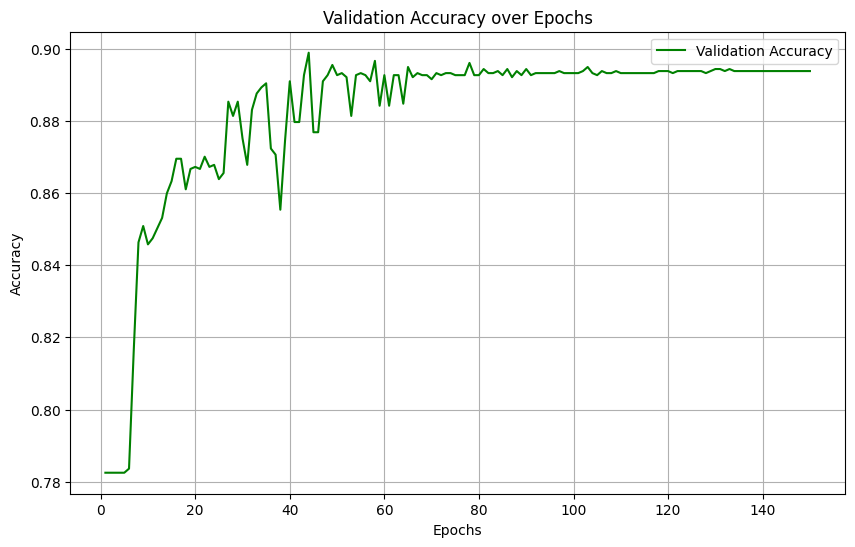

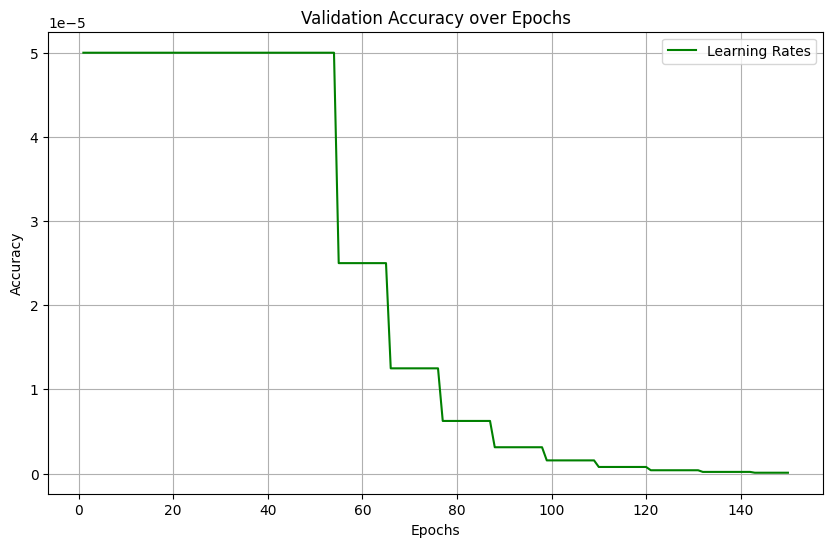

Model for bin 43 saved to 3DCholesterolModels-5A/model_bin_43.pth
1925 is length of subset grid
Training on bin 44
Bin 44, Epoch 1/150, Train Loss: 0.6931, Validation Loss: 0.6955, Validation Accuracy: 0.2175, Grad Norm: 0.0722, LR: 0.000050
Bin 44, Epoch 11/150, Train Loss: 0.6068, Validation Loss: 0.5187, Validation Accuracy: 0.8554, Grad Norm: 2.6420, LR: 0.000050
Bin 44, Epoch 21/150, Train Loss: 0.4676, Validation Loss: 0.4464, Validation Accuracy: 0.8701, Grad Norm: 1.0192, LR: 0.000050
Bin 44, Epoch 31/150, Train Loss: 0.4564, Validation Loss: 0.4342, Validation Accuracy: 0.8768, Grad Norm: 3.0216, LR: 0.000050
Bin 44, Epoch 41/150, Train Loss: 0.4517, Validation Loss: 0.4159, Validation Accuracy: 0.8966, Grad Norm: 1.2879, LR: 0.000050
Bin 44, Epoch 51/150, Train Loss: 0.4442, Validation Loss: 0.4274, Validation Accuracy: 0.8819, Grad Norm: 6.3222, LR: 0.000050
Bin 44, Epoch 61/150, Train Loss: 0.4439, Validation Loss: 0.4220, Validation Accuracy: 0.8881, Grad Norm: 1.4515, LR:

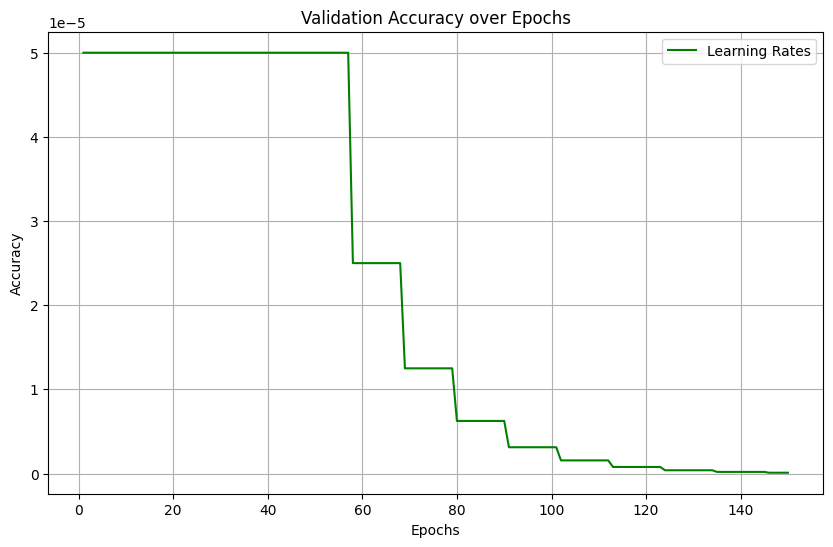

Model for bin 44 saved to 3DCholesterolModels-5A/model_bin_44.pth
1925 is length of subset grid
Training on bin 45
Bin 45, Epoch 1/150, Train Loss: 0.6933, Validation Loss: 0.6776, Validation Accuracy: 0.7825, Grad Norm: 0.0395, LR: 0.000050
Bin 45, Epoch 11/150, Train Loss: 0.5752, Validation Loss: 0.5339, Validation Accuracy: 0.8328, Grad Norm: 0.7970, LR: 0.000050
Bin 45, Epoch 21/150, Train Loss: 0.4629, Validation Loss: 0.4375, Validation Accuracy: 0.8808, Grad Norm: 3.9400, LR: 0.000050
Bin 45, Epoch 31/150, Train Loss: 0.4558, Validation Loss: 0.4433, Validation Accuracy: 0.8689, Grad Norm: 3.4063, LR: 0.000050
Bin 45, Epoch 41/150, Train Loss: 0.4464, Validation Loss: 0.4256, Validation Accuracy: 0.8853, Grad Norm: 2.0448, LR: 0.000050
Bin 45, Epoch 51/150, Train Loss: 0.4447, Validation Loss: 0.4156, Validation Accuracy: 0.8989, Grad Norm: 6.4966, LR: 0.000025
Bin 45, Epoch 61/150, Train Loss: 0.4411, Validation Loss: 0.4153, Validation Accuracy: 0.8977, Grad Norm: 3.9986, LR:

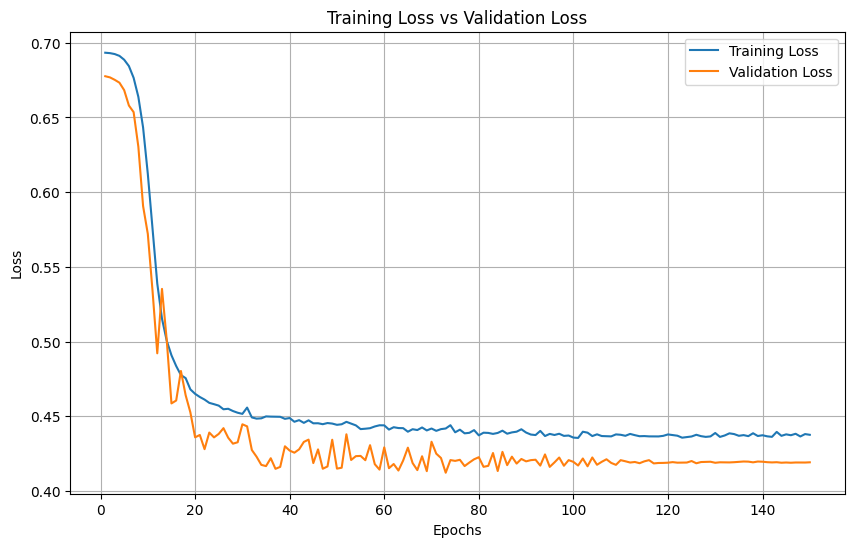

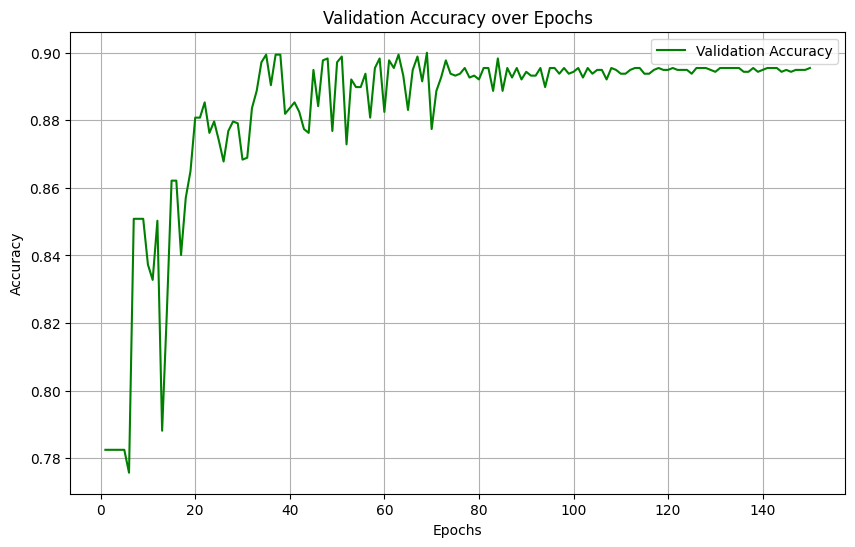

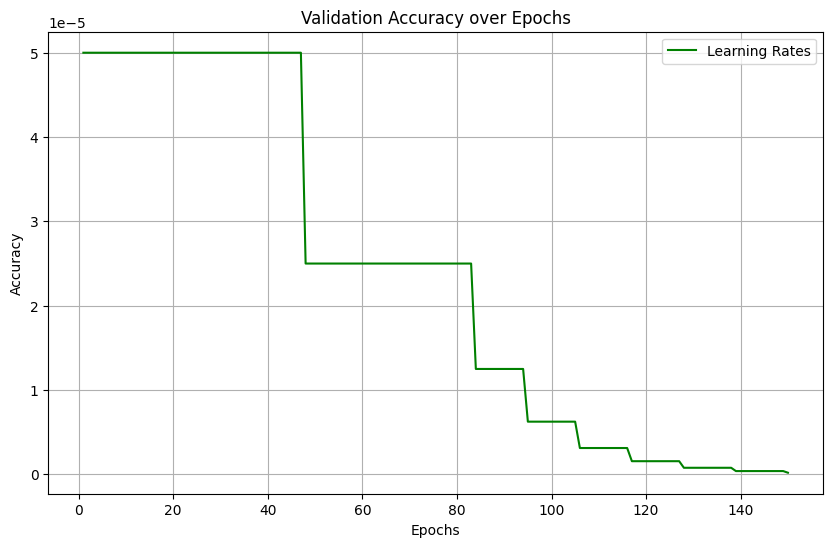

Model for bin 45 saved to 3DCholesterolModels-5A/model_bin_45.pth
1925 is length of subset grid
Training on bin 46
Bin 46, Epoch 1/150, Train Loss: 0.6930, Validation Loss: 0.6986, Validation Accuracy: 0.2175, Grad Norm: 0.0701, LR: 0.000050
Bin 46, Epoch 11/150, Train Loss: 0.6308, Validation Loss: 0.5760, Validation Accuracy: 0.8542, Grad Norm: 4.1279, LR: 0.000050
Bin 46, Epoch 21/150, Train Loss: 0.4662, Validation Loss: 0.4591, Validation Accuracy: 0.8593, Grad Norm: 2.9465, LR: 0.000050
Bin 46, Epoch 31/150, Train Loss: 0.4544, Validation Loss: 0.4222, Validation Accuracy: 0.8921, Grad Norm: 1.0179, LR: 0.000050
Bin 46, Epoch 41/150, Train Loss: 0.4535, Validation Loss: 0.4155, Validation Accuracy: 0.8977, Grad Norm: 6.1650, LR: 0.000050
Bin 46, Epoch 51/150, Train Loss: 0.4459, Validation Loss: 0.4147, Validation Accuracy: 0.8989, Grad Norm: 6.1466, LR: 0.000050
Bin 46, Epoch 61/150, Train Loss: 0.4435, Validation Loss: 0.4106, Validation Accuracy: 0.8989, Grad Norm: 4.7168, LR:

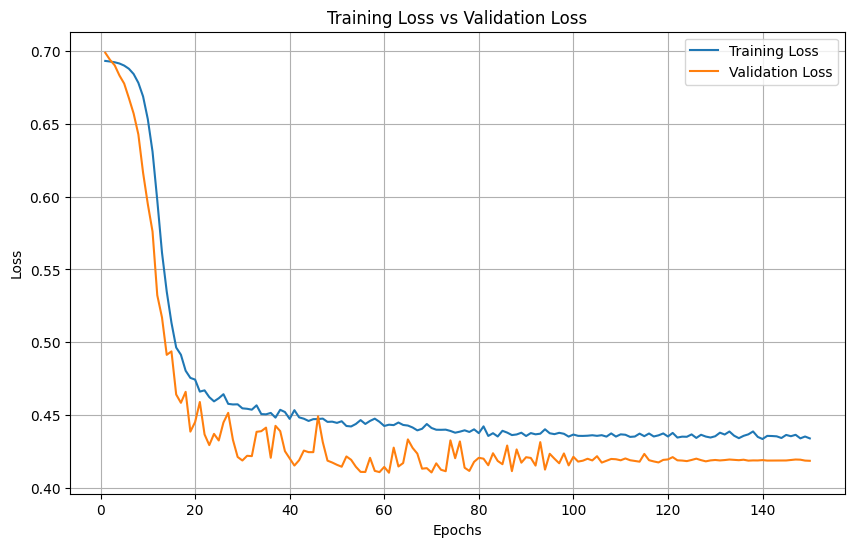

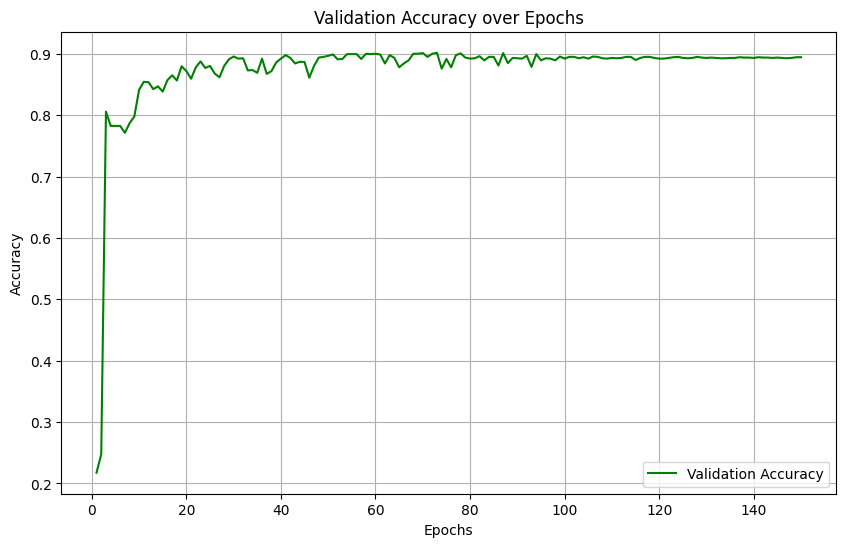

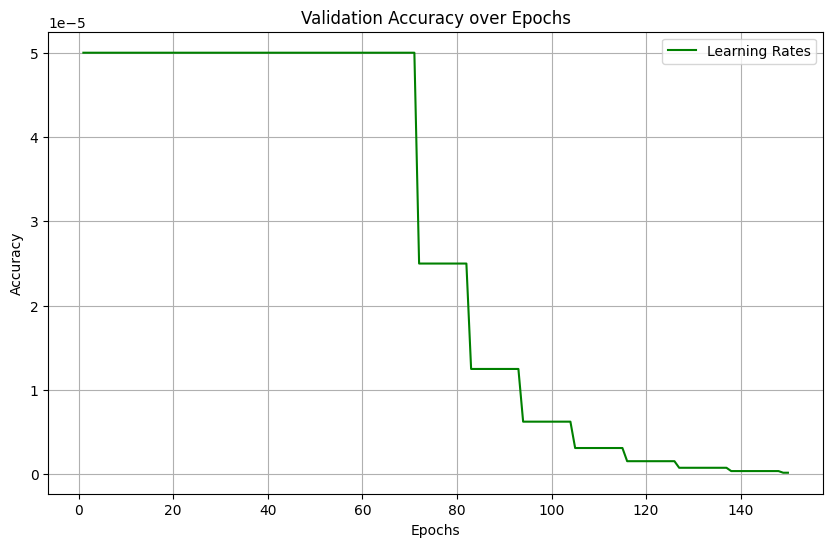

Model for bin 46 saved to 3DCholesterolModels-5A/model_bin_46.pth
1925 is length of subset grid
Training on bin 47
Bin 47, Epoch 1/150, Train Loss: 0.6930, Validation Loss: 0.6825, Validation Accuracy: 0.7825, Grad Norm: 0.0780, LR: 0.000050
Bin 47, Epoch 11/150, Train Loss: 0.5609, Validation Loss: 0.5166, Validation Accuracy: 0.8373, Grad Norm: 1.9158, LR: 0.000050
Bin 47, Epoch 21/150, Train Loss: 0.4598, Validation Loss: 0.4395, Validation Accuracy: 0.8785, Grad Norm: 2.2061, LR: 0.000050
Bin 47, Epoch 31/150, Train Loss: 0.4465, Validation Loss: 0.4485, Validation Accuracy: 0.8633, Grad Norm: 2.3120, LR: 0.000050
Bin 47, Epoch 41/150, Train Loss: 0.4412, Validation Loss: 0.4229, Validation Accuracy: 0.8904, Grad Norm: 2.5089, LR: 0.000025
Bin 47, Epoch 51/150, Train Loss: 0.4403, Validation Loss: 0.4184, Validation Accuracy: 0.8927, Grad Norm: 5.2943, LR: 0.000025
Bin 47, Epoch 61/150, Train Loss: 0.4397, Validation Loss: 0.4410, Validation Accuracy: 0.8689, Grad Norm: 6.3608, LR:

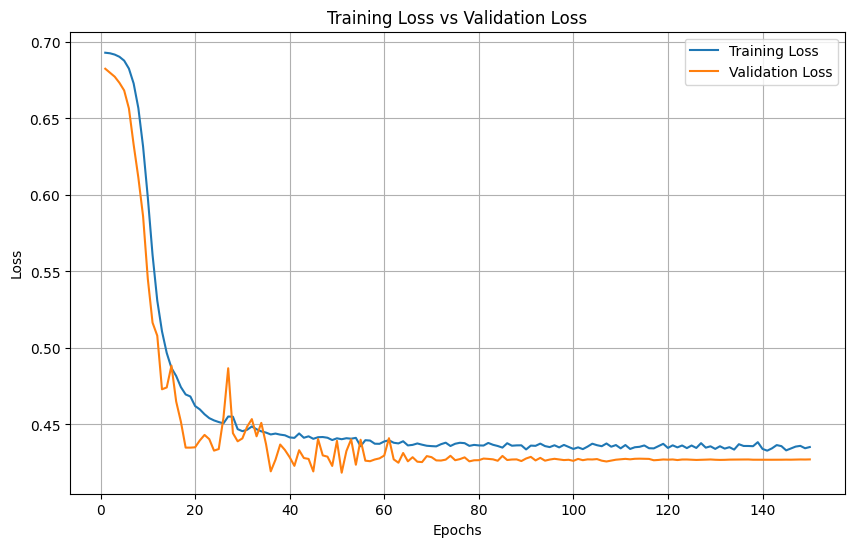

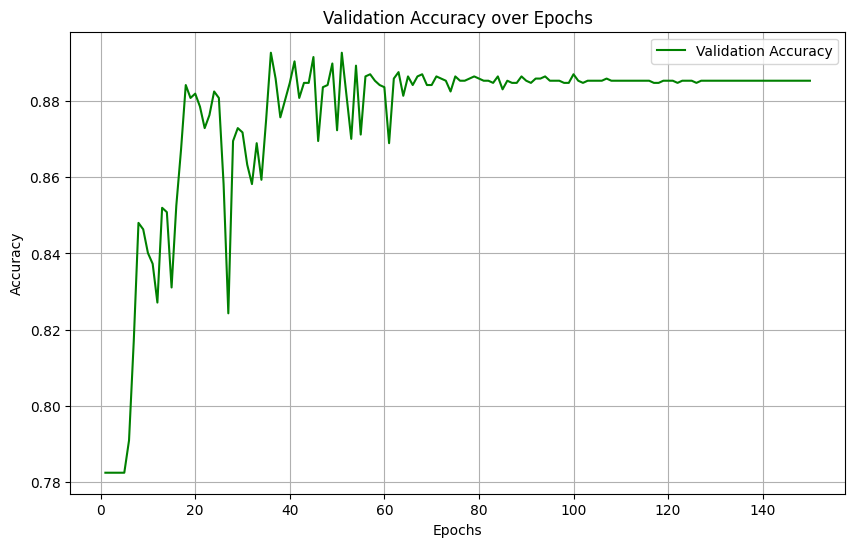

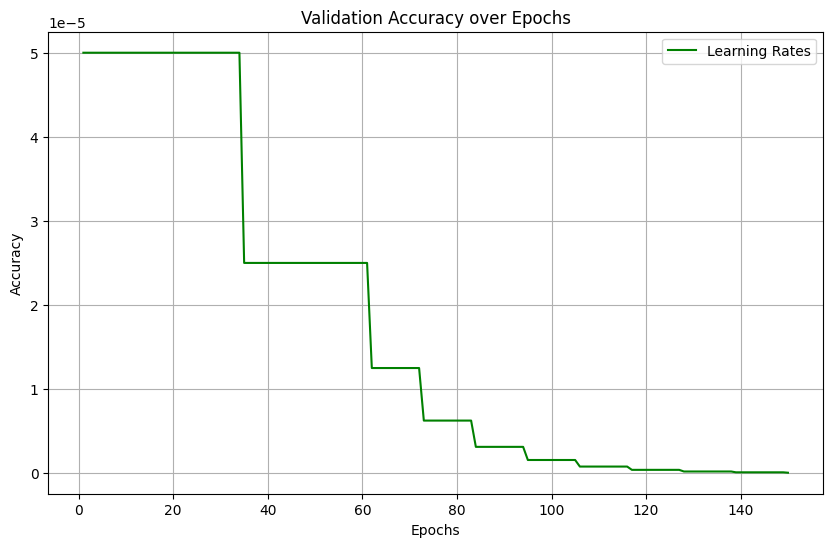

Model for bin 47 saved to 3DCholesterolModels-5A/model_bin_47.pth
1925 is length of subset grid
Training on bin 48
Bin 48, Epoch 1/150, Train Loss: 0.6930, Validation Loss: 0.6931, Validation Accuracy: 0.5831, Grad Norm: 0.0785, LR: 0.000050
Bin 48, Epoch 11/150, Train Loss: 0.6136, Validation Loss: 0.5991, Validation Accuracy: 0.8090, Grad Norm: 1.1553, LR: 0.000050
Bin 48, Epoch 21/150, Train Loss: 0.4673, Validation Loss: 0.4614, Validation Accuracy: 0.8576, Grad Norm: 2.9110, LR: 0.000050
Bin 48, Epoch 31/150, Train Loss: 0.4492, Validation Loss: 0.4310, Validation Accuracy: 0.8836, Grad Norm: 5.0963, LR: 0.000050
Bin 48, Epoch 41/150, Train Loss: 0.4444, Validation Loss: 0.4509, Validation Accuracy: 0.8593, Grad Norm: 0.4516, LR: 0.000050
Bin 48, Epoch 51/150, Train Loss: 0.4394, Validation Loss: 0.4288, Validation Accuracy: 0.8808, Grad Norm: 5.0526, LR: 0.000050
Bin 48, Epoch 61/150, Train Loss: 0.4346, Validation Loss: 0.4260, Validation Accuracy: 0.8864, Grad Norm: 3.3220, LR:

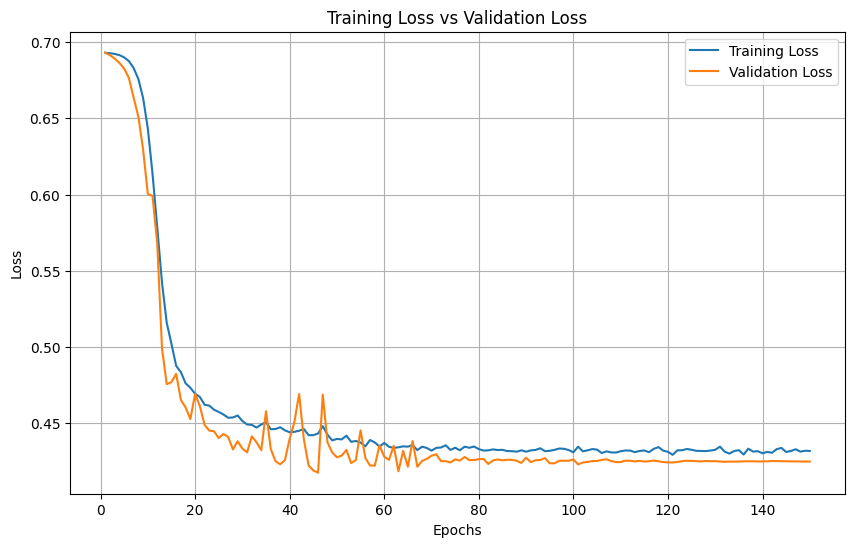

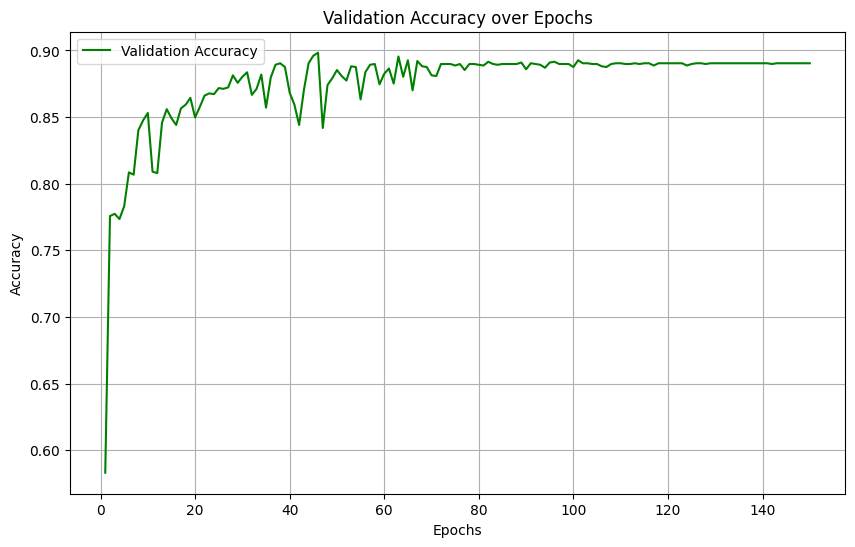

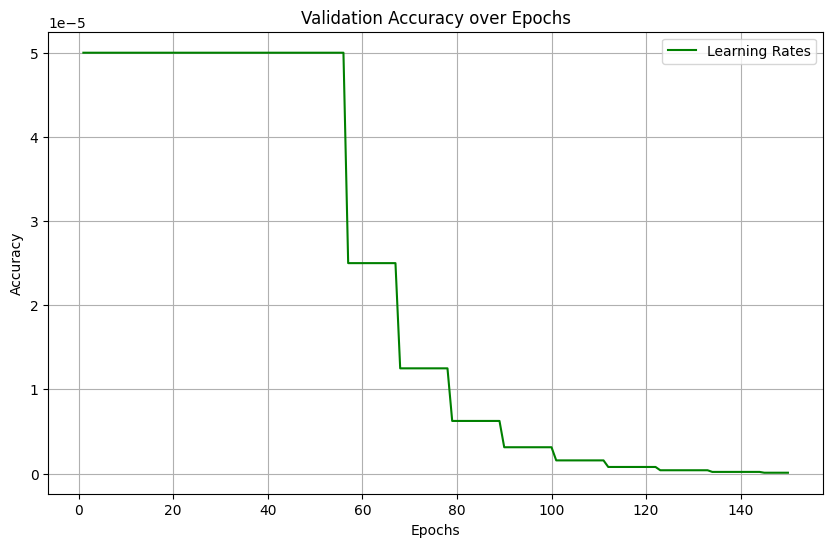

Model for bin 48 saved to 3DCholesterolModels-5A/model_bin_48.pth
1925 is length of subset grid
Training on bin 49
Bin 49, Epoch 1/150, Train Loss: 0.6931, Validation Loss: 0.6934, Validation Accuracy: 0.2243, Grad Norm: 0.0802, LR: 0.000050
Bin 49, Epoch 11/150, Train Loss: 0.6311, Validation Loss: 0.6126, Validation Accuracy: 0.8085, Grad Norm: 4.9536, LR: 0.000050
Bin 49, Epoch 21/150, Train Loss: 0.4621, Validation Loss: 0.4403, Validation Accuracy: 0.8768, Grad Norm: 4.6655, LR: 0.000050
Bin 49, Epoch 31/150, Train Loss: 0.4468, Validation Loss: 0.4365, Validation Accuracy: 0.8797, Grad Norm: 0.4611, LR: 0.000050
Bin 49, Epoch 41/150, Train Loss: 0.4411, Validation Loss: 0.4439, Validation Accuracy: 0.8689, Grad Norm: 6.3786, LR: 0.000050
Bin 49, Epoch 51/150, Train Loss: 0.4395, Validation Loss: 0.4288, Validation Accuracy: 0.8859, Grad Norm: 6.2995, LR: 0.000050
Bin 49, Epoch 61/150, Train Loss: 0.4351, Validation Loss: 0.4267, Validation Accuracy: 0.8876, Grad Norm: 5.7352, LR:

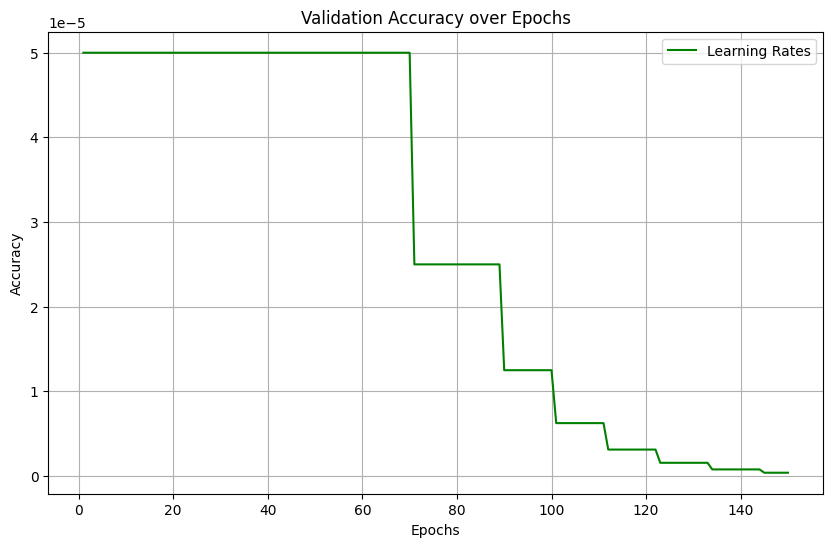

Model for bin 49 saved to 3DCholesterolModels-5A/model_bin_49.pth
1925 is length of subset grid
Training on bin 50
Bin 50, Epoch 1/150, Train Loss: 0.6931, Validation Loss: 0.6856, Validation Accuracy: 0.7825, Grad Norm: 0.0246, LR: 0.000050
Bin 50, Epoch 11/150, Train Loss: 0.5850, Validation Loss: 0.5719, Validation Accuracy: 0.7972, Grad Norm: 2.2081, LR: 0.000050
Bin 50, Epoch 21/150, Train Loss: 0.4843, Validation Loss: 0.4579, Validation Accuracy: 0.8599, Grad Norm: 4.2298, LR: 0.000050
Bin 50, Epoch 31/150, Train Loss: 0.4625, Validation Loss: 0.4433, Validation Accuracy: 0.8695, Grad Norm: 0.4613, LR: 0.000050
Bin 50, Epoch 41/150, Train Loss: 0.4574, Validation Loss: 0.4297, Validation Accuracy: 0.8842, Grad Norm: 0.8396, LR: 0.000050
Bin 50, Epoch 51/150, Train Loss: 0.4523, Validation Loss: 0.4335, Validation Accuracy: 0.8785, Grad Norm: 1.7259, LR: 0.000025
Bin 50, Epoch 61/150, Train Loss: 0.4468, Validation Loss: 0.4346, Validation Accuracy: 0.8780, Grad Norm: 2.0629, LR:

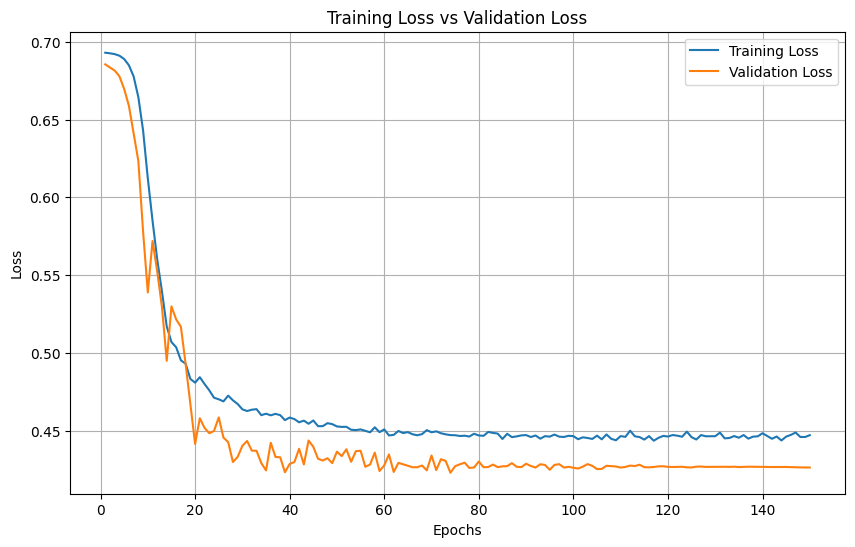

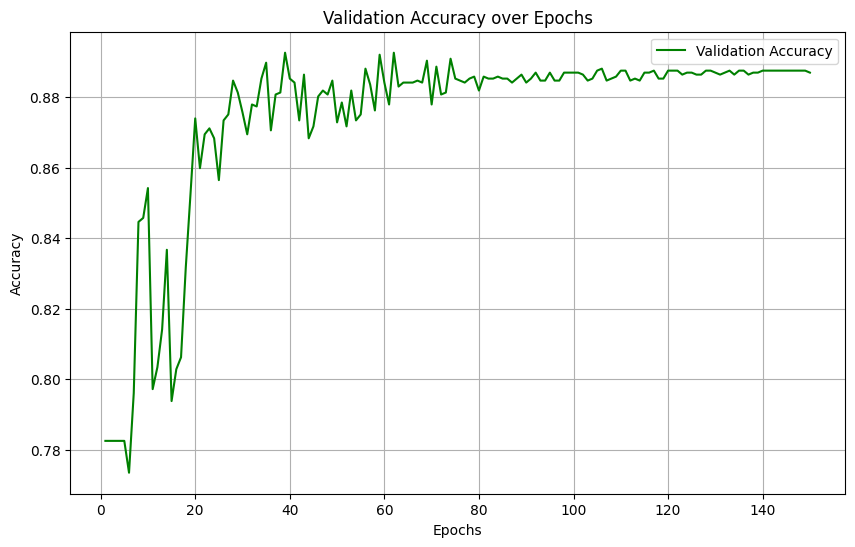

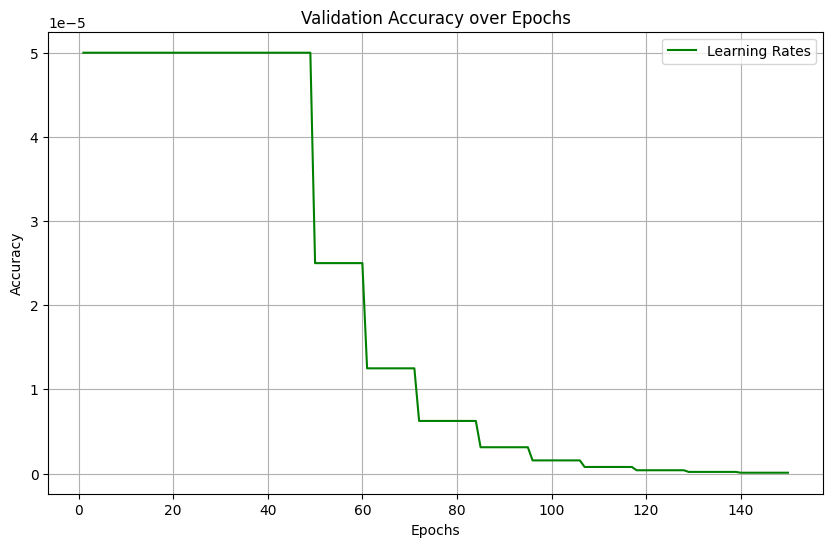

Model for bin 50 saved to 3DCholesterolModels-5A/model_bin_50.pth
Training complete.


In [54]:
import os

# Training loop
epochs = 150
batch_size = 512

validation_dataset = GridDataset(validation_grids)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

for i in range(1, 50):
    k = i + 1
    file_data = {}
    subset_grid = glob.glob(f'../../../Data/SplitData/Cholesterol/cholesterol-grid-5A/k_subsets/subset_{k}/*.npy')  # Adjust path as needed
    for file in subset_grid:
        # Load the numpy array and convert it to a PyTorch tensor
        grid = np.load(file)
        grid_tensor = torch.tensor(grid, dtype=torch.float32).permute(3, 0, 1, 2)  # Fix input format
        file_data[file] = {'label': 0, 'grid_tensor': grid_tensor} # 0 means unlabeled
    subset_grid = file_data
    print(len(subset_grid), "is length of subset grid")
    
    bin = {**positive_grids, **subset_grid} # merged
    
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # specify to run on 3 gpu, run on scrum, convert to .py 
    
    # Initialize the model
    criterion = nn.CrossEntropyLoss()
    
    # Define paths for saving models
    save_dir = "3DCholesterolModels-5A"
    os.makedirs(save_dir, exist_ok=True)
    
    model = CNN3D().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.00005, weight_decay=1e-4) # maybe try momentum 0.9
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, threshold=1e-4)
    #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.90)  # Reduce LR every 10 epochs
    #scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.90)
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5000, eta_min=1e-6)
    
    print(f"Training on bin {k}")
    dataset = GridDataset(bin)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    train_losses = []
    validation_losses = []
    validation_accuracies = []
    learning_rates = []
    
    for epoch in range(epochs):
        epoch_loss, grad_norm = train_model(model, dataloader, criterion, optimizer, device)
        validation_loss, validation_accuracy = validate_model(model, validation_dataloader, criterion, device)
        scheduler.step(validation_loss)
        current_lr = optimizer.param_groups[0]['lr'] 
        train_losses.append(epoch_loss)
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)
        learning_rates.append(current_lr)
    
        if epoch % 10 == 0:
            print(
                f"Bin {k}, Epoch {epoch+1}/{epochs}, "
                f"Train Loss: {epoch_loss:.4f}, Validation Loss: {validation_loss:.4f}, "
                f"Validation Accuracy: {validation_accuracy:.4f}, Grad Norm: {grad_norm:.4f}, "
                f"LR: {current_lr:.6f}"
            )
            
    plot_graphs(train_losses, validation_losses, validation_accuracies, learning_rates)
    
    #Save the trained model
    model_path = os.path.join(save_dir, f"model_bin_{k}.pth")
    torch.save(model.state_dict(), model_path)
    print(f"Model for bin {k} saved to {model_path}")

print("Training complete.")

# 